In [1]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsdiffdecoder import PINNsformer

import scipy.io

In [2]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [3]:
device = 'cuda:0'

In [4]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([-1,1], [0,1], 101, 101) #获取训练数据，第一个参数是x的取值范围，第二个参数是t的取值范围，第三个和第四个参数分别是x和t的采样点数
#这样，res是一个形状为(51*51,2)的数组，其中每一行代表一个(x,t)点的坐标，代表配位点/训练数据。b_left、b_right、b_upper和b_lower分别是边界条件的训练点，这些点用于训练PINNsformer模型。
res_test, _, _, _, _ = get_data([-1,1], [0,1], 256, 100) #生成测试数据，采样点数为101x101
#这样，res_test是一个形状为(101*101,2)的数组，代表测试数据

#将数据转换为时间序列，输入的数据形状为(N, 2)，第一列x第二列t。最后返回的是一个伪时间序列数据，形状为(N, num_step, 2)，step则代表Δt，是伪时间序列的递增量。相当于把N个[x,t]转换为{[x,t],[x,t+Δt],[x,t+2Δt],...,[x,t+(num_step-1)Δt]}，即每个空间位置都有一个时间序列。
res = make_time_sequence(res, num_step=5, step=1e-4) #配位点的时间序列数据，res形状变为(51*51, 5, 2)，即每个(x,t)点都有5个时间步的序列数据
b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #左边界条件的时间序列数据，b_left形状变为(51, 5, 2)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #右边界条件的时间序列数据，b_right形状变为(51, 5, 2)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #上边界条件的时间序列数据，b_upper形状变为(51, 5, 2)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #下边界条件的时间序列数据，b_lower形状变为(51, 5, 2)

#将数据转移到显卡上
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

#将数据分离为x和t的部分
x_res, t_res = res[:,:,0:1], res[:,:,1:2] #将res的第一列作为x，第二列作为t,这样x_res和t_res的形状都是(51*51, 5, 1)，即51*51个时间序列，每个(x,t)点都有5个时间步的序列数据
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2] #将b_left的第一列作为x，第二列作为t,这样x_left和t_left的形状都是(51, 5, 1)，即每个左边界点都有5个时间步的序列数据
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2] #将b_right的第一列作为x，第二列作为t,这样x_right和t_right的形状都是(51, 5, 1)，即每个右边界点都有5个时间步的序列数据
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2] #将b_upper的第一列作为x，第二列作为t,这样x_upper和t_upper的形状都是(51, 5, 1)，即每个上边界点都有5个时间步的序列数据
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2] #将b_lower的第一列作为x，第二列作为t,这样x_lower和t_lower的形状都是(51, 5, 1)，即每个下边界点都有5个时间步的序列数据

#初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
def init_weights(m):
    if isinstance(m, nn.Linear): #判断是否是线性层
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

In [5]:
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子

L1error = []
L2error = []

for seed in seeds:
    set_seed(seed) #设置随机数种子

    model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=2, heads=4).to(device) #创建PINNsformer模型，模型输出维度为1，outputlayer模块的隐藏层维度为512，数据的特征嵌入维度为32，编码器和解码器的层数为1，注意力机制的头数为2

    model.apply(init_weights) #初始化模型中线性层的权重和偏置
    optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

    loss_track = [] #记录loss


    for i in tqdm(range(500)): #训练500次
        def closure():
            pred_res = model(x_res, t_res) #得到配位点的预测结果
            pred_left = model(x_left, t_left) #得到左边界点的预测结果
            pred_right = model(x_right, t_right) #得到右边界点的预测结果
            pred_upper = model(x_upper, t_upper) #得到上边界点的预测结果
            pred_lower = model(x_lower, t_lower) #得到下边界点的预测结果

            #计算配位点的时间导数u_t和空间导数u_x
            u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

            pred_x_upper = torch.autograd.grad(pred_upper, x_upper, grad_outputs=torch.ones_like(pred_upper), retain_graph=True, create_graph=True)[0]
            pred_x_lower = torch.autograd.grad(pred_lower, x_lower, grad_outputs=torch.ones_like(pred_lower), retain_graph=True, create_graph=True)[0]

            #计算损失，共三项损失
            loss_res = torch.mean((u_t + pred_res * u_x - 0.01/torch.pi * u_xx) ** 2)
            # loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
            # loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower)**2)
            # loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)
            loss_ic = torch.mean((pred_left[:,0] + torch.sin(torch.pi*x_left[:,0])) ** 2)

            loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

            loss = loss_res + loss_bc + loss_ic
            optim.zero_grad()
            loss.backward()
            return loss

        optim.step(closure)

    

    # Visualize PINNsformer
    

    with torch.no_grad():
        pred = model(x_test, t_test)[:,0:1]
        pred = pred.cpu().detach().numpy()

    pred = pred.reshape(100,256).T

    mat = scipy.io.loadmat('./burgers_shock.mat')
    u = mat['usol'].reshape(256,100)

    rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
    rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

    print('relative L1 error: {:4f}'.format(rl1))
    print('relative L2 error: {:4f}'.format(rl2))

    L1error.append(rl1)
    L2error.append(rl2)

/tmp/ipykernel_1360759/2080305586.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:06<53:07,  6.39s/it]

  0%|          | 2/500 [00:11<47:42,  5.75s/it]

  1%|          | 3/500 [00:17<48:55,  5.91s/it]

  1%|          | 4/500 [00:23<48:39,  5.89s/it]

  1%|          | 5/500 [00:29<48:32,  5.88s/it]

  1%|          | 6/500 [00:35<49:51,  6.06s/it]

  1%|▏         | 7/500 [00:41<48:37,  5.92s/it]

  2%|▏         | 8/500 [00:48<50:25,  6.15s/it]

  2%|▏         | 9/500 [00:53<48:20,  5.91s/it]

  2%|▏         | 10/500 [00:59<48:54,  5.99s/it]

  2%|▏         | 11/500 [01:05<48:34,  5.96s/it]

  2%|▏         | 12/500 [01:12<49:32,  6.09s/it]

  3%|▎         | 13/500 [01:18<50:46,  6.26s/it]

  3%|▎         | 14/500 [01:25<51:36,  6.37s/it]

  3%|▎         | 15/500 [01:31<50:21,  6.23s/it]

  3%|▎         | 16/500 [01:37<50:05,  6.21s/it]

  3%|▎         | 17/500 [01:43<50:24,  6.26s/it]

  4%|▎         | 18/500 [01:49<49:27,  6.16s/it]

  4%|▍         | 19/500 [01:56<49:54,  6.23s/it]

  4%|▍         | 20/500 [02:02<50:12,  6.28s/it]

  4%|▍         | 21/500 [02:08<48:33,  6.08s/it]

  4%|▍         | 22/500 [02:14<48:35,  6.10s/it]

  5%|▍         | 23/500 [02:20<48:36,  6.11s/it]

  5%|▍         | 24/500 [02:26<48:01,  6.05s/it]

  5%|▌         | 25/500 [02:32<47:34,  6.01s/it]

  5%|▌         | 26/500 [02:38<48:20,  6.12s/it]

  5%|▌         | 27/500 [02:44<47:42,  6.05s/it]

  6%|▌         | 28/500 [02:50<48:25,  6.16s/it]

  6%|▌         | 29/500 [02:57<48:54,  6.23s/it]

  6%|▌         | 30/500 [03:03<49:13,  6.28s/it]

  6%|▌         | 31/500 [03:09<48:46,  6.24s/it]

  6%|▋         | 32/500 [03:16<49:01,  6.28s/it]

  7%|▋         | 33/500 [03:22<48:03,  6.18s/it]

  7%|▋         | 34/500 [03:27<46:07,  5.94s/it]

  7%|▋         | 35/500 [03:33<46:31,  6.00s/it]

  7%|▋         | 36/500 [03:40<47:18,  6.12s/it]

  7%|▋         | 37/500 [03:45<46:05,  5.97s/it]

  8%|▊         | 38/500 [03:51<44:39,  5.80s/it]

  8%|▊         | 39/500 [03:56<44:46,  5.83s/it]

  8%|▊         | 40/500 [04:02<44:18,  5.78s/it]

  8%|▊         | 41/500 [04:08<43:54,  5.74s/it]

  8%|▊         | 42/500 [04:13<43:02,  5.64s/it]

  9%|▊         | 43/500 [04:19<42:57,  5.64s/it]

  9%|▉         | 44/500 [04:25<43:28,  5.72s/it]

  9%|▉         | 45/500 [04:31<44:54,  5.92s/it]

  9%|▉         | 46/500 [04:37<44:11,  5.84s/it]

  9%|▉         | 47/500 [04:43<44:15,  5.86s/it]

 10%|▉         | 48/500 [04:49<44:15,  5.87s/it]

 10%|▉         | 49/500 [04:54<43:06,  5.73s/it]

 10%|█         | 50/500 [05:00<43:22,  5.78s/it]

 10%|█         | 51/500 [05:06<42:59,  5.75s/it]

 10%|█         | 52/500 [05:12<43:48,  5.87s/it]

 11%|█         | 53/500 [05:17<43:14,  5.80s/it]

 11%|█         | 54/500 [05:23<43:20,  5.83s/it]

 11%|█         | 55/500 [05:29<43:24,  5.85s/it]

 11%|█         | 56/500 [05:36<44:30,  6.02s/it]

 11%|█▏        | 57/500 [05:42<45:17,  6.13s/it]

 12%|█▏        | 58/500 [05:48<44:39,  6.06s/it]

 12%|█▏        | 59/500 [05:54<44:15,  6.02s/it]

 12%|█▏        | 60/500 [06:00<44:56,  6.13s/it]

 12%|█▏        | 61/500 [06:06<43:47,  5.98s/it]

 12%|█▏        | 62/500 [06:11<42:56,  5.88s/it]

 13%|█▎        | 63/500 [06:17<41:49,  5.74s/it]

 13%|█▎        | 64/500 [06:23<42:03,  5.79s/it]

 13%|█▎        | 65/500 [06:28<41:10,  5.68s/it]

 13%|█▎        | 66/500 [06:34<41:00,  5.67s/it]

 13%|█▎        | 67/500 [06:40<41:24,  5.74s/it]

 14%|█▎        | 68/500 [06:46<41:37,  5.78s/it]

 14%|█▍        | 69/500 [06:51<41:14,  5.74s/it]

 14%|█▍        | 70/500 [06:57<40:57,  5.72s/it]

 14%|█▍        | 71/500 [07:02<40:10,  5.62s/it]

 14%|█▍        | 72/500 [07:08<41:16,  5.79s/it]

 15%|█▍        | 73/500 [07:14<40:53,  5.75s/it]

 15%|█▍        | 74/500 [07:21<42:11,  5.94s/it]

 15%|█▌        | 75/500 [07:26<41:29,  5.86s/it]

 15%|█▌        | 76/500 [07:32<40:57,  5.80s/it]

 15%|█▌        | 77/500 [07:38<41:05,  5.83s/it]

 16%|█▌        | 78/500 [07:44<41:42,  5.93s/it]

 16%|█▌        | 79/500 [07:50<41:32,  5.92s/it]

 16%|█▌        | 80/500 [07:56<41:23,  5.91s/it]

 16%|█▌        | 81/500 [08:02<41:14,  5.90s/it]

 16%|█▋        | 82/500 [08:08<41:11,  5.91s/it]

 17%|█▋        | 83/500 [08:13<41:04,  5.91s/it]

 17%|█▋        | 84/500 [08:19<40:57,  5.91s/it]

 17%|█▋        | 85/500 [08:26<41:54,  6.06s/it]

 17%|█▋        | 86/500 [08:31<40:57,  5.93s/it]

 17%|█▋        | 87/500 [08:37<39:43,  5.77s/it]

 18%|█▊        | 88/500 [08:43<39:52,  5.81s/it]

 18%|█▊        | 89/500 [08:49<39:57,  5.83s/it]

 18%|█▊        | 90/500 [08:54<39:02,  5.71s/it]

 18%|█▊        | 91/500 [09:00<39:17,  5.77s/it]

 18%|█▊        | 92/500 [09:06<38:56,  5.73s/it]

 19%|█▊        | 93/500 [09:11<38:10,  5.63s/it]

 19%|█▉        | 94/500 [09:18<40:09,  5.93s/it]

 19%|█▉        | 95/500 [09:24<40:57,  6.07s/it]

 19%|█▉        | 96/500 [09:30<41:03,  6.10s/it]

 19%|█▉        | 97/500 [09:35<38:28,  5.73s/it]

 20%|█▉        | 98/500 [09:37<30:55,  4.62s/it]

 20%|█▉        | 99/500 [09:39<24:38,  3.69s/it]

 20%|██        | 100/500 [09:40<20:13,  3.03s/it]

 20%|██        | 101/500 [09:42<17:08,  2.58s/it]

 20%|██        | 102/500 [09:43<14:59,  2.26s/it]

 21%|██        | 103/500 [09:45<13:28,  2.04s/it]

 21%|██        | 104/500 [09:46<12:24,  1.88s/it]

 21%|██        | 105/500 [09:48<11:39,  1.77s/it]

 21%|██        | 106/500 [09:49<11:07,  1.69s/it]

 21%|██▏       | 107/500 [09:51<10:44,  1.64s/it]

 22%|██▏       | 108/500 [09:52<10:28,  1.60s/it]

 22%|██▏       | 109/500 [09:54<10:16,  1.58s/it]

 22%|██▏       | 110/500 [09:55<10:08,  1.56s/it]

 22%|██▏       | 111/500 [09:57<10:01,  1.55s/it]

 22%|██▏       | 112/500 [09:58<09:56,  1.54s/it]

 23%|██▎       | 113/500 [10:00<09:52,  1.53s/it]

 23%|██▎       | 114/500 [10:01<09:49,  1.53s/it]

 23%|██▎       | 115/500 [10:03<09:46,  1.52s/it]

 23%|██▎       | 116/500 [10:04<09:45,  1.53s/it]

 23%|██▎       | 117/500 [10:06<09:42,  1.52s/it]

 24%|██▎       | 118/500 [10:07<09:40,  1.52s/it]

 24%|██▍       | 119/500 [10:09<09:38,  1.52s/it]

 24%|██▍       | 120/500 [10:10<09:37,  1.52s/it]

 24%|██▍       | 121/500 [10:12<09:35,  1.52s/it]

 24%|██▍       | 122/500 [10:13<09:33,  1.52s/it]

 25%|██▍       | 123/500 [10:15<09:31,  1.52s/it]

 25%|██▍       | 124/500 [10:16<09:30,  1.52s/it]

 25%|██▌       | 125/500 [10:18<09:28,  1.52s/it]

 25%|██▌       | 126/500 [10:19<09:27,  1.52s/it]

 25%|██▌       | 127/500 [10:21<09:26,  1.52s/it]

 26%|██▌       | 128/500 [10:23<09:24,  1.52s/it]

 26%|██▌       | 129/500 [10:24<09:23,  1.52s/it]

 26%|██▌       | 130/500 [10:26<09:21,  1.52s/it]

 26%|██▌       | 131/500 [10:27<09:21,  1.52s/it]

 26%|██▋       | 132/500 [10:29<09:19,  1.52s/it]

 27%|██▋       | 133/500 [10:30<09:17,  1.52s/it]

 27%|██▋       | 134/500 [10:32<09:15,  1.52s/it]

 27%|██▋       | 135/500 [10:33<09:13,  1.52s/it]

 27%|██▋       | 136/500 [10:35<09:12,  1.52s/it]

 27%|██▋       | 137/500 [10:36<09:11,  1.52s/it]

 28%|██▊       | 138/500 [10:38<09:09,  1.52s/it]

 28%|██▊       | 139/500 [10:39<09:07,  1.52s/it]

 28%|██▊       | 140/500 [10:41<09:06,  1.52s/it]

 28%|██▊       | 141/500 [10:42<09:04,  1.52s/it]

 28%|██▊       | 142/500 [10:44<09:03,  1.52s/it]

 29%|██▊       | 143/500 [10:45<09:01,  1.52s/it]

 29%|██▉       | 144/500 [10:47<09:00,  1.52s/it]

 29%|██▉       | 145/500 [10:48<08:58,  1.52s/it]

 29%|██▉       | 146/500 [10:50<08:58,  1.52s/it]

 29%|██▉       | 147/500 [10:51<08:56,  1.52s/it]

 30%|██▉       | 148/500 [10:53<08:54,  1.52s/it]

 30%|██▉       | 149/500 [10:54<08:52,  1.52s/it]

 30%|███       | 150/500 [10:56<08:51,  1.52s/it]

 30%|███       | 151/500 [10:57<08:49,  1.52s/it]

 30%|███       | 152/500 [10:59<08:47,  1.52s/it]

 31%|███       | 153/500 [11:00<08:46,  1.52s/it]

 31%|███       | 154/500 [11:02<08:45,  1.52s/it]

 31%|███       | 155/500 [11:03<08:43,  1.52s/it]

 31%|███       | 156/500 [11:05<08:41,  1.52s/it]

 31%|███▏      | 157/500 [11:07<08:40,  1.52s/it]

 32%|███▏      | 158/500 [11:08<08:38,  1.52s/it]

 32%|███▏      | 159/500 [11:10<08:36,  1.52s/it]

 32%|███▏      | 160/500 [11:11<08:35,  1.52s/it]

 32%|███▏      | 161/500 [11:13<08:34,  1.52s/it]

 32%|███▏      | 162/500 [11:14<08:32,  1.52s/it]

 33%|███▎      | 163/500 [11:16<08:31,  1.52s/it]

 33%|███▎      | 164/500 [11:17<08:29,  1.52s/it]

 33%|███▎      | 165/500 [11:19<08:27,  1.52s/it]

 33%|███▎      | 166/500 [11:20<08:26,  1.52s/it]

 33%|███▎      | 167/500 [11:22<08:24,  1.52s/it]

 34%|███▎      | 168/500 [11:23<08:23,  1.52s/it]

 34%|███▍      | 169/500 [11:25<08:22,  1.52s/it]

 34%|███▍      | 170/500 [11:26<08:20,  1.52s/it]

 34%|███▍      | 171/500 [11:28<08:19,  1.52s/it]

 34%|███▍      | 172/500 [11:29<08:17,  1.52s/it]

 35%|███▍      | 173/500 [11:31<08:15,  1.52s/it]

 35%|███▍      | 174/500 [11:32<08:14,  1.52s/it]

 35%|███▌      | 175/500 [11:34<08:12,  1.52s/it]

 35%|███▌      | 176/500 [11:35<08:11,  1.52s/it]

 35%|███▌      | 177/500 [11:37<08:10,  1.52s/it]

 36%|███▌      | 178/500 [11:38<08:08,  1.52s/it]

 36%|███▌      | 179/500 [11:40<08:06,  1.52s/it]

 36%|███▌      | 180/500 [11:41<08:05,  1.52s/it]

 36%|███▌      | 181/500 [11:43<08:03,  1.52s/it]

 36%|███▋      | 182/500 [11:44<08:02,  1.52s/it]

 37%|███▋      | 183/500 [11:46<08:00,  1.52s/it]

 37%|███▋      | 184/500 [11:47<07:59,  1.52s/it]

 37%|███▋      | 185/500 [11:49<07:57,  1.52s/it]

 37%|███▋      | 186/500 [11:51<07:56,  1.52s/it]

 37%|███▋      | 187/500 [11:52<07:55,  1.52s/it]

 38%|███▊      | 188/500 [11:54<07:53,  1.52s/it]

 38%|███▊      | 189/500 [11:55<07:52,  1.52s/it]

 38%|███▊      | 190/500 [11:57<07:50,  1.52s/it]

 38%|███▊      | 191/500 [11:58<07:49,  1.52s/it]

 38%|███▊      | 192/500 [12:00<07:47,  1.52s/it]

 39%|███▊      | 193/500 [12:01<07:45,  1.52s/it]

 39%|███▉      | 194/500 [12:03<07:44,  1.52s/it]

 39%|███▉      | 195/500 [12:04<07:42,  1.52s/it]

 39%|███▉      | 196/500 [12:06<07:41,  1.52s/it]

 39%|███▉      | 197/500 [12:07<07:40,  1.52s/it]

 40%|███▉      | 198/500 [12:09<07:38,  1.52s/it]

 40%|███▉      | 199/500 [12:10<07:37,  1.52s/it]

 40%|████      | 200/500 [12:12<07:35,  1.52s/it]

 40%|████      | 201/500 [12:13<07:33,  1.52s/it]

 40%|████      | 202/500 [12:15<07:32,  1.52s/it]

 41%|████      | 203/500 [12:16<07:30,  1.52s/it]

 41%|████      | 204/500 [12:18<07:29,  1.52s/it]

 41%|████      | 205/500 [12:19<07:27,  1.52s/it]

 41%|████      | 206/500 [12:21<07:25,  1.52s/it]

 41%|████▏     | 207/500 [12:22<07:24,  1.52s/it]

 42%|████▏     | 208/500 [12:24<07:22,  1.52s/it]

 42%|████▏     | 209/500 [12:25<07:21,  1.52s/it]

 42%|████▏     | 210/500 [12:27<07:19,  1.52s/it]

 42%|████▏     | 211/500 [12:28<07:18,  1.52s/it]

 42%|████▏     | 212/500 [12:30<07:16,  1.52s/it]

 43%|████▎     | 213/500 [12:31<07:16,  1.52s/it]

 43%|████▎     | 214/500 [12:33<07:14,  1.52s/it]

 43%|████▎     | 215/500 [12:35<07:12,  1.52s/it]

 43%|████▎     | 216/500 [12:36<07:11,  1.52s/it]

 43%|████▎     | 217/500 [12:38<07:09,  1.52s/it]

 44%|████▎     | 218/500 [12:39<07:08,  1.52s/it]

 44%|████▍     | 219/500 [12:41<07:06,  1.52s/it]

 44%|████▍     | 220/500 [12:42<07:05,  1.52s/it]

 44%|████▍     | 221/500 [12:44<07:03,  1.52s/it]

 44%|████▍     | 222/500 [12:45<07:01,  1.52s/it]

 45%|████▍     | 223/500 [12:47<07:00,  1.52s/it]

 45%|████▍     | 224/500 [12:48<06:58,  1.52s/it]

 45%|████▌     | 225/500 [12:50<06:57,  1.52s/it]

 45%|████▌     | 226/500 [12:51<06:55,  1.52s/it]

 45%|████▌     | 227/500 [12:53<06:54,  1.52s/it]

 46%|████▌     | 228/500 [12:54<06:52,  1.52s/it]

 46%|████▌     | 229/500 [12:56<06:51,  1.52s/it]

 46%|████▌     | 230/500 [12:57<06:49,  1.52s/it]

 46%|████▌     | 231/500 [12:59<06:48,  1.52s/it]

 46%|████▋     | 232/500 [13:00<06:46,  1.52s/it]

 47%|████▋     | 233/500 [13:02<06:45,  1.52s/it]

 47%|████▋     | 234/500 [13:03<06:43,  1.52s/it]

 47%|████▋     | 235/500 [13:05<06:42,  1.52s/it]

 47%|████▋     | 236/500 [13:06<06:40,  1.52s/it]

 47%|████▋     | 237/500 [13:08<06:39,  1.52s/it]

 48%|████▊     | 238/500 [13:09<06:37,  1.52s/it]

 48%|████▊     | 239/500 [13:11<06:36,  1.52s/it]

 48%|████▊     | 240/500 [13:12<06:34,  1.52s/it]

 48%|████▊     | 241/500 [13:14<06:32,  1.52s/it]

 48%|████▊     | 242/500 [13:16<06:31,  1.52s/it]

 49%|████▊     | 243/500 [13:17<06:29,  1.52s/it]

 49%|████▉     | 244/500 [13:19<06:28,  1.52s/it]

 49%|████▉     | 245/500 [13:20<06:26,  1.52s/it]

 49%|████▉     | 246/500 [13:22<06:25,  1.52s/it]

 49%|████▉     | 247/500 [13:23<06:23,  1.52s/it]

 50%|████▉     | 248/500 [13:25<06:22,  1.52s/it]

 50%|████▉     | 249/500 [13:26<06:21,  1.52s/it]

 50%|█████     | 250/500 [13:28<06:19,  1.52s/it]

 50%|█████     | 251/500 [13:29<06:17,  1.52s/it]

 50%|█████     | 252/500 [13:31<06:16,  1.52s/it]

 51%|█████     | 253/500 [13:32<06:15,  1.52s/it]

 51%|█████     | 254/500 [13:34<06:13,  1.52s/it]

 51%|█████     | 255/500 [13:35<06:11,  1.52s/it]

 51%|█████     | 256/500 [13:37<06:10,  1.52s/it]

 51%|█████▏    | 257/500 [13:38<06:09,  1.52s/it]

 52%|█████▏    | 258/500 [13:40<06:08,  1.52s/it]

 52%|█████▏    | 259/500 [13:41<06:06,  1.52s/it]

 52%|█████▏    | 260/500 [13:43<06:05,  1.52s/it]

 52%|█████▏    | 261/500 [13:44<06:03,  1.52s/it]

 52%|█████▏    | 262/500 [13:46<06:01,  1.52s/it]

 53%|█████▎    | 263/500 [13:47<05:59,  1.52s/it]

 53%|█████▎    | 264/500 [13:49<05:58,  1.52s/it]

 53%|█████▎    | 265/500 [13:50<05:56,  1.52s/it]

 53%|█████▎    | 266/500 [13:52<05:55,  1.52s/it]

 53%|█████▎    | 267/500 [13:53<05:53,  1.52s/it]

 54%|█████▎    | 268/500 [13:55<05:52,  1.52s/it]

 54%|█████▍    | 269/500 [13:57<05:50,  1.52s/it]

 54%|█████▍    | 270/500 [13:58<05:49,  1.52s/it]

 54%|█████▍    | 271/500 [14:00<05:47,  1.52s/it]

 54%|█████▍    | 272/500 [14:01<05:46,  1.52s/it]

 55%|█████▍    | 273/500 [14:03<05:44,  1.52s/it]

 55%|█████▍    | 274/500 [14:04<05:42,  1.52s/it]

 55%|█████▌    | 275/500 [14:06<05:41,  1.52s/it]

 55%|█████▌    | 276/500 [14:07<05:39,  1.52s/it]

 55%|█████▌    | 277/500 [14:09<05:38,  1.52s/it]

 56%|█████▌    | 278/500 [14:10<05:36,  1.52s/it]

 56%|█████▌    | 279/500 [14:12<05:35,  1.52s/it]

 56%|█████▌    | 280/500 [14:13<05:33,  1.52s/it]

 56%|█████▌    | 281/500 [14:15<05:32,  1.52s/it]

 56%|█████▋    | 282/500 [14:16<05:30,  1.52s/it]

 57%|█████▋    | 283/500 [14:18<05:29,  1.52s/it]

 57%|█████▋    | 284/500 [14:19<05:27,  1.52s/it]

 57%|█████▋    | 285/500 [14:21<05:26,  1.52s/it]

 57%|█████▋    | 286/500 [14:22<05:24,  1.52s/it]

 57%|█████▋    | 287/500 [14:24<05:23,  1.52s/it]

 58%|█████▊    | 288/500 [14:25<05:21,  1.52s/it]

 58%|█████▊    | 289/500 [14:27<05:20,  1.52s/it]

 58%|█████▊    | 290/500 [14:28<05:18,  1.52s/it]

 58%|█████▊    | 291/500 [14:30<05:17,  1.52s/it]

 58%|█████▊    | 292/500 [14:31<05:15,  1.52s/it]

 59%|█████▊    | 293/500 [14:33<05:14,  1.52s/it]

 59%|█████▉    | 294/500 [14:34<05:12,  1.52s/it]

 59%|█████▉    | 295/500 [14:36<05:11,  1.52s/it]

 59%|█████▉    | 296/500 [14:37<05:09,  1.52s/it]

 59%|█████▉    | 297/500 [14:39<05:07,  1.52s/it]

 60%|█████▉    | 298/500 [14:41<05:06,  1.52s/it]

 60%|█████▉    | 299/500 [14:42<05:05,  1.52s/it]

 60%|██████    | 300/500 [14:44<05:03,  1.52s/it]

 60%|██████    | 301/500 [14:45<05:01,  1.52s/it]

 60%|██████    | 302/500 [14:47<05:00,  1.52s/it]

 61%|██████    | 303/500 [14:48<04:59,  1.52s/it]

 61%|██████    | 304/500 [14:50<04:57,  1.52s/it]

 61%|██████    | 305/500 [14:51<04:55,  1.52s/it]

 61%|██████    | 306/500 [14:53<04:54,  1.52s/it]

 61%|██████▏   | 307/500 [14:54<04:52,  1.52s/it]

 62%|██████▏   | 308/500 [14:56<04:51,  1.52s/it]

 62%|██████▏   | 309/500 [14:57<04:49,  1.52s/it]

 62%|██████▏   | 310/500 [14:59<04:48,  1.52s/it]

 62%|██████▏   | 311/500 [15:00<04:46,  1.52s/it]

 62%|██████▏   | 312/500 [15:02<04:45,  1.52s/it]

 63%|██████▎   | 313/500 [15:03<04:43,  1.52s/it]

 63%|██████▎   | 314/500 [15:05<04:42,  1.52s/it]

 63%|██████▎   | 315/500 [15:06<04:40,  1.52s/it]

 63%|██████▎   | 316/500 [15:08<04:39,  1.52s/it]

 63%|██████▎   | 317/500 [15:09<04:37,  1.52s/it]

 64%|██████▎   | 318/500 [15:11<04:36,  1.52s/it]

 64%|██████▍   | 319/500 [15:12<04:34,  1.52s/it]

 64%|██████▍   | 320/500 [15:14<04:33,  1.52s/it]

 64%|██████▍   | 321/500 [15:15<04:31,  1.52s/it]

 64%|██████▍   | 322/500 [15:17<04:29,  1.52s/it]

 65%|██████▍   | 323/500 [15:18<04:28,  1.52s/it]

 65%|██████▍   | 324/500 [15:20<04:27,  1.52s/it]

 65%|██████▌   | 325/500 [15:21<04:25,  1.52s/it]

 65%|██████▌   | 326/500 [15:23<04:24,  1.52s/it]

 65%|██████▌   | 327/500 [15:25<04:23,  1.52s/it]

 66%|██████▌   | 328/500 [15:26<04:21,  1.52s/it]

 66%|██████▌   | 329/500 [15:28<04:19,  1.52s/it]

 66%|██████▌   | 330/500 [15:29<04:18,  1.52s/it]

 66%|██████▌   | 331/500 [15:31<04:16,  1.52s/it]

 66%|██████▋   | 332/500 [15:32<04:15,  1.52s/it]

 67%|██████▋   | 333/500 [15:34<04:13,  1.52s/it]

 67%|██████▋   | 334/500 [15:35<04:11,  1.52s/it]

 67%|██████▋   | 335/500 [15:37<04:10,  1.52s/it]

 67%|██████▋   | 336/500 [15:38<04:08,  1.52s/it]

 67%|██████▋   | 337/500 [15:40<04:07,  1.52s/it]

 68%|██████▊   | 338/500 [15:41<04:05,  1.52s/it]

 68%|██████▊   | 339/500 [15:43<04:04,  1.52s/it]

 68%|██████▊   | 340/500 [15:44<04:02,  1.52s/it]

 68%|██████▊   | 341/500 [15:46<04:01,  1.52s/it]

 68%|██████▊   | 342/500 [15:47<03:59,  1.52s/it]

 69%|██████▊   | 343/500 [15:49<03:58,  1.52s/it]

 69%|██████▉   | 344/500 [15:50<03:56,  1.52s/it]

 69%|██████▉   | 345/500 [15:52<03:55,  1.52s/it]

 69%|██████▉   | 346/500 [15:53<03:53,  1.52s/it]

 69%|██████▉   | 347/500 [15:55<03:52,  1.52s/it]

 70%|██████▉   | 348/500 [15:56<03:50,  1.52s/it]

 70%|██████▉   | 349/500 [15:58<03:49,  1.52s/it]

 70%|███████   | 350/500 [15:59<03:47,  1.52s/it]

 70%|███████   | 351/500 [16:01<03:46,  1.52s/it]

 70%|███████   | 352/500 [16:02<03:44,  1.52s/it]

 71%|███████   | 353/500 [16:04<03:43,  1.52s/it]

 71%|███████   | 354/500 [16:06<03:41,  1.52s/it]

 71%|███████   | 355/500 [16:07<03:40,  1.52s/it]

 71%|███████   | 356/500 [16:09<03:39,  1.52s/it]

 71%|███████▏  | 357/500 [16:10<03:37,  1.52s/it]

 72%|███████▏  | 358/500 [16:12<03:35,  1.52s/it]

 72%|███████▏  | 359/500 [16:13<03:34,  1.52s/it]

 72%|███████▏  | 360/500 [16:15<03:32,  1.52s/it]

 72%|███████▏  | 361/500 [16:16<03:30,  1.52s/it]

 72%|███████▏  | 362/500 [16:18<03:29,  1.52s/it]

 73%|███████▎  | 363/500 [16:19<03:27,  1.52s/it]

 73%|███████▎  | 364/500 [16:21<03:26,  1.52s/it]

 73%|███████▎  | 365/500 [16:22<03:24,  1.52s/it]

 73%|███████▎  | 366/500 [16:24<03:23,  1.52s/it]

 73%|███████▎  | 367/500 [16:25<03:21,  1.52s/it]

 74%|███████▎  | 368/500 [16:27<03:20,  1.52s/it]

 74%|███████▍  | 369/500 [16:28<03:18,  1.52s/it]

 74%|███████▍  | 370/500 [16:30<03:17,  1.52s/it]

 74%|███████▍  | 371/500 [16:31<03:15,  1.52s/it]

 74%|███████▍  | 372/500 [16:33<03:14,  1.52s/it]

 75%|███████▍  | 373/500 [16:34<03:12,  1.52s/it]

 75%|███████▍  | 374/500 [16:36<03:11,  1.52s/it]

 75%|███████▌  | 375/500 [16:37<03:09,  1.52s/it]

 75%|███████▌  | 376/500 [16:39<03:08,  1.52s/it]

 75%|███████▌  | 377/500 [16:40<03:06,  1.52s/it]

 76%|███████▌  | 378/500 [16:42<03:05,  1.52s/it]

 76%|███████▌  | 379/500 [16:43<03:03,  1.52s/it]

 76%|███████▌  | 380/500 [16:45<03:02,  1.52s/it]

 76%|███████▌  | 381/500 [16:47<03:00,  1.52s/it]

 76%|███████▋  | 382/500 [16:48<02:59,  1.52s/it]

 77%|███████▋  | 383/500 [16:50<02:57,  1.52s/it]

 77%|███████▋  | 384/500 [16:51<02:55,  1.52s/it]

 77%|███████▋  | 385/500 [16:53<02:54,  1.52s/it]

 77%|███████▋  | 386/500 [16:54<02:52,  1.52s/it]

 77%|███████▋  | 387/500 [16:56<02:51,  1.52s/it]

 78%|███████▊  | 388/500 [16:57<02:49,  1.52s/it]

 78%|███████▊  | 389/500 [16:59<02:48,  1.52s/it]

 78%|███████▊  | 390/500 [17:00<02:46,  1.52s/it]

 78%|███████▊  | 391/500 [17:02<02:45,  1.52s/it]

 78%|███████▊  | 392/500 [17:03<02:43,  1.52s/it]

 79%|███████▊  | 393/500 [17:05<02:42,  1.52s/it]

 79%|███████▉  | 394/500 [17:06<02:40,  1.52s/it]

 79%|███████▉  | 395/500 [17:08<02:39,  1.52s/it]

 79%|███████▉  | 396/500 [17:09<02:37,  1.52s/it]

 79%|███████▉  | 397/500 [17:11<02:36,  1.52s/it]

 80%|███████▉  | 398/500 [17:12<02:34,  1.52s/it]

 80%|███████▉  | 399/500 [17:14<02:33,  1.52s/it]

 80%|████████  | 400/500 [17:15<02:31,  1.52s/it]

 80%|████████  | 401/500 [17:17<02:30,  1.52s/it]

 80%|████████  | 402/500 [17:18<02:28,  1.52s/it]

 81%|████████  | 403/500 [17:20<02:27,  1.52s/it]

 81%|████████  | 404/500 [17:21<02:25,  1.52s/it]

 81%|████████  | 405/500 [17:23<02:24,  1.52s/it]

 81%|████████  | 406/500 [17:24<02:22,  1.52s/it]

 81%|████████▏ | 407/500 [17:26<02:21,  1.52s/it]

 82%|████████▏ | 408/500 [17:27<02:19,  1.52s/it]

 82%|████████▏ | 409/500 [17:29<02:18,  1.52s/it]

 82%|████████▏ | 410/500 [17:31<02:16,  1.52s/it]

 82%|████████▏ | 411/500 [17:32<02:15,  1.52s/it]

 82%|████████▏ | 412/500 [17:34<02:13,  1.52s/it]

 83%|████████▎ | 413/500 [17:35<02:12,  1.52s/it]

 83%|████████▎ | 414/500 [17:37<02:10,  1.52s/it]

 83%|████████▎ | 415/500 [17:38<02:08,  1.52s/it]

 83%|████████▎ | 416/500 [17:40<02:07,  1.52s/it]

 83%|████████▎ | 417/500 [17:41<02:05,  1.52s/it]

 84%|████████▎ | 418/500 [17:43<02:04,  1.52s/it]

 84%|████████▍ | 419/500 [17:44<02:02,  1.52s/it]

 84%|████████▍ | 420/500 [17:46<02:01,  1.52s/it]

 84%|████████▍ | 421/500 [17:47<01:59,  1.52s/it]

 84%|████████▍ | 422/500 [17:49<01:58,  1.52s/it]

 85%|████████▍ | 423/500 [17:50<01:56,  1.52s/it]

 85%|████████▍ | 424/500 [17:52<01:55,  1.52s/it]

 85%|████████▌ | 425/500 [17:53<01:53,  1.52s/it]

 85%|████████▌ | 426/500 [17:55<01:52,  1.52s/it]

 85%|████████▌ | 427/500 [17:56<01:50,  1.52s/it]

 86%|████████▌ | 428/500 [17:58<01:49,  1.52s/it]

 86%|████████▌ | 429/500 [17:59<01:47,  1.52s/it]

 86%|████████▌ | 430/500 [18:01<01:46,  1.52s/it]

 86%|████████▌ | 431/500 [18:02<01:44,  1.52s/it]

 86%|████████▋ | 432/500 [18:04<01:43,  1.52s/it]

 87%|████████▋ | 433/500 [18:05<01:41,  1.52s/it]

 87%|████████▋ | 434/500 [18:07<01:40,  1.52s/it]

 87%|████████▋ | 435/500 [18:08<01:38,  1.52s/it]

 87%|████████▋ | 436/500 [18:10<01:37,  1.52s/it]

 87%|████████▋ | 437/500 [18:12<01:35,  1.52s/it]

 88%|████████▊ | 438/500 [18:13<01:34,  1.52s/it]

 88%|████████▊ | 439/500 [18:15<01:32,  1.52s/it]

 88%|████████▊ | 440/500 [18:16<01:31,  1.52s/it]

 88%|████████▊ | 441/500 [18:18<01:29,  1.52s/it]

 88%|████████▊ | 442/500 [18:19<01:28,  1.52s/it]

 89%|████████▊ | 443/500 [18:21<01:26,  1.52s/it]

 89%|████████▉ | 444/500 [18:22<01:24,  1.52s/it]

 89%|████████▉ | 445/500 [18:24<01:23,  1.52s/it]

 89%|████████▉ | 446/500 [18:25<01:22,  1.52s/it]

 89%|████████▉ | 447/500 [18:27<01:20,  1.52s/it]

 90%|████████▉ | 448/500 [18:28<01:19,  1.52s/it]

 90%|████████▉ | 449/500 [18:30<01:17,  1.52s/it]

 90%|█████████ | 450/500 [18:31<01:15,  1.52s/it]

 90%|█████████ | 451/500 [18:33<01:14,  1.52s/it]

 90%|█████████ | 452/500 [18:34<01:12,  1.52s/it]

 91%|█████████ | 453/500 [18:36<01:11,  1.52s/it]

 91%|█████████ | 454/500 [18:37<01:09,  1.52s/it]

 91%|█████████ | 455/500 [18:39<01:08,  1.52s/it]

 91%|█████████ | 456/500 [18:40<01:06,  1.52s/it]

 91%|█████████▏| 457/500 [18:42<01:05,  1.52s/it]

 92%|█████████▏| 458/500 [18:43<01:03,  1.52s/it]

 92%|█████████▏| 459/500 [18:45<01:02,  1.52s/it]

 92%|█████████▏| 460/500 [18:46<01:00,  1.52s/it]

 92%|█████████▏| 461/500 [18:48<00:59,  1.52s/it]

 92%|█████████▏| 462/500 [18:49<00:57,  1.52s/it]

 93%|█████████▎| 463/500 [18:51<00:56,  1.52s/it]

 93%|█████████▎| 464/500 [18:53<00:54,  1.52s/it]

 93%|█████████▎| 465/500 [18:54<00:53,  1.52s/it]

 93%|█████████▎| 466/500 [18:56<00:51,  1.52s/it]

 93%|█████████▎| 467/500 [18:57<00:50,  1.52s/it]

 94%|█████████▎| 468/500 [18:59<00:48,  1.52s/it]

 94%|█████████▍| 469/500 [19:00<00:47,  1.52s/it]

 94%|█████████▍| 470/500 [19:02<00:45,  1.52s/it]

 94%|█████████▍| 471/500 [19:03<00:44,  1.52s/it]

 94%|█████████▍| 472/500 [19:05<00:42,  1.52s/it]

 95%|█████████▍| 473/500 [19:06<00:40,  1.52s/it]

 95%|█████████▍| 474/500 [19:08<00:39,  1.52s/it]

 95%|█████████▌| 475/500 [19:09<00:37,  1.52s/it]

 95%|█████████▌| 476/500 [19:11<00:36,  1.52s/it]

 95%|█████████▌| 477/500 [19:12<00:34,  1.52s/it]

 96%|█████████▌| 478/500 [19:14<00:33,  1.52s/it]

 96%|█████████▌| 479/500 [19:15<00:31,  1.52s/it]

 96%|█████████▌| 480/500 [19:17<00:30,  1.52s/it]

 96%|█████████▌| 481/500 [19:18<00:28,  1.52s/it]

 96%|█████████▋| 482/500 [19:20<00:27,  1.52s/it]

 97%|█████████▋| 483/500 [19:21<00:25,  1.52s/it]

 97%|█████████▋| 484/500 [19:23<00:24,  1.52s/it]

 97%|█████████▋| 485/500 [19:24<00:22,  1.52s/it]

 97%|█████████▋| 486/500 [19:26<00:21,  1.52s/it]

 97%|█████████▋| 487/500 [19:27<00:19,  1.52s/it]

 98%|█████████▊| 488/500 [19:29<00:18,  1.52s/it]

 98%|█████████▊| 489/500 [19:30<00:16,  1.52s/it]

 98%|█████████▊| 490/500 [19:32<00:15,  1.52s/it]

 98%|█████████▊| 491/500 [19:33<00:13,  1.52s/it]

 98%|█████████▊| 492/500 [19:35<00:12,  1.52s/it]

 99%|█████████▊| 493/500 [19:37<00:10,  1.52s/it]

 99%|█████████▉| 494/500 [19:38<00:09,  1.52s/it]

 99%|█████████▉| 495/500 [19:40<00:07,  1.52s/it]

 99%|█████████▉| 496/500 [19:41<00:06,  1.52s/it]

 99%|█████████▉| 497/500 [19:43<00:04,  1.52s/it]

100%|█████████▉| 498/500 [19:44<00:03,  1.52s/it]

100%|█████████▉| 499/500 [19:46<00:01,  1.52s/it]

100%|██████████| 500/500 [19:47<00:00,  1.52s/it]

100%|██████████| 500/500 [19:47<00:00,  2.38s/it]


/tmp/ipykernel_1360759/2080305586.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


relative L1 error: 0.035709
relative L2 error: 0.055495


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:06<52:29,  6.31s/it]

  0%|          | 2/500 [00:11<47:32,  5.73s/it]

  1%|          | 3/500 [00:17<48:56,  5.91s/it]

  1%|          | 4/500 [00:23<47:54,  5.79s/it]

  1%|          | 5/500 [00:28<46:39,  5.65s/it]

  1%|          | 6/500 [00:34<46:33,  5.66s/it]

  1%|▏         | 7/500 [00:40<47:08,  5.74s/it]

  2%|▏         | 8/500 [00:46<49:24,  6.03s/it]

  2%|▏         | 9/500 [00:53<49:37,  6.06s/it]

  2%|▏         | 10/500 [00:58<47:51,  5.86s/it]

  2%|▏         | 11/500 [01:04<49:07,  6.03s/it]

  2%|▏         | 12/500 [01:10<48:44,  5.99s/it]

  3%|▎         | 13/500 [01:16<47:08,  5.81s/it]

  3%|▎         | 14/500 [01:22<47:16,  5.84s/it]

  3%|▎         | 15/500 [01:28<48:31,  6.00s/it]

  3%|▎         | 16/500 [01:35<50:02,  6.20s/it]

  3%|▎         | 17/500 [01:41<51:04,  6.34s/it]

  4%|▎         | 18/500 [01:48<50:29,  6.29s/it]

  4%|▍         | 19/500 [01:53<49:28,  6.17s/it]

  4%|▍         | 20/500 [01:59<48:43,  6.09s/it]

  4%|▍         | 21/500 [02:05<48:47,  6.11s/it]

  4%|▍         | 22/500 [02:12<48:47,  6.12s/it]

  5%|▍         | 23/500 [02:18<48:15,  6.07s/it]

  5%|▍         | 24/500 [02:24<48:55,  6.17s/it]

  5%|▌         | 25/500 [02:30<48:47,  6.16s/it]

  5%|▌         | 26/500 [02:36<47:28,  6.01s/it]

  5%|▌         | 27/500 [02:41<45:54,  5.82s/it]

  6%|▌         | 28/500 [02:47<45:27,  5.78s/it]

  6%|▌         | 29/500 [02:53<45:03,  5.74s/it]

  6%|▌         | 30/500 [02:59<45:58,  5.87s/it]

  6%|▌         | 31/500 [03:05<45:57,  5.88s/it]

  6%|▋         | 32/500 [03:11<47:04,  6.04s/it]

  7%|▋         | 33/500 [03:17<46:03,  5.92s/it]

  7%|▋         | 34/500 [03:22<45:20,  5.84s/it]

  7%|▋         | 35/500 [03:28<44:15,  5.71s/it]

  7%|▋         | 36/500 [03:34<45:46,  5.92s/it]

  7%|▋         | 37/500 [03:40<45:39,  5.92s/it]

  8%|▊         | 38/500 [03:46<44:58,  5.84s/it]

  8%|▊         | 39/500 [03:51<44:26,  5.78s/it]

  8%|▊         | 40/500 [03:57<44:02,  5.74s/it]

  8%|▊         | 41/500 [04:02<43:07,  5.64s/it]

  8%|▊         | 42/500 [04:09<44:13,  5.79s/it]

  9%|▊         | 43/500 [04:14<43:47,  5.75s/it]

  9%|▉         | 44/500 [04:20<44:02,  5.80s/it]

  9%|▉         | 45/500 [04:26<44:12,  5.83s/it]

  9%|▉         | 46/500 [04:32<43:44,  5.78s/it]

  9%|▉         | 47/500 [04:37<43:22,  5.75s/it]

 10%|▉         | 48/500 [04:43<43:05,  5.72s/it]

 10%|▉         | 49/500 [04:49<44:33,  5.93s/it]

 10%|█         | 50/500 [04:56<46:07,  6.15s/it]

 10%|█         | 51/500 [05:01<44:18,  5.92s/it]

 10%|█         | 52/500 [05:08<44:45,  5.99s/it]

 11%|█         | 53/500 [05:13<43:53,  5.89s/it]

 11%|█         | 54/500 [05:19<43:50,  5.90s/it]

 11%|█         | 55/500 [05:25<42:37,  5.75s/it]

 11%|█         | 56/500 [05:30<41:46,  5.65s/it]

 11%|█▏        | 57/500 [05:36<41:42,  5.65s/it]

 12%|█▏        | 58/500 [05:42<42:09,  5.72s/it]

 12%|█▏        | 59/500 [05:47<41:57,  5.71s/it]

 12%|█▏        | 60/500 [05:53<42:50,  5.84s/it]

 12%|█▏        | 61/500 [05:59<42:17,  5.78s/it]

 12%|█▏        | 62/500 [06:05<42:29,  5.82s/it]

 13%|█▎        | 63/500 [06:11<42:01,  5.77s/it]

 13%|█▎        | 64/500 [06:16<41:41,  5.74s/it]

 13%|█▎        | 65/500 [06:22<40:51,  5.63s/it]

 13%|█▎        | 66/500 [06:28<41:19,  5.71s/it]

 13%|█▎        | 67/500 [06:33<41:05,  5.69s/it]

 14%|█▎        | 68/500 [06:39<42:01,  5.84s/it]

 14%|█▍        | 69/500 [06:45<41:32,  5.78s/it]

 14%|█▍        | 70/500 [06:51<41:44,  5.82s/it]

 14%|█▍        | 71/500 [06:56<40:44,  5.70s/it]

 14%|█▍        | 72/500 [07:02<41:06,  5.76s/it]

 15%|█▍        | 73/500 [07:09<42:22,  5.95s/it]

 15%|█▍        | 74/500 [07:14<41:06,  5.79s/it]

 15%|█▌        | 75/500 [07:20<41:46,  5.90s/it]

 15%|█▌        | 76/500 [07:26<40:35,  5.74s/it]

 15%|█▌        | 77/500 [07:31<40:54,  5.80s/it]

 16%|█▌        | 78/500 [07:37<40:29,  5.76s/it]

 16%|█▌        | 79/500 [07:44<41:46,  5.95s/it]

 16%|█▌        | 80/500 [07:49<41:34,  5.94s/it]

 16%|█▌        | 81/500 [07:55<41:22,  5.93s/it]

 16%|█▋        | 82/500 [08:01<40:43,  5.85s/it]

 17%|█▋        | 83/500 [08:07<40:15,  5.79s/it]

 17%|█▋        | 84/500 [08:12<39:19,  5.67s/it]

 17%|█▋        | 85/500 [08:17<38:40,  5.59s/it]

 17%|█▋        | 86/500 [08:24<39:44,  5.76s/it]

 17%|█▋        | 87/500 [08:30<40:27,  5.88s/it]

 18%|█▊        | 88/500 [08:35<39:21,  5.73s/it]

 18%|█▊        | 89/500 [08:42<40:40,  5.94s/it]

 18%|█▊        | 90/500 [08:48<40:32,  5.93s/it]

 18%|█▊        | 91/500 [08:53<39:19,  5.77s/it]

 18%|█▊        | 92/500 [08:59<38:59,  5.73s/it]

 19%|█▊        | 93/500 [09:04<39:14,  5.79s/it]

 19%|█▉        | 94/500 [09:10<38:52,  5.75s/it]

 19%|█▉        | 95/500 [09:16<39:06,  5.79s/it]

 19%|█▉        | 96/500 [09:22<40:14,  5.98s/it]

 19%|█▉        | 97/500 [09:29<40:31,  6.03s/it]

 20%|█▉        | 98/500 [09:35<40:40,  6.07s/it]

 20%|█▉        | 99/500 [09:41<41:15,  6.17s/it]

 20%|██        | 100/500 [09:47<39:34,  5.94s/it]

 20%|██        | 101/500 [09:53<39:56,  6.01s/it]

 20%|██        | 102/500 [09:59<39:38,  5.98s/it]

 21%|██        | 103/500 [10:05<39:52,  6.03s/it]

 21%|██        | 104/500 [10:10<38:33,  5.84s/it]

 21%|██        | 105/500 [10:16<38:05,  5.79s/it]

 21%|██        | 106/500 [10:22<38:42,  5.89s/it]

 21%|██▏       | 107/500 [10:28<39:13,  5.99s/it]

 22%|██▏       | 108/500 [10:34<37:56,  5.81s/it]

 22%|██▏       | 109/500 [10:39<37:35,  5.77s/it]

 22%|██▏       | 110/500 [10:46<39:15,  6.04s/it]

 22%|██▏       | 111/500 [10:51<37:55,  5.85s/it]

 22%|██▏       | 112/500 [10:57<37:26,  5.79s/it]

 23%|██▎       | 113/500 [11:02<36:34,  5.67s/it]

 23%|██▎       | 114/500 [11:08<36:27,  5.67s/it]

 23%|██▎       | 115/500 [11:14<36:18,  5.66s/it]

 23%|██▎       | 116/500 [11:19<36:12,  5.66s/it]

 23%|██▎       | 117/500 [11:26<38:03,  5.96s/it]

 24%|██▎       | 118/500 [11:32<38:19,  6.02s/it]

 24%|██▍       | 119/500 [11:38<37:30,  5.91s/it]

 24%|██▍       | 120/500 [11:43<36:54,  5.83s/it]

 24%|██▍       | 121/500 [11:49<36:29,  5.78s/it]

 24%|██▍       | 122/500 [11:55<36:38,  5.82s/it]

 25%|██▍       | 123/500 [12:01<36:42,  5.84s/it]

 25%|██▍       | 124/500 [12:07<37:39,  6.01s/it]

 25%|██▌       | 125/500 [12:13<37:50,  6.06s/it]

 25%|██▌       | 126/500 [12:19<37:28,  6.01s/it]

 25%|██▌       | 127/500 [12:25<36:41,  5.90s/it]

 26%|██▌       | 128/500 [12:31<36:06,  5.82s/it]

 26%|██▌       | 129/500 [12:36<35:40,  5.77s/it]

 26%|██▌       | 130/500 [12:42<34:54,  5.66s/it]

 26%|██▌       | 131/500 [12:48<35:17,  5.74s/it]

 26%|██▋       | 132/500 [12:53<35:03,  5.72s/it]

 27%|██▋       | 133/500 [13:00<36:14,  5.93s/it]

 27%|██▋       | 134/500 [13:05<35:41,  5.85s/it]

 27%|██▋       | 135/500 [13:12<36:35,  6.01s/it]

 27%|██▋       | 136/500 [13:18<36:44,  6.06s/it]

 27%|██▋       | 137/500 [13:24<35:53,  5.93s/it]

 28%|██▊       | 138/500 [13:29<35:17,  5.85s/it]

 28%|██▊       | 139/500 [13:35<34:18,  5.70s/it]

 28%|██▊       | 140/500 [13:36<26:41,  4.45s/it]

 28%|██▊       | 141/500 [13:38<21:21,  3.57s/it]

 28%|██▊       | 142/500 [13:39<17:37,  2.96s/it]

 29%|██▊       | 143/500 [13:41<15:01,  2.52s/it]

 29%|██▉       | 144/500 [13:42<13:11,  2.22s/it]

 29%|██▉       | 145/500 [13:44<11:54,  2.01s/it]

 29%|██▉       | 146/500 [13:45<11:00,  1.86s/it]

 29%|██▉       | 147/500 [13:47<10:21,  1.76s/it]

 30%|██▉       | 148/500 [13:48<09:54,  1.69s/it]

 30%|██▉       | 149/500 [13:50<09:34,  1.64s/it]

 30%|███       | 150/500 [13:51<09:20,  1.60s/it]

 30%|███       | 151/500 [13:53<09:09,  1.58s/it]

 30%|███       | 152/500 [13:54<09:02,  1.56s/it]

 31%|███       | 153/500 [13:56<08:56,  1.55s/it]

 31%|███       | 154/500 [13:57<08:51,  1.54s/it]

 31%|███       | 155/500 [13:59<08:47,  1.53s/it]

 31%|███       | 156/500 [14:00<08:45,  1.53s/it]

 31%|███▏      | 157/500 [14:02<08:42,  1.52s/it]

 32%|███▏      | 158/500 [14:03<08:40,  1.52s/it]

 32%|███▏      | 159/500 [14:05<08:38,  1.52s/it]

 32%|███▏      | 160/500 [14:06<08:36,  1.52s/it]

 32%|███▏      | 161/500 [14:08<08:34,  1.52s/it]

 32%|███▏      | 162/500 [14:10<08:32,  1.52s/it]

 33%|███▎      | 163/500 [14:11<08:31,  1.52s/it]

 33%|███▎      | 164/500 [14:13<08:29,  1.52s/it]

 33%|███▎      | 165/500 [14:14<08:28,  1.52s/it]

 33%|███▎      | 166/500 [14:16<08:26,  1.52s/it]

 33%|███▎      | 167/500 [14:17<08:25,  1.52s/it]

 34%|███▎      | 168/500 [14:19<08:23,  1.52s/it]

 34%|███▍      | 169/500 [14:20<08:24,  1.52s/it]

 34%|███▍      | 170/500 [14:22<08:22,  1.52s/it]

 34%|███▍      | 171/500 [14:23<08:20,  1.52s/it]

 34%|███▍      | 172/500 [14:25<08:18,  1.52s/it]

 35%|███▍      | 173/500 [14:26<08:16,  1.52s/it]

 35%|███▍      | 174/500 [14:28<08:15,  1.52s/it]

 35%|███▌      | 175/500 [14:29<08:13,  1.52s/it]

 35%|███▌      | 176/500 [14:31<08:11,  1.52s/it]

 35%|███▌      | 177/500 [14:32<08:10,  1.52s/it]

 36%|███▌      | 178/500 [14:34<08:08,  1.52s/it]

 36%|███▌      | 179/500 [14:35<08:06,  1.52s/it]

 36%|███▌      | 180/500 [14:37<08:05,  1.52s/it]

 36%|███▌      | 181/500 [14:38<08:03,  1.52s/it]

 36%|███▋      | 182/500 [14:40<08:02,  1.52s/it]

 37%|███▋      | 183/500 [14:41<08:00,  1.52s/it]

 37%|███▋      | 184/500 [14:43<07:59,  1.52s/it]

 37%|███▋      | 185/500 [14:44<07:58,  1.52s/it]

 37%|███▋      | 186/500 [14:46<07:56,  1.52s/it]

 37%|███▋      | 187/500 [14:47<07:55,  1.52s/it]

 38%|███▊      | 188/500 [14:49<07:53,  1.52s/it]

 38%|███▊      | 189/500 [14:50<07:51,  1.52s/it]

 38%|███▊      | 190/500 [14:52<07:50,  1.52s/it]

 38%|███▊      | 191/500 [14:54<07:49,  1.52s/it]

 38%|███▊      | 192/500 [14:55<07:47,  1.52s/it]

 39%|███▊      | 193/500 [14:57<07:45,  1.52s/it]

 39%|███▉      | 194/500 [14:58<07:44,  1.52s/it]

 39%|███▉      | 195/500 [15:00<07:42,  1.52s/it]

 39%|███▉      | 196/500 [15:01<07:41,  1.52s/it]

 39%|███▉      | 197/500 [15:03<07:39,  1.52s/it]

 40%|███▉      | 198/500 [15:04<07:38,  1.52s/it]

 40%|███▉      | 199/500 [15:06<07:36,  1.52s/it]

 40%|████      | 200/500 [15:07<07:34,  1.52s/it]

 40%|████      | 201/500 [15:09<07:33,  1.52s/it]

 40%|████      | 202/500 [15:10<07:32,  1.52s/it]

 41%|████      | 203/500 [15:12<07:30,  1.52s/it]

 41%|████      | 204/500 [15:13<07:28,  1.52s/it]

 41%|████      | 205/500 [15:15<07:27,  1.52s/it]

 41%|████      | 206/500 [15:16<07:26,  1.52s/it]

 41%|████▏     | 207/500 [15:18<07:24,  1.52s/it]

 42%|████▏     | 208/500 [15:19<07:23,  1.52s/it]

 42%|████▏     | 209/500 [15:21<07:22,  1.52s/it]

 42%|████▏     | 210/500 [15:22<07:20,  1.52s/it]

 42%|████▏     | 211/500 [15:24<07:18,  1.52s/it]

 42%|████▏     | 212/500 [15:25<07:17,  1.52s/it]

 43%|████▎     | 213/500 [15:27<07:15,  1.52s/it]

 43%|████▎     | 214/500 [15:28<07:14,  1.52s/it]

 43%|████▎     | 215/500 [15:30<07:12,  1.52s/it]

 43%|████▎     | 216/500 [15:31<07:11,  1.52s/it]

 43%|████▎     | 217/500 [15:33<07:10,  1.52s/it]

 44%|████▎     | 218/500 [15:35<07:08,  1.52s/it]

 44%|████▍     | 219/500 [15:36<07:06,  1.52s/it]

 44%|████▍     | 220/500 [15:38<07:05,  1.52s/it]

 44%|████▍     | 221/500 [15:39<07:03,  1.52s/it]

 44%|████▍     | 222/500 [15:41<07:02,  1.52s/it]

 45%|████▍     | 223/500 [15:42<07:01,  1.52s/it]

 45%|████▍     | 224/500 [15:44<06:59,  1.52s/it]

 45%|████▌     | 225/500 [15:45<06:57,  1.52s/it]

 45%|████▌     | 226/500 [15:47<06:56,  1.52s/it]

 45%|████▌     | 227/500 [15:48<06:55,  1.52s/it]

 46%|████▌     | 228/500 [15:50<06:54,  1.52s/it]

 46%|████▌     | 229/500 [15:51<06:52,  1.52s/it]

 46%|████▌     | 230/500 [15:53<06:50,  1.52s/it]

 46%|████▌     | 231/500 [15:54<06:48,  1.52s/it]

 46%|████▋     | 232/500 [15:56<06:47,  1.52s/it]

 47%|████▋     | 233/500 [15:57<06:45,  1.52s/it]

 47%|████▋     | 234/500 [15:59<06:44,  1.52s/it]

 47%|████▋     | 235/500 [16:00<06:42,  1.52s/it]

 47%|████▋     | 236/500 [16:02<06:41,  1.52s/it]

 47%|████▋     | 237/500 [16:03<06:39,  1.52s/it]

 48%|████▊     | 238/500 [16:05<06:37,  1.52s/it]

 48%|████▊     | 239/500 [16:06<06:36,  1.52s/it]

 48%|████▊     | 240/500 [16:08<06:35,  1.52s/it]

 48%|████▊     | 241/500 [16:09<06:33,  1.52s/it]

 48%|████▊     | 242/500 [16:11<06:32,  1.52s/it]

 49%|████▊     | 243/500 [16:13<06:30,  1.52s/it]

 49%|████▉     | 244/500 [16:14<06:29,  1.52s/it]

 49%|████▉     | 245/500 [16:16<06:28,  1.52s/it]

 49%|████▉     | 246/500 [16:17<06:27,  1.53s/it]

 49%|████▉     | 247/500 [16:19<06:26,  1.53s/it]

 50%|████▉     | 248/500 [16:20<06:23,  1.52s/it]

 50%|████▉     | 249/500 [16:22<06:22,  1.52s/it]

 50%|█████     | 250/500 [16:23<06:20,  1.52s/it]

 50%|█████     | 251/500 [16:25<06:18,  1.52s/it]

 50%|█████     | 252/500 [16:26<06:16,  1.52s/it]

 51%|█████     | 253/500 [16:28<06:15,  1.52s/it]

 51%|█████     | 254/500 [16:29<06:13,  1.52s/it]

 51%|█████     | 255/500 [16:31<06:11,  1.52s/it]

 51%|█████     | 256/500 [16:32<06:10,  1.52s/it]

 51%|█████▏    | 257/500 [16:34<06:09,  1.52s/it]

 52%|█████▏    | 258/500 [16:35<06:07,  1.52s/it]

 52%|█████▏    | 259/500 [16:37<06:07,  1.53s/it]

 52%|█████▏    | 260/500 [16:38<06:05,  1.52s/it]

 52%|█████▏    | 261/500 [16:40<06:04,  1.53s/it]

 52%|█████▏    | 262/500 [16:41<06:02,  1.52s/it]

 53%|█████▎    | 263/500 [16:43<06:00,  1.52s/it]

 53%|█████▎    | 264/500 [16:44<05:58,  1.52s/it]

 53%|█████▎    | 265/500 [16:46<05:57,  1.52s/it]

 53%|█████▎    | 266/500 [16:48<05:55,  1.52s/it]

 53%|█████▎    | 267/500 [16:49<05:54,  1.52s/it]

 54%|█████▎    | 268/500 [16:51<05:52,  1.52s/it]

 54%|█████▍    | 269/500 [16:52<05:50,  1.52s/it]

 54%|█████▍    | 270/500 [16:54<05:49,  1.52s/it]

 54%|█████▍    | 271/500 [16:55<05:47,  1.52s/it]

 54%|█████▍    | 272/500 [16:57<05:46,  1.52s/it]

 55%|█████▍    | 273/500 [16:58<05:44,  1.52s/it]

 55%|█████▍    | 274/500 [17:00<05:42,  1.52s/it]

 55%|█████▌    | 275/500 [17:01<05:42,  1.52s/it]

 55%|█████▌    | 276/500 [17:03<05:41,  1.52s/it]

 55%|█████▌    | 277/500 [17:04<05:39,  1.52s/it]

 56%|█████▌    | 278/500 [17:06<05:37,  1.52s/it]

 56%|█████▌    | 279/500 [17:07<05:36,  1.52s/it]

 56%|█████▌    | 280/500 [17:09<05:34,  1.52s/it]

 56%|█████▌    | 281/500 [17:10<05:32,  1.52s/it]

 56%|█████▋    | 282/500 [17:12<05:31,  1.52s/it]

 57%|█████▋    | 283/500 [17:13<05:29,  1.52s/it]

 57%|█████▋    | 284/500 [17:15<05:28,  1.52s/it]

 57%|█████▋    | 285/500 [17:16<05:26,  1.52s/it]

 57%|█████▋    | 286/500 [17:18<05:24,  1.52s/it]

 57%|█████▋    | 287/500 [17:19<05:23,  1.52s/it]

 58%|█████▊    | 288/500 [17:21<05:23,  1.52s/it]

 58%|█████▊    | 289/500 [17:22<05:21,  1.52s/it]

 58%|█████▊    | 290/500 [17:24<05:19,  1.52s/it]

 58%|█████▊    | 291/500 [17:26<05:17,  1.52s/it]

 58%|█████▊    | 292/500 [17:27<05:16,  1.52s/it]

 59%|█████▊    | 293/500 [17:29<05:14,  1.52s/it]

 59%|█████▉    | 294/500 [17:30<05:13,  1.52s/it]

 59%|█████▉    | 295/500 [17:32<05:11,  1.52s/it]

 59%|█████▉    | 296/500 [17:33<05:09,  1.52s/it]

 59%|█████▉    | 297/500 [17:35<05:08,  1.52s/it]

 60%|█████▉    | 298/500 [17:36<05:06,  1.52s/it]

 60%|█████▉    | 299/500 [17:38<05:05,  1.52s/it]

 60%|██████    | 300/500 [17:39<05:03,  1.52s/it]

 60%|██████    | 301/500 [17:41<05:01,  1.52s/it]

 60%|██████    | 302/500 [17:42<05:00,  1.52s/it]

 61%|██████    | 303/500 [17:44<04:58,  1.52s/it]

 61%|██████    | 304/500 [17:45<04:57,  1.52s/it]

 61%|██████    | 305/500 [17:47<04:55,  1.52s/it]

 61%|██████    | 306/500 [17:48<04:54,  1.52s/it]

 61%|██████▏   | 307/500 [17:50<04:52,  1.52s/it]

 62%|██████▏   | 308/500 [17:51<04:51,  1.52s/it]

 62%|██████▏   | 309/500 [17:53<04:50,  1.52s/it]

 62%|██████▏   | 310/500 [17:54<04:48,  1.52s/it]

 62%|██████▏   | 311/500 [17:56<04:46,  1.52s/it]

 62%|██████▏   | 312/500 [17:57<04:45,  1.52s/it]

 63%|██████▎   | 313/500 [17:59<04:43,  1.52s/it]

 63%|██████▎   | 314/500 [18:00<04:42,  1.52s/it]

 63%|██████▎   | 315/500 [18:02<04:40,  1.52s/it]

 63%|██████▎   | 316/500 [18:03<04:39,  1.52s/it]

 63%|██████▎   | 317/500 [18:05<04:37,  1.52s/it]

 64%|██████▎   | 318/500 [18:06<04:35,  1.52s/it]

 64%|██████▍   | 319/500 [18:08<04:34,  1.52s/it]

 64%|██████▍   | 320/500 [18:10<04:33,  1.52s/it]

 64%|██████▍   | 321/500 [18:11<04:31,  1.52s/it]

 64%|██████▍   | 322/500 [18:13<04:30,  1.52s/it]

 65%|██████▍   | 323/500 [18:14<04:28,  1.52s/it]

 65%|██████▍   | 324/500 [18:16<04:27,  1.52s/it]

 65%|██████▌   | 325/500 [18:17<04:25,  1.52s/it]

 65%|██████▌   | 326/500 [18:19<04:24,  1.52s/it]

 65%|██████▌   | 327/500 [18:20<04:22,  1.52s/it]

 66%|██████▌   | 328/500 [18:22<04:20,  1.52s/it]

 66%|██████▌   | 329/500 [18:23<04:19,  1.52s/it]

 66%|██████▌   | 330/500 [18:25<04:18,  1.52s/it]

 66%|██████▌   | 331/500 [18:26<04:16,  1.52s/it]

 66%|██████▋   | 332/500 [18:28<04:15,  1.52s/it]

 67%|██████▋   | 333/500 [18:29<04:13,  1.52s/it]

 67%|██████▋   | 334/500 [18:31<04:11,  1.52s/it]

 67%|██████▋   | 335/500 [18:32<04:10,  1.52s/it]

 67%|██████▋   | 336/500 [18:34<04:08,  1.52s/it]

 67%|██████▋   | 337/500 [18:35<04:07,  1.52s/it]

 68%|██████▊   | 338/500 [18:37<04:05,  1.52s/it]

 68%|██████▊   | 339/500 [18:38<04:04,  1.52s/it]

 68%|██████▊   | 340/500 [18:40<04:02,  1.52s/it]

 68%|██████▊   | 341/500 [18:41<04:01,  1.52s/it]

 68%|██████▊   | 342/500 [18:43<03:59,  1.52s/it]

 69%|██████▊   | 343/500 [18:44<03:58,  1.52s/it]

 69%|██████▉   | 344/500 [18:46<03:56,  1.52s/it]

 69%|██████▉   | 345/500 [18:47<03:55,  1.52s/it]

 69%|██████▉   | 346/500 [18:49<03:53,  1.52s/it]

 69%|██████▉   | 347/500 [18:51<03:52,  1.52s/it]

 70%|██████▉   | 348/500 [18:52<03:50,  1.52s/it]

 70%|██████▉   | 349/500 [18:54<03:49,  1.52s/it]

 70%|███████   | 350/500 [18:55<03:47,  1.52s/it]

 70%|███████   | 351/500 [18:57<03:45,  1.52s/it]

 70%|███████   | 352/500 [18:58<03:44,  1.52s/it]

 71%|███████   | 353/500 [19:00<03:43,  1.52s/it]

 71%|███████   | 354/500 [19:01<03:41,  1.52s/it]

 71%|███████   | 355/500 [19:03<03:40,  1.52s/it]

 71%|███████   | 356/500 [19:04<03:38,  1.52s/it]

 71%|███████▏  | 357/500 [19:06<03:37,  1.52s/it]

 72%|███████▏  | 358/500 [19:07<03:35,  1.52s/it]

 72%|███████▏  | 359/500 [19:09<03:34,  1.52s/it]

 72%|███████▏  | 360/500 [19:10<03:32,  1.52s/it]

 72%|███████▏  | 361/500 [19:12<03:31,  1.52s/it]

 72%|███████▏  | 362/500 [19:13<03:30,  1.52s/it]

 73%|███████▎  | 363/500 [19:15<03:28,  1.52s/it]

 73%|███████▎  | 364/500 [19:16<03:26,  1.52s/it]

 73%|███████▎  | 365/500 [19:18<03:25,  1.52s/it]

 73%|███████▎  | 366/500 [19:19<03:23,  1.52s/it]

 73%|███████▎  | 367/500 [19:21<03:22,  1.52s/it]

 74%|███████▎  | 368/500 [19:22<03:20,  1.52s/it]

 74%|███████▍  | 369/500 [19:24<03:18,  1.52s/it]

 74%|███████▍  | 370/500 [19:25<03:17,  1.52s/it]

 74%|███████▍  | 371/500 [19:27<03:15,  1.52s/it]

 74%|███████▍  | 372/500 [19:28<03:14,  1.52s/it]

 75%|███████▍  | 373/500 [19:30<03:13,  1.52s/it]

 75%|███████▍  | 374/500 [19:32<03:11,  1.52s/it]

 75%|███████▌  | 375/500 [19:33<03:09,  1.52s/it]

 75%|███████▌  | 376/500 [19:35<03:08,  1.52s/it]

 75%|███████▌  | 377/500 [19:36<03:07,  1.52s/it]

 76%|███████▌  | 378/500 [19:38<03:05,  1.52s/it]

 76%|███████▌  | 379/500 [19:39<03:04,  1.52s/it]

 76%|███████▌  | 380/500 [19:41<03:02,  1.52s/it]

 76%|███████▌  | 381/500 [19:42<03:00,  1.52s/it]

 76%|███████▋  | 382/500 [19:44<02:59,  1.52s/it]

 77%|███████▋  | 383/500 [19:45<02:57,  1.52s/it]

 77%|███████▋  | 384/500 [19:47<02:56,  1.52s/it]

 77%|███████▋  | 385/500 [19:48<02:54,  1.52s/it]

 77%|███████▋  | 386/500 [19:50<02:53,  1.52s/it]

 77%|███████▋  | 387/500 [19:51<02:51,  1.52s/it]

 78%|███████▊  | 388/500 [19:53<02:50,  1.52s/it]

 78%|███████▊  | 389/500 [19:54<02:48,  1.52s/it]

 78%|███████▊  | 390/500 [19:56<02:47,  1.52s/it]

 78%|███████▊  | 391/500 [19:57<02:45,  1.52s/it]

 78%|███████▊  | 392/500 [19:59<02:44,  1.52s/it]

 79%|███████▊  | 393/500 [20:00<02:42,  1.52s/it]

 79%|███████▉  | 394/500 [20:02<02:41,  1.52s/it]

 79%|███████▉  | 395/500 [20:03<02:39,  1.52s/it]

 79%|███████▉  | 396/500 [20:05<02:38,  1.52s/it]

 79%|███████▉  | 397/500 [20:06<02:36,  1.52s/it]

 80%|███████▉  | 398/500 [20:08<02:35,  1.52s/it]

 80%|███████▉  | 399/500 [20:10<02:33,  1.52s/it]

 80%|████████  | 400/500 [20:11<02:31,  1.52s/it]

 80%|████████  | 401/500 [20:13<02:30,  1.52s/it]

 80%|████████  | 402/500 [20:14<02:28,  1.52s/it]

 81%|████████  | 403/500 [20:16<02:27,  1.52s/it]

 81%|████████  | 404/500 [20:17<02:25,  1.52s/it]

 81%|████████  | 405/500 [20:19<02:24,  1.52s/it]

 81%|████████  | 406/500 [20:20<02:22,  1.52s/it]

 81%|████████▏ | 407/500 [20:22<02:21,  1.52s/it]

 82%|████████▏ | 408/500 [20:23<02:19,  1.52s/it]

 82%|████████▏ | 409/500 [20:25<02:18,  1.52s/it]

 82%|████████▏ | 410/500 [20:26<02:16,  1.52s/it]

 82%|████████▏ | 411/500 [20:28<02:15,  1.52s/it]

 82%|████████▏ | 412/500 [20:29<02:13,  1.52s/it]

 83%|████████▎ | 413/500 [20:31<02:12,  1.52s/it]

 83%|████████▎ | 414/500 [20:32<02:10,  1.52s/it]

 83%|████████▎ | 415/500 [20:34<02:09,  1.52s/it]

 83%|████████▎ | 416/500 [20:35<02:07,  1.52s/it]

 83%|████████▎ | 417/500 [20:37<02:06,  1.52s/it]

 84%|████████▎ | 418/500 [20:38<02:04,  1.52s/it]

 84%|████████▍ | 419/500 [20:40<02:03,  1.52s/it]

 84%|████████▍ | 420/500 [20:41<02:01,  1.52s/it]

 84%|████████▍ | 421/500 [20:43<02:00,  1.52s/it]

 84%|████████▍ | 422/500 [20:44<01:58,  1.52s/it]

 85%|████████▍ | 423/500 [20:46<01:56,  1.52s/it]

 85%|████████▍ | 424/500 [20:48<01:55,  1.52s/it]

 85%|████████▌ | 425/500 [20:49<01:54,  1.52s/it]

 85%|████████▌ | 426/500 [20:51<01:52,  1.52s/it]

 85%|████████▌ | 427/500 [20:52<01:50,  1.52s/it]

 86%|████████▌ | 428/500 [20:54<01:49,  1.52s/it]

 86%|████████▌ | 429/500 [20:55<01:47,  1.52s/it]

 86%|████████▌ | 430/500 [20:57<01:46,  1.52s/it]

 86%|████████▌ | 431/500 [20:58<01:44,  1.52s/it]

 86%|████████▋ | 432/500 [21:00<01:43,  1.52s/it]

 87%|████████▋ | 433/500 [21:01<01:41,  1.52s/it]

 87%|████████▋ | 434/500 [21:03<01:40,  1.52s/it]

 87%|████████▋ | 435/500 [21:04<01:38,  1.52s/it]

 87%|████████▋ | 436/500 [21:06<01:37,  1.52s/it]

 87%|████████▋ | 437/500 [21:07<01:35,  1.52s/it]

 88%|████████▊ | 438/500 [21:09<01:34,  1.52s/it]

 88%|████████▊ | 439/500 [21:10<01:32,  1.52s/it]

 88%|████████▊ | 440/500 [21:12<01:31,  1.52s/it]

 88%|████████▊ | 441/500 [21:13<01:29,  1.52s/it]

 88%|████████▊ | 442/500 [21:15<01:28,  1.52s/it]

 89%|████████▊ | 443/500 [21:16<01:26,  1.52s/it]

 89%|████████▉ | 444/500 [21:18<01:25,  1.52s/it]

 89%|████████▉ | 445/500 [21:19<01:23,  1.52s/it]

 89%|████████▉ | 446/500 [21:21<01:21,  1.52s/it]

 89%|████████▉ | 447/500 [21:22<01:20,  1.52s/it]

 90%|████████▉ | 448/500 [21:24<01:18,  1.52s/it]

 90%|████████▉ | 449/500 [21:25<01:17,  1.52s/it]

 90%|█████████ | 450/500 [21:27<01:15,  1.52s/it]

 90%|█████████ | 451/500 [21:29<01:14,  1.52s/it]

 90%|█████████ | 452/500 [21:30<01:12,  1.52s/it]

 91%|█████████ | 453/500 [21:32<01:11,  1.52s/it]

 91%|█████████ | 454/500 [21:33<01:09,  1.52s/it]

 91%|█████████ | 455/500 [21:35<01:08,  1.52s/it]

 91%|█████████ | 456/500 [21:36<01:06,  1.52s/it]

 91%|█████████▏| 457/500 [21:38<01:05,  1.52s/it]

 92%|█████████▏| 458/500 [21:39<01:03,  1.52s/it]

 92%|█████████▏| 459/500 [21:41<01:02,  1.52s/it]

 92%|█████████▏| 460/500 [21:42<01:00,  1.52s/it]

 92%|█████████▏| 461/500 [21:44<00:59,  1.52s/it]

 92%|█████████▏| 462/500 [21:45<00:57,  1.52s/it]

 93%|█████████▎| 463/500 [21:47<00:56,  1.52s/it]

 93%|█████████▎| 464/500 [21:48<00:54,  1.52s/it]

 93%|█████████▎| 465/500 [21:50<00:53,  1.52s/it]

 93%|█████████▎| 466/500 [21:51<00:51,  1.52s/it]

 93%|█████████▎| 467/500 [21:53<00:50,  1.52s/it]

 94%|█████████▎| 468/500 [21:54<00:48,  1.52s/it]

 94%|█████████▍| 469/500 [21:56<00:47,  1.52s/it]

 94%|█████████▍| 470/500 [21:57<00:45,  1.52s/it]

 94%|█████████▍| 471/500 [21:59<00:44,  1.52s/it]

 94%|█████████▍| 472/500 [22:00<00:42,  1.52s/it]

 95%|█████████▍| 473/500 [22:02<00:40,  1.52s/it]

 95%|█████████▍| 474/500 [22:03<00:39,  1.52s/it]

 95%|█████████▌| 475/500 [22:05<00:37,  1.52s/it]

 95%|█████████▌| 476/500 [22:06<00:36,  1.52s/it]

 95%|█████████▌| 477/500 [22:08<00:34,  1.52s/it]

 96%|█████████▌| 478/500 [22:09<00:33,  1.52s/it]

 96%|█████████▌| 479/500 [22:11<00:31,  1.52s/it]

 96%|█████████▌| 480/500 [22:13<00:30,  1.52s/it]

 96%|█████████▌| 481/500 [22:14<00:28,  1.52s/it]

 96%|█████████▋| 482/500 [22:16<00:27,  1.52s/it]

 97%|█████████▋| 483/500 [22:17<00:25,  1.52s/it]

 97%|█████████▋| 484/500 [22:19<00:24,  1.52s/it]

 97%|█████████▋| 485/500 [22:20<00:22,  1.52s/it]

 97%|█████████▋| 486/500 [22:22<00:21,  1.52s/it]

 97%|█████████▋| 487/500 [22:23<00:19,  1.52s/it]

 98%|█████████▊| 488/500 [22:25<00:18,  1.52s/it]

 98%|█████████▊| 489/500 [22:26<00:16,  1.52s/it]

 98%|█████████▊| 490/500 [22:28<00:15,  1.52s/it]

 98%|█████████▊| 491/500 [22:29<00:13,  1.52s/it]

 98%|█████████▊| 492/500 [22:31<00:12,  1.52s/it]

 99%|█████████▊| 493/500 [22:32<00:10,  1.52s/it]

 99%|█████████▉| 494/500 [22:34<00:09,  1.52s/it]

 99%|█████████▉| 495/500 [22:35<00:07,  1.52s/it]

 99%|█████████▉| 496/500 [22:37<00:06,  1.52s/it]

 99%|█████████▉| 497/500 [22:38<00:04,  1.52s/it]

100%|█████████▉| 498/500 [22:40<00:03,  1.52s/it]

100%|█████████▉| 499/500 [22:41<00:01,  1.52s/it]

100%|██████████| 500/500 [22:43<00:00,  1.52s/it]

100%|██████████| 500/500 [22:43<00:00,  2.73s/it]

relative L1 error: 0.039750
relative L2 error: 0.183363


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<48:20,  5.81s/it]

  0%|          | 2/500 [00:11<49:30,  5.97s/it]

  1%|          | 3/500 [00:17<48:00,  5.80s/it]

  1%|          | 4/500 [00:22<46:31,  5.63s/it]

  1%|          | 5/500 [00:29<48:45,  5.91s/it]

  1%|          | 6/500 [00:35<50:01,  6.08s/it]

  1%|▏         | 7/500 [00:41<48:48,  5.94s/it]

  2%|▏         | 8/500 [00:47<48:36,  5.93s/it]

  2%|▏         | 9/500 [00:53<48:27,  5.92s/it]

  2%|▏         | 10/500 [00:58<47:43,  5.84s/it]

  2%|▏         | 11/500 [01:04<47:09,  5.79s/it]

  2%|▏         | 12/500 [01:09<46:05,  5.67s/it]

  3%|▎         | 13/500 [01:16<47:49,  5.89s/it]

  3%|▎         | 14/500 [01:22<49:35,  6.12s/it]

  3%|▎         | 15/500 [01:29<49:34,  6.13s/it]

  3%|▎         | 16/500 [01:35<50:05,  6.21s/it]

  3%|▎         | 17/500 [01:41<49:49,  6.19s/it]

  4%|▎         | 18/500 [01:47<48:24,  6.03s/it]

  4%|▍         | 19/500 [01:53<49:50,  6.22s/it]

  4%|▍         | 20/500 [02:00<50:09,  6.27s/it]

  4%|▍         | 21/500 [02:05<48:33,  6.08s/it]

  4%|▍         | 22/500 [02:11<46:48,  5.87s/it]

  5%|▍         | 23/500 [02:16<46:07,  5.80s/it]

  5%|▍         | 24/500 [02:23<46:50,  5.90s/it]

  5%|▌         | 25/500 [02:29<46:43,  5.90s/it]

  5%|▌         | 26/500 [02:34<46:05,  5.83s/it]

  5%|▌         | 27/500 [02:40<46:10,  5.86s/it]

  6%|▌         | 28/500 [02:46<47:21,  6.02s/it]

  6%|▌         | 29/500 [02:52<47:03,  6.00s/it]

  6%|▌         | 30/500 [02:59<47:20,  6.04s/it]

  6%|▌         | 31/500 [03:05<47:30,  6.08s/it]

  6%|▋         | 32/500 [03:11<48:09,  6.17s/it]

  7%|▋         | 33/500 [03:17<47:58,  6.16s/it]

  7%|▋         | 34/500 [03:23<46:38,  6.01s/it]

  7%|▋         | 35/500 [03:28<45:06,  5.82s/it]

  7%|▋         | 36/500 [03:35<46:21,  5.99s/it]

  7%|▋         | 37/500 [03:41<47:13,  6.12s/it]

  8%|▊         | 38/500 [03:47<47:11,  6.13s/it]

  8%|▊         | 39/500 [03:54<47:40,  6.20s/it]

  8%|▊         | 40/500 [03:59<46:16,  6.04s/it]

  8%|▊         | 41/500 [04:06<47:02,  6.15s/it]

  8%|▊         | 42/500 [04:12<48:08,  6.31s/it]

  9%|▊         | 43/500 [04:18<45:55,  6.03s/it]

  9%|▉         | 44/500 [04:24<46:08,  6.07s/it]

  9%|▉         | 45/500 [04:30<46:48,  6.17s/it]

  9%|▉         | 46/500 [04:37<46:41,  6.17s/it]

  9%|▉         | 47/500 [04:42<45:59,  6.09s/it]

 10%|▉         | 48/500 [04:48<44:53,  5.96s/it]

 10%|▉         | 49/500 [04:54<44:42,  5.95s/it]

 10%|█         | 50/500 [05:00<45:37,  6.08s/it]

 10%|█         | 51/500 [05:06<44:31,  5.95s/it]

 10%|█         | 52/500 [05:12<43:44,  5.86s/it]

 11%|█         | 53/500 [05:18<44:18,  5.95s/it]

 11%|█         | 54/500 [05:24<44:42,  6.02s/it]

 11%|█         | 55/500 [05:30<44:21,  5.98s/it]

 11%|█         | 56/500 [05:36<44:36,  6.03s/it]

 11%|█▏        | 57/500 [05:42<44:46,  6.06s/it]

 12%|█▏        | 58/500 [05:48<43:45,  5.94s/it]

 12%|█▏        | 59/500 [05:54<44:06,  6.00s/it]

 12%|█▏        | 60/500 [05:59<42:40,  5.82s/it]

 12%|█▏        | 61/500 [06:06<43:18,  5.92s/it]

 12%|█▏        | 62/500 [06:12<44:51,  6.14s/it]

 13%|█▎        | 63/500 [06:18<44:11,  6.07s/it]

 13%|█▎        | 64/500 [06:24<43:10,  5.94s/it]

 13%|█▎        | 65/500 [06:30<43:00,  5.93s/it]

 13%|█▎        | 66/500 [06:36<42:49,  5.92s/it]

 13%|█▎        | 67/500 [06:41<42:41,  5.91s/it]

 14%|█▎        | 68/500 [06:47<42:03,  5.84s/it]

 14%|█▍        | 69/500 [06:53<42:03,  5.85s/it]

 14%|█▍        | 70/500 [06:59<41:31,  5.79s/it]

 14%|█▍        | 71/500 [07:05<42:12,  5.90s/it]

 14%|█▍        | 72/500 [07:11<42:40,  5.98s/it]

 15%|█▍        | 73/500 [07:17<43:00,  6.04s/it]

 15%|█▍        | 74/500 [07:23<42:34,  6.00s/it]

 15%|█▌        | 75/500 [07:29<41:44,  5.89s/it]

 15%|█▌        | 76/500 [07:34<41:11,  5.83s/it]

 15%|█▌        | 77/500 [07:40<40:12,  5.70s/it]

 16%|█▌        | 78/500 [07:46<40:33,  5.77s/it]

 16%|█▌        | 79/500 [07:52<41:17,  5.88s/it]

 16%|█▌        | 80/500 [07:58<41:48,  5.97s/it]

 16%|█▌        | 81/500 [08:04<42:07,  6.03s/it]

 16%|█▋        | 82/500 [08:10<40:42,  5.84s/it]

 17%|█▋        | 83/500 [08:15<40:11,  5.78s/it]

 17%|█▋        | 84/500 [08:21<40:52,  5.90s/it]

 17%|█▋        | 85/500 [08:27<40:15,  5.82s/it]

 17%|█▋        | 86/500 [08:33<40:51,  5.92s/it]

 17%|█▋        | 87/500 [08:39<40:41,  5.91s/it]

 18%|█▊        | 88/500 [08:45<41:05,  5.98s/it]

 18%|█▊        | 89/500 [08:51<40:20,  5.89s/it]

 18%|█▊        | 90/500 [08:57<40:16,  5.89s/it]

 18%|█▊        | 91/500 [09:03<41:13,  6.05s/it]

 18%|█▊        | 92/500 [09:09<41:22,  6.08s/it]

 19%|█▊        | 93/500 [09:15<39:51,  5.88s/it]

 19%|█▉        | 94/500 [09:20<39:20,  5.82s/it]

 19%|█▉        | 95/500 [09:26<39:25,  5.84s/it]

 19%|█▉        | 96/500 [09:33<39:58,  5.94s/it]

 19%|█▉        | 97/500 [09:39<40:49,  6.08s/it]

 20%|█▉        | 98/500 [09:45<40:52,  6.10s/it]

 20%|█▉        | 99/500 [09:51<39:52,  5.97s/it]

 20%|██        | 100/500 [09:57<40:08,  6.02s/it]

 20%|██        | 101/500 [10:02<38:47,  5.83s/it]

 20%|██        | 102/500 [10:09<39:50,  6.01s/it]

 21%|██        | 103/500 [10:15<40:31,  6.12s/it]

 21%|██        | 104/500 [10:20<38:57,  5.90s/it]

 21%|██        | 105/500 [10:26<38:52,  5.90s/it]

 21%|██        | 106/500 [10:32<38:16,  5.83s/it]

 21%|██▏       | 107/500 [10:38<39:16,  6.00s/it]

 22%|██▏       | 108/500 [10:45<39:58,  6.12s/it]

 22%|██▏       | 109/500 [10:51<39:28,  6.06s/it]

 22%|██▏       | 110/500 [10:57<39:04,  6.01s/it]

 22%|██▏       | 111/500 [11:03<39:15,  6.06s/it]

 22%|██▏       | 112/500 [11:09<38:51,  6.01s/it]

 23%|██▎       | 113/500 [11:15<39:30,  6.12s/it]

 23%|██▎       | 114/500 [11:21<39:26,  6.13s/it]

 23%|██▎       | 115/500 [11:27<38:53,  6.06s/it]

 23%|██▎       | 116/500 [11:33<37:59,  5.94s/it]

 23%|██▎       | 117/500 [11:38<37:19,  5.85s/it]

 24%|██▎       | 118/500 [11:44<36:49,  5.78s/it]

 24%|██▍       | 119/500 [11:50<36:27,  5.74s/it]

 24%|██▍       | 120/500 [11:55<36:09,  5.71s/it]

 24%|██▍       | 121/500 [12:01<35:31,  5.62s/it]

 24%|██▍       | 122/500 [12:07<35:57,  5.71s/it]

 25%|██▍       | 123/500 [12:12<35:18,  5.62s/it]

 25%|██▍       | 124/500 [12:18<35:45,  5.71s/it]

 25%|██▌       | 125/500 [12:24<35:33,  5.69s/it]

 25%|██▌       | 126/500 [12:30<36:20,  5.83s/it]

 25%|██▌       | 127/500 [12:35<35:55,  5.78s/it]

 26%|██▌       | 128/500 [12:42<37:00,  5.97s/it]

 26%|██▌       | 129/500 [12:47<35:51,  5.80s/it]

 26%|██▌       | 130/500 [12:53<35:57,  5.83s/it]

 26%|██▌       | 131/500 [12:59<35:01,  5.70s/it]

 26%|██▋       | 132/500 [13:04<35:19,  5.76s/it]

 27%|██▋       | 133/500 [13:10<34:33,  5.65s/it]

 27%|██▋       | 134/500 [13:16<35:50,  5.87s/it]

 27%|██▋       | 135/500 [13:22<35:20,  5.81s/it]

 27%|██▋       | 136/500 [13:28<36:20,  5.99s/it]

 27%|██▋       | 137/500 [13:34<36:07,  5.97s/it]

 28%|██▊       | 138/500 [13:41<36:47,  6.10s/it]

 28%|██▊       | 139/500 [13:46<35:53,  5.96s/it]

 28%|██▊       | 140/500 [13:52<35:11,  5.87s/it]

 28%|██▊       | 141/500 [13:57<34:16,  5.73s/it]

 28%|██▊       | 142/500 [14:03<34:02,  5.71s/it]

 29%|██▊       | 143/500 [14:09<33:50,  5.69s/it]

 29%|██▉       | 144/500 [14:15<34:34,  5.83s/it]

 29%|██▉       | 145/500 [14:21<35:03,  5.93s/it]

 29%|██▉       | 146/500 [14:27<34:29,  5.85s/it]

 29%|██▉       | 147/500 [14:32<33:35,  5.71s/it]

 30%|██▉       | 148/500 [14:38<33:49,  5.76s/it]

 30%|██▉       | 149/500 [14:44<33:57,  5.80s/it]

 30%|███       | 150/500 [14:50<34:01,  5.83s/it]

 30%|███       | 151/500 [14:56<34:54,  6.00s/it]

 30%|███       | 152/500 [15:01<33:45,  5.82s/it]

 31%|███       | 153/500 [15:08<34:14,  5.92s/it]

 31%|███       | 154/500 [15:14<34:33,  5.99s/it]

 31%|███       | 155/500 [15:20<34:43,  6.04s/it]

 31%|███       | 156/500 [15:26<34:21,  5.99s/it]

 31%|███▏      | 157/500 [15:31<33:14,  5.81s/it]

 32%|███▏      | 158/500 [15:35<29:19,  5.14s/it]

 32%|███▏      | 159/500 [15:36<23:03,  4.06s/it]

 32%|███▏      | 160/500 [15:38<18:39,  3.29s/it]

 32%|███▏      | 161/500 [15:39<15:35,  2.76s/it]

 32%|███▏      | 162/500 [15:41<13:26,  2.39s/it]

 33%|███▎      | 163/500 [15:42<11:56,  2.13s/it]

 33%|███▎      | 164/500 [15:44<10:52,  1.94s/it]

 33%|███▎      | 165/500 [15:45<10:08,  1.82s/it]

 33%|███▎      | 166/500 [15:47<09:36,  1.73s/it]

 33%|███▎      | 167/500 [15:48<09:13,  1.66s/it]

 34%|███▎      | 168/500 [15:50<08:57,  1.62s/it]

 34%|███▍      | 169/500 [15:51<08:45,  1.59s/it]

 34%|███▍      | 170/500 [15:53<08:36,  1.57s/it]

 34%|███▍      | 171/500 [15:55<08:30,  1.55s/it]

 34%|███▍      | 172/500 [15:56<08:25,  1.54s/it]

 35%|███▍      | 173/500 [15:58<08:21,  1.53s/it]

 35%|███▍      | 174/500 [15:59<08:19,  1.53s/it]

 35%|███▌      | 175/500 [16:01<08:16,  1.53s/it]

 35%|███▌      | 176/500 [16:02<08:13,  1.52s/it]

 35%|███▌      | 177/500 [16:04<08:11,  1.52s/it]

 36%|███▌      | 178/500 [16:05<08:09,  1.52s/it]

 36%|███▌      | 179/500 [16:07<08:07,  1.52s/it]

 36%|███▌      | 180/500 [16:08<08:06,  1.52s/it]

 36%|███▌      | 181/500 [16:10<08:04,  1.52s/it]

 36%|███▋      | 182/500 [16:11<08:03,  1.52s/it]

 37%|███▋      | 183/500 [16:13<08:01,  1.52s/it]

 37%|███▋      | 184/500 [16:14<07:59,  1.52s/it]

 37%|███▋      | 185/500 [16:16<07:58,  1.52s/it]

 37%|███▋      | 186/500 [16:17<07:56,  1.52s/it]

 37%|███▋      | 187/500 [16:19<07:54,  1.52s/it]

 38%|███▊      | 188/500 [16:20<07:53,  1.52s/it]

 38%|███▊      | 189/500 [16:22<07:51,  1.52s/it]

 38%|███▊      | 190/500 [16:23<07:50,  1.52s/it]

 38%|███▊      | 191/500 [16:25<07:48,  1.52s/it]

 38%|███▊      | 192/500 [16:26<07:47,  1.52s/it]

 39%|███▊      | 193/500 [16:28<07:45,  1.52s/it]

 39%|███▉      | 194/500 [16:29<07:43,  1.52s/it]

 39%|███▉      | 195/500 [16:31<07:42,  1.52s/it]

 39%|███▉      | 196/500 [16:32<07:40,  1.52s/it]

 39%|███▉      | 197/500 [16:34<07:39,  1.52s/it]

 40%|███▉      | 198/500 [16:35<07:38,  1.52s/it]

 40%|███▉      | 199/500 [16:37<07:36,  1.52s/it]

 40%|████      | 200/500 [16:39<07:35,  1.52s/it]

 40%|████      | 201/500 [16:40<07:33,  1.52s/it]

 40%|████      | 202/500 [16:42<07:31,  1.52s/it]

 41%|████      | 203/500 [16:43<07:30,  1.52s/it]

 41%|████      | 204/500 [16:45<07:29,  1.52s/it]

 41%|████      | 205/500 [16:46<07:27,  1.52s/it]

 41%|████      | 206/500 [16:48<07:26,  1.52s/it]

 41%|████▏     | 207/500 [16:49<07:25,  1.52s/it]

 42%|████▏     | 208/500 [16:51<07:23,  1.52s/it]

 42%|████▏     | 209/500 [16:52<07:21,  1.52s/it]

 42%|████▏     | 210/500 [16:54<07:19,  1.52s/it]

 42%|████▏     | 211/500 [16:55<07:18,  1.52s/it]

 42%|████▏     | 212/500 [16:57<07:16,  1.52s/it]

 43%|████▎     | 213/500 [16:58<07:15,  1.52s/it]

 43%|████▎     | 214/500 [17:00<07:14,  1.52s/it]

 43%|████▎     | 215/500 [17:01<07:12,  1.52s/it]

 43%|████▎     | 216/500 [17:03<07:10,  1.52s/it]

 43%|████▎     | 217/500 [17:04<07:09,  1.52s/it]

 44%|████▎     | 218/500 [17:06<07:07,  1.52s/it]

 44%|████▍     | 219/500 [17:07<07:06,  1.52s/it]

 44%|████▍     | 220/500 [17:09<07:05,  1.52s/it]

 44%|████▍     | 221/500 [17:10<07:03,  1.52s/it]

 44%|████▍     | 222/500 [17:12<07:01,  1.52s/it]

 45%|████▍     | 223/500 [17:13<07:00,  1.52s/it]

 45%|████▍     | 224/500 [17:15<06:59,  1.52s/it]

 45%|████▌     | 225/500 [17:16<06:57,  1.52s/it]

 45%|████▌     | 226/500 [17:18<06:55,  1.52s/it]

 45%|████▌     | 227/500 [17:20<06:54,  1.52s/it]

 46%|████▌     | 228/500 [17:21<06:52,  1.52s/it]

 46%|████▌     | 229/500 [17:23<06:51,  1.52s/it]

 46%|████▌     | 230/500 [17:24<06:49,  1.52s/it]

 46%|████▌     | 231/500 [17:26<06:48,  1.52s/it]

 46%|████▋     | 232/500 [17:27<06:46,  1.52s/it]

 47%|████▋     | 233/500 [17:29<06:44,  1.52s/it]

 47%|████▋     | 234/500 [17:30<06:43,  1.52s/it]

 47%|████▋     | 235/500 [17:32<06:42,  1.52s/it]

 47%|████▋     | 236/500 [17:33<06:40,  1.52s/it]

 47%|████▋     | 237/500 [17:35<06:39,  1.52s/it]

 48%|████▊     | 238/500 [17:36<06:37,  1.52s/it]

 48%|████▊     | 239/500 [17:38<06:36,  1.52s/it]

 48%|████▊     | 240/500 [17:39<06:34,  1.52s/it]

 48%|████▊     | 241/500 [17:41<06:33,  1.52s/it]

 48%|████▊     | 242/500 [17:42<06:31,  1.52s/it]

 49%|████▊     | 243/500 [17:44<06:30,  1.52s/it]

 49%|████▉     | 244/500 [17:45<06:28,  1.52s/it]

 49%|████▉     | 245/500 [17:47<06:26,  1.52s/it]

 49%|████▉     | 246/500 [17:48<06:25,  1.52s/it]

 49%|████▉     | 247/500 [17:50<06:23,  1.52s/it]

 50%|████▉     | 248/500 [17:51<06:21,  1.52s/it]

 50%|████▉     | 249/500 [17:53<06:20,  1.52s/it]

 50%|█████     | 250/500 [17:54<06:19,  1.52s/it]

 50%|█████     | 251/500 [17:56<06:17,  1.52s/it]

 50%|█████     | 252/500 [17:57<06:16,  1.52s/it]

 51%|█████     | 253/500 [17:59<06:14,  1.52s/it]

 51%|█████     | 254/500 [18:00<06:13,  1.52s/it]

 51%|█████     | 255/500 [18:02<06:12,  1.52s/it]

 51%|█████     | 256/500 [18:04<06:10,  1.52s/it]

 51%|█████▏    | 257/500 [18:05<06:08,  1.52s/it]

 52%|█████▏    | 258/500 [18:07<06:07,  1.52s/it]

 52%|█████▏    | 259/500 [18:08<06:05,  1.52s/it]

 52%|█████▏    | 260/500 [18:10<06:03,  1.52s/it]

 52%|█████▏    | 261/500 [18:11<06:02,  1.52s/it]

 52%|█████▏    | 262/500 [18:13<06:01,  1.52s/it]

 53%|█████▎    | 263/500 [18:14<05:59,  1.52s/it]

 53%|█████▎    | 264/500 [18:16<05:57,  1.52s/it]

 53%|█████▎    | 265/500 [18:17<05:56,  1.52s/it]

 53%|█████▎    | 266/500 [18:19<05:55,  1.52s/it]

 53%|█████▎    | 267/500 [18:20<05:53,  1.52s/it]

 54%|█████▎    | 268/500 [18:22<05:51,  1.52s/it]

 54%|█████▍    | 269/500 [18:23<05:50,  1.52s/it]

 54%|█████▍    | 270/500 [18:25<05:48,  1.52s/it]

 54%|█████▍    | 271/500 [18:26<05:47,  1.52s/it]

 54%|█████▍    | 272/500 [18:28<05:45,  1.52s/it]

 55%|█████▍    | 273/500 [18:29<05:44,  1.52s/it]

 55%|█████▍    | 274/500 [18:31<05:42,  1.52s/it]

 55%|█████▌    | 275/500 [18:32<05:41,  1.52s/it]

 55%|█████▌    | 276/500 [18:34<05:39,  1.52s/it]

 55%|█████▌    | 277/500 [18:35<05:38,  1.52s/it]

 56%|█████▌    | 278/500 [18:37<05:36,  1.52s/it]

 56%|█████▌    | 279/500 [18:38<05:35,  1.52s/it]

 56%|█████▌    | 280/500 [18:40<05:33,  1.52s/it]

 56%|█████▌    | 281/500 [18:41<05:32,  1.52s/it]

 56%|█████▋    | 282/500 [18:43<05:30,  1.52s/it]

 57%|█████▋    | 283/500 [18:44<05:29,  1.52s/it]

 57%|█████▋    | 284/500 [18:46<05:27,  1.52s/it]

 57%|█████▋    | 285/500 [18:48<05:26,  1.52s/it]

 57%|█████▋    | 286/500 [18:49<05:24,  1.52s/it]

 57%|█████▋    | 287/500 [18:51<05:23,  1.52s/it]

 58%|█████▊    | 288/500 [18:52<05:21,  1.52s/it]

 58%|█████▊    | 289/500 [18:54<05:20,  1.52s/it]

 58%|█████▊    | 290/500 [18:55<05:18,  1.52s/it]

 58%|█████▊    | 291/500 [18:57<05:17,  1.52s/it]

 58%|█████▊    | 292/500 [18:58<05:15,  1.52s/it]

 59%|█████▊    | 293/500 [19:00<05:14,  1.52s/it]

 59%|█████▉    | 294/500 [19:01<05:12,  1.52s/it]

 59%|█████▉    | 295/500 [19:03<05:10,  1.52s/it]

 59%|█████▉    | 296/500 [19:04<05:09,  1.52s/it]

 59%|█████▉    | 297/500 [19:06<05:07,  1.52s/it]

 60%|█████▉    | 298/500 [19:07<05:06,  1.52s/it]

 60%|█████▉    | 299/500 [19:09<05:04,  1.52s/it]

 60%|██████    | 300/500 [19:10<05:03,  1.52s/it]

 60%|██████    | 301/500 [19:12<05:02,  1.52s/it]

 60%|██████    | 302/500 [19:13<05:00,  1.52s/it]

 61%|██████    | 303/500 [19:15<04:59,  1.52s/it]

 61%|██████    | 304/500 [19:16<04:57,  1.52s/it]

 61%|██████    | 305/500 [19:18<04:56,  1.52s/it]

 61%|██████    | 306/500 [19:19<04:54,  1.52s/it]

 61%|██████▏   | 307/500 [19:21<04:53,  1.52s/it]

 62%|██████▏   | 308/500 [19:22<04:51,  1.52s/it]

 62%|██████▏   | 309/500 [19:24<04:50,  1.52s/it]

 62%|██████▏   | 310/500 [19:25<04:48,  1.52s/it]

 62%|██████▏   | 311/500 [19:27<04:46,  1.52s/it]

 62%|██████▏   | 312/500 [19:28<04:45,  1.52s/it]

 63%|██████▎   | 313/500 [19:30<04:43,  1.52s/it]

 63%|██████▎   | 314/500 [19:32<04:42,  1.52s/it]

 63%|██████▎   | 315/500 [19:33<04:40,  1.52s/it]

 63%|██████▎   | 316/500 [19:35<04:38,  1.52s/it]

 63%|██████▎   | 317/500 [19:36<04:37,  1.52s/it]

 64%|██████▎   | 318/500 [19:38<04:35,  1.52s/it]

 64%|██████▍   | 319/500 [19:39<04:34,  1.52s/it]

 64%|██████▍   | 320/500 [19:41<04:32,  1.52s/it]

 64%|██████▍   | 321/500 [19:42<04:31,  1.52s/it]

 64%|██████▍   | 322/500 [19:44<04:31,  1.53s/it]

 65%|██████▍   | 323/500 [19:45<04:30,  1.53s/it]

 65%|██████▍   | 324/500 [19:47<04:28,  1.52s/it]

 65%|██████▌   | 325/500 [19:48<04:26,  1.52s/it]

 65%|██████▌   | 326/500 [19:50<04:24,  1.52s/it]

 65%|██████▌   | 327/500 [19:51<04:22,  1.52s/it]

 66%|██████▌   | 328/500 [19:53<04:21,  1.52s/it]

 66%|██████▌   | 329/500 [19:54<04:19,  1.52s/it]

 66%|██████▌   | 330/500 [19:56<04:17,  1.52s/it]

 66%|██████▌   | 331/500 [19:57<04:16,  1.52s/it]

 66%|██████▋   | 332/500 [19:59<04:14,  1.52s/it]

 67%|██████▋   | 333/500 [20:00<04:13,  1.52s/it]

 67%|██████▋   | 334/500 [20:02<04:12,  1.52s/it]

 67%|██████▋   | 335/500 [20:03<04:11,  1.52s/it]

 67%|██████▋   | 336/500 [20:05<04:09,  1.52s/it]

 67%|██████▋   | 337/500 [20:06<04:08,  1.53s/it]

 68%|██████▊   | 338/500 [20:08<04:06,  1.52s/it]

 68%|██████▊   | 339/500 [20:10<04:05,  1.52s/it]

 68%|██████▊   | 340/500 [20:11<04:03,  1.52s/it]

 68%|██████▊   | 341/500 [20:13<04:02,  1.52s/it]

 68%|██████▊   | 342/500 [20:14<04:00,  1.52s/it]

 69%|██████▊   | 343/500 [20:16<03:58,  1.52s/it]

 69%|██████▉   | 344/500 [20:17<03:57,  1.52s/it]

 69%|██████▉   | 345/500 [20:19<03:55,  1.52s/it]

 69%|██████▉   | 346/500 [20:20<03:54,  1.52s/it]

 69%|██████▉   | 347/500 [20:22<03:52,  1.52s/it]

 70%|██████▉   | 348/500 [20:23<03:51,  1.52s/it]

 70%|██████▉   | 349/500 [20:25<03:49,  1.52s/it]

 70%|███████   | 350/500 [20:26<03:48,  1.52s/it]

 70%|███████   | 351/500 [20:28<03:46,  1.52s/it]

 70%|███████   | 352/500 [20:29<03:45,  1.53s/it]

 71%|███████   | 353/500 [20:31<03:44,  1.52s/it]

 71%|███████   | 354/500 [20:32<03:42,  1.53s/it]

 71%|███████   | 355/500 [20:34<03:40,  1.52s/it]

 71%|███████   | 356/500 [20:35<03:38,  1.52s/it]

 71%|███████▏  | 357/500 [20:37<03:37,  1.52s/it]

 72%|███████▏  | 358/500 [20:38<03:36,  1.52s/it]

 72%|███████▏  | 359/500 [20:40<03:34,  1.52s/it]

 72%|███████▏  | 360/500 [20:41<03:32,  1.52s/it]

 72%|███████▏  | 361/500 [20:43<03:31,  1.52s/it]

 72%|███████▏  | 362/500 [20:45<03:29,  1.52s/it]

 73%|███████▎  | 363/500 [20:46<03:28,  1.52s/it]

 73%|███████▎  | 364/500 [20:48<03:26,  1.52s/it]

 73%|███████▎  | 365/500 [20:49<03:24,  1.52s/it]

 73%|███████▎  | 366/500 [20:51<03:23,  1.52s/it]

 73%|███████▎  | 367/500 [20:52<03:21,  1.52s/it]

 74%|███████▎  | 368/500 [20:54<03:20,  1.52s/it]

 74%|███████▍  | 369/500 [20:55<03:18,  1.52s/it]

 74%|███████▍  | 370/500 [20:57<03:17,  1.52s/it]

 74%|███████▍  | 371/500 [20:58<03:16,  1.52s/it]

 74%|███████▍  | 372/500 [21:00<03:14,  1.52s/it]

 75%|███████▍  | 373/500 [21:01<03:12,  1.52s/it]

 75%|███████▍  | 374/500 [21:03<03:11,  1.52s/it]

 75%|███████▌  | 375/500 [21:04<03:09,  1.52s/it]

 75%|███████▌  | 376/500 [21:06<03:08,  1.52s/it]

 75%|███████▌  | 377/500 [21:07<03:06,  1.52s/it]

 76%|███████▌  | 378/500 [21:09<03:05,  1.52s/it]

 76%|███████▌  | 379/500 [21:10<03:03,  1.52s/it]

 76%|███████▌  | 380/500 [21:12<03:01,  1.52s/it]

 76%|███████▌  | 381/500 [21:13<03:00,  1.52s/it]

 76%|███████▋  | 382/500 [21:15<02:58,  1.52s/it]

 77%|███████▋  | 383/500 [21:16<02:57,  1.52s/it]

 77%|███████▋  | 384/500 [21:18<02:55,  1.52s/it]

 77%|███████▋  | 385/500 [21:19<02:54,  1.52s/it]

 77%|███████▋  | 386/500 [21:21<02:53,  1.52s/it]

 77%|███████▋  | 387/500 [21:22<02:51,  1.52s/it]

 78%|███████▊  | 388/500 [21:24<02:50,  1.52s/it]

 78%|███████▊  | 389/500 [21:26<02:48,  1.52s/it]

 78%|███████▊  | 390/500 [21:27<02:47,  1.52s/it]

 78%|███████▊  | 391/500 [21:29<02:45,  1.52s/it]

 78%|███████▊  | 392/500 [21:30<02:44,  1.52s/it]

 79%|███████▊  | 393/500 [21:32<02:42,  1.52s/it]

 79%|███████▉  | 394/500 [21:33<02:40,  1.52s/it]

 79%|███████▉  | 395/500 [21:35<02:39,  1.52s/it]

 79%|███████▉  | 396/500 [21:36<02:37,  1.52s/it]

 79%|███████▉  | 397/500 [21:38<02:36,  1.52s/it]

 80%|███████▉  | 398/500 [21:39<02:35,  1.52s/it]

 80%|███████▉  | 399/500 [21:41<02:33,  1.52s/it]

 80%|████████  | 400/500 [21:42<02:31,  1.52s/it]

 80%|████████  | 401/500 [21:44<02:30,  1.52s/it]

 80%|████████  | 402/500 [21:45<02:29,  1.52s/it]

 81%|████████  | 403/500 [21:47<02:27,  1.52s/it]

 81%|████████  | 404/500 [21:48<02:26,  1.52s/it]

 81%|████████  | 405/500 [21:50<02:24,  1.52s/it]

 81%|████████  | 406/500 [21:51<02:22,  1.52s/it]

 81%|████████▏ | 407/500 [21:53<02:21,  1.52s/it]

 82%|████████▏ | 408/500 [21:54<02:19,  1.52s/it]

 82%|████████▏ | 409/500 [21:56<02:18,  1.52s/it]

 82%|████████▏ | 410/500 [21:57<02:16,  1.52s/it]

 82%|████████▏ | 411/500 [21:59<02:15,  1.52s/it]

 82%|████████▏ | 412/500 [22:00<02:13,  1.52s/it]

 83%|████████▎ | 413/500 [22:02<02:12,  1.52s/it]

 83%|████████▎ | 414/500 [22:03<02:10,  1.52s/it]

 83%|████████▎ | 415/500 [22:05<02:08,  1.52s/it]

 83%|████████▎ | 416/500 [22:07<02:07,  1.52s/it]

 83%|████████▎ | 417/500 [22:08<02:05,  1.52s/it]

 84%|████████▎ | 418/500 [22:10<02:04,  1.52s/it]

 84%|████████▍ | 419/500 [22:11<02:02,  1.52s/it]

 84%|████████▍ | 420/500 [22:13<02:01,  1.52s/it]

 84%|████████▍ | 421/500 [22:14<01:59,  1.52s/it]

 84%|████████▍ | 422/500 [22:16<01:58,  1.52s/it]

 85%|████████▍ | 423/500 [22:17<01:56,  1.52s/it]

 85%|████████▍ | 424/500 [22:19<01:55,  1.52s/it]

 85%|████████▌ | 425/500 [22:20<01:53,  1.52s/it]

 85%|████████▌ | 426/500 [22:22<01:52,  1.52s/it]

 85%|████████▌ | 427/500 [22:23<01:50,  1.52s/it]

 86%|████████▌ | 428/500 [22:25<01:49,  1.52s/it]

 86%|████████▌ | 429/500 [22:26<01:47,  1.52s/it]

 86%|████████▌ | 430/500 [22:28<01:46,  1.52s/it]

 86%|████████▌ | 431/500 [22:29<01:45,  1.52s/it]

 86%|████████▋ | 432/500 [22:31<01:43,  1.52s/it]

 87%|████████▋ | 433/500 [22:32<01:41,  1.52s/it]

 87%|████████▋ | 434/500 [22:34<01:40,  1.52s/it]

 87%|████████▋ | 435/500 [22:35<01:38,  1.52s/it]

 87%|████████▋ | 436/500 [22:37<01:37,  1.52s/it]

 87%|████████▋ | 437/500 [22:38<01:35,  1.52s/it]

 88%|████████▊ | 438/500 [22:40<01:34,  1.52s/it]

 88%|████████▊ | 439/500 [22:41<01:32,  1.52s/it]

 88%|████████▊ | 440/500 [22:43<01:31,  1.52s/it]

 88%|████████▊ | 441/500 [22:45<01:29,  1.52s/it]

 88%|████████▊ | 442/500 [22:46<01:27,  1.52s/it]

 89%|████████▊ | 443/500 [22:48<01:26,  1.52s/it]

 89%|████████▉ | 444/500 [22:49<01:24,  1.52s/it]

 89%|████████▉ | 445/500 [22:51<01:23,  1.52s/it]

 89%|████████▉ | 446/500 [22:52<01:21,  1.52s/it]

 89%|████████▉ | 447/500 [22:54<01:20,  1.52s/it]

 90%|████████▉ | 448/500 [22:55<01:18,  1.52s/it]

 90%|████████▉ | 449/500 [22:57<01:17,  1.52s/it]

 90%|█████████ | 450/500 [22:58<01:15,  1.52s/it]

 90%|█████████ | 451/500 [23:00<01:14,  1.52s/it]

 90%|█████████ | 452/500 [23:01<01:12,  1.52s/it]

 91%|█████████ | 453/500 [23:03<01:11,  1.52s/it]

 91%|█████████ | 454/500 [23:04<01:09,  1.52s/it]

 91%|█████████ | 455/500 [23:06<01:08,  1.52s/it]

 91%|█████████ | 456/500 [23:07<01:06,  1.52s/it]

 91%|█████████▏| 457/500 [23:09<01:05,  1.52s/it]

 92%|█████████▏| 458/500 [23:10<01:03,  1.52s/it]

 92%|█████████▏| 459/500 [23:12<01:02,  1.52s/it]

 92%|█████████▏| 460/500 [23:13<01:00,  1.52s/it]

 92%|█████████▏| 461/500 [23:15<00:59,  1.52s/it]

 92%|█████████▏| 462/500 [23:16<00:57,  1.52s/it]

 93%|█████████▎| 463/500 [23:18<00:56,  1.52s/it]

 93%|█████████▎| 464/500 [23:19<00:54,  1.52s/it]

 93%|█████████▎| 465/500 [23:21<00:53,  1.52s/it]

 93%|█████████▎| 466/500 [23:22<00:51,  1.52s/it]

 93%|█████████▎| 467/500 [23:24<00:50,  1.52s/it]

 94%|█████████▎| 468/500 [23:25<00:48,  1.52s/it]

 94%|█████████▍| 469/500 [23:27<00:47,  1.52s/it]

 94%|█████████▍| 470/500 [23:29<00:45,  1.52s/it]

 94%|█████████▍| 471/500 [23:30<00:43,  1.52s/it]

 94%|█████████▍| 472/500 [23:32<00:42,  1.52s/it]

 95%|█████████▍| 473/500 [23:33<00:40,  1.52s/it]

 95%|█████████▍| 474/500 [23:35<00:39,  1.52s/it]

 95%|█████████▌| 475/500 [23:36<00:37,  1.52s/it]

 95%|█████████▌| 476/500 [23:38<00:36,  1.52s/it]

 95%|█████████▌| 477/500 [23:39<00:34,  1.52s/it]

 96%|█████████▌| 478/500 [23:41<00:33,  1.52s/it]

 96%|█████████▌| 479/500 [23:42<00:31,  1.52s/it]

 96%|█████████▌| 480/500 [23:44<00:30,  1.52s/it]

 96%|█████████▌| 481/500 [23:45<00:28,  1.52s/it]

 96%|█████████▋| 482/500 [23:47<00:27,  1.52s/it]

 97%|█████████▋| 483/500 [23:48<00:25,  1.52s/it]

 97%|█████████▋| 484/500 [23:50<00:24,  1.52s/it]

 97%|█████████▋| 485/500 [23:51<00:22,  1.52s/it]

 97%|█████████▋| 486/500 [23:53<00:21,  1.52s/it]

 97%|█████████▋| 487/500 [23:54<00:19,  1.52s/it]

 98%|█████████▊| 488/500 [23:56<00:18,  1.52s/it]

 98%|█████████▊| 489/500 [23:57<00:16,  1.52s/it]

 98%|█████████▊| 490/500 [23:59<00:15,  1.52s/it]

 98%|█████████▊| 491/500 [24:00<00:13,  1.52s/it]

 98%|█████████▊| 492/500 [24:02<00:12,  1.52s/it]

 99%|█████████▊| 493/500 [24:03<00:10,  1.52s/it]

 99%|█████████▉| 494/500 [24:05<00:09,  1.52s/it]

 99%|█████████▉| 495/500 [24:06<00:07,  1.52s/it]

 99%|█████████▉| 496/500 [24:08<00:06,  1.52s/it]

 99%|█████████▉| 497/500 [24:09<00:04,  1.52s/it]

100%|█████████▉| 498/500 [24:11<00:03,  1.52s/it]

100%|█████████▉| 499/500 [24:12<00:01,  1.52s/it]

100%|██████████| 500/500 [24:14<00:00,  1.52s/it]

100%|██████████| 500/500 [24:14<00:00,  2.91s/it]

relative L1 error: 0.032673
relative L2 error: 0.152782


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:06<50:31,  6.07s/it]

  0%|          | 2/500 [00:12<51:37,  6.22s/it]

  1%|          | 3/500 [00:18<51:08,  6.17s/it]

  1%|          | 4/500 [00:24<50:50,  6.15s/it]

  1%|          | 5/500 [00:30<50:44,  6.15s/it]

  1%|          | 6/500 [00:36<50:38,  6.15s/it]

  1%|▏         | 7/500 [00:43<51:12,  6.23s/it]

  2%|▏         | 8/500 [00:49<50:17,  6.13s/it]

  2%|▏         | 9/500 [00:55<50:53,  6.22s/it]

  2%|▏         | 10/500 [01:01<49:21,  6.04s/it]

  2%|▏         | 11/500 [01:06<48:17,  5.92s/it]

  2%|▏         | 12/500 [01:13<48:47,  6.00s/it]

  3%|▎         | 13/500 [01:18<47:11,  5.81s/it]

  3%|▎         | 14/500 [01:24<46:41,  5.76s/it]

  3%|▎         | 15/500 [01:30<46:54,  5.80s/it]

  3%|▎         | 16/500 [01:36<47:40,  5.91s/it]

  3%|▎         | 17/500 [01:42<47:35,  5.91s/it]

  4%|▎         | 18/500 [01:48<48:04,  5.98s/it]

  4%|▍         | 19/500 [01:54<48:24,  6.04s/it]

  4%|▍         | 20/500 [02:00<47:59,  6.00s/it]

  4%|▍         | 21/500 [02:06<48:48,  6.11s/it]

  4%|▍         | 22/500 [02:12<47:36,  5.98s/it]

  5%|▍         | 23/500 [02:18<48:36,  6.11s/it]

  5%|▍         | 24/500 [02:24<48:36,  6.13s/it]

  5%|▌         | 25/500 [02:31<49:10,  6.21s/it]

  5%|▌         | 26/500 [02:37<49:31,  6.27s/it]

  5%|▌         | 27/500 [02:44<50:20,  6.39s/it]

  6%|▌         | 28/500 [02:51<50:50,  6.46s/it]

  6%|▌         | 29/500 [02:57<50:34,  6.44s/it]

  6%|▌         | 30/500 [03:03<50:22,  6.43s/it]

  6%|▌         | 31/500 [03:10<50:12,  6.42s/it]

  6%|▋         | 32/500 [03:16<50:38,  6.49s/it]

  7%|▋         | 33/500 [03:23<50:21,  6.47s/it]

  7%|▋         | 34/500 [03:29<50:08,  6.46s/it]

  7%|▋         | 35/500 [03:36<50:30,  6.52s/it]

  7%|▋         | 36/500 [03:42<50:05,  6.48s/it]

  7%|▋         | 37/500 [03:48<47:28,  6.15s/it]

  8%|▊         | 38/500 [03:54<46:49,  6.08s/it]

  8%|▊         | 39/500 [04:00<47:26,  6.17s/it]

  8%|▊         | 40/500 [04:06<47:49,  6.24s/it]

  8%|▊         | 41/500 [04:13<48:07,  6.29s/it]

  8%|▊         | 42/500 [04:19<48:21,  6.33s/it]

  9%|▊         | 43/500 [04:25<47:14,  6.20s/it]

  9%|▉         | 44/500 [04:32<48:12,  6.34s/it]

  9%|▉         | 45/500 [04:37<45:57,  6.06s/it]

  9%|▉         | 46/500 [04:43<45:32,  6.02s/it]

  9%|▉         | 47/500 [04:49<45:46,  6.06s/it]

 10%|▉         | 48/500 [04:55<45:20,  6.02s/it]

 10%|▉         | 49/500 [05:02<46:06,  6.13s/it]

 10%|█         | 50/500 [05:07<44:54,  5.99s/it]

 10%|█         | 51/500 [05:13<43:29,  5.81s/it]

 10%|█         | 52/500 [05:19<44:09,  5.91s/it]

 11%|█         | 53/500 [05:24<42:55,  5.76s/it]

 11%|█         | 54/500 [05:30<43:09,  5.81s/it]

 11%|█         | 55/500 [05:36<43:18,  5.84s/it]

 11%|█         | 56/500 [05:43<44:28,  6.01s/it]

 11%|█▏        | 57/500 [05:49<45:47,  6.20s/it]

 12%|█▏        | 58/500 [05:55<45:02,  6.12s/it]

 12%|█▏        | 59/500 [06:01<45:02,  6.13s/it]

 12%|█▏        | 60/500 [06:07<44:59,  6.13s/it]

 12%|█▏        | 61/500 [06:14<44:57,  6.15s/it]

 12%|█▏        | 62/500 [06:19<43:46,  6.00s/it]

 13%|█▎        | 63/500 [06:25<44:04,  6.05s/it]

 13%|█▎        | 64/500 [06:32<44:46,  6.16s/it]

 13%|█▎        | 65/500 [06:37<43:35,  6.01s/it]

 13%|█▎        | 66/500 [06:43<43:13,  5.98s/it]

 13%|█▎        | 67/500 [06:50<44:02,  6.10s/it]

 14%|█▎        | 68/500 [06:56<44:06,  6.13s/it]

 14%|█▍        | 69/500 [07:02<44:37,  6.21s/it]

 14%|█▍        | 70/500 [07:08<44:22,  6.19s/it]

 14%|█▍        | 71/500 [07:14<43:38,  6.10s/it]

 14%|█▍        | 72/500 [07:20<43:07,  6.05s/it]

 15%|█▍        | 73/500 [07:27<43:47,  6.15s/it]

 15%|█▍        | 74/500 [07:33<43:11,  6.08s/it]

 15%|█▌        | 75/500 [07:39<43:52,  6.19s/it]

 15%|█▌        | 76/500 [07:45<43:08,  6.11s/it]

 15%|█▌        | 77/500 [07:51<42:07,  5.97s/it]

 16%|█▌        | 78/500 [07:57<42:56,  6.11s/it]

 16%|█▌        | 79/500 [08:03<43:29,  6.20s/it]

 16%|█▌        | 80/500 [08:09<41:41,  5.96s/it]

 16%|█▌        | 81/500 [08:15<42:01,  6.02s/it]

 16%|█▋        | 82/500 [08:21<42:11,  6.06s/it]

 17%|█▋        | 83/500 [08:27<41:15,  5.94s/it]

 17%|█▋        | 84/500 [08:33<41:05,  5.93s/it]

 17%|█▋        | 85/500 [08:39<41:58,  6.07s/it]

 17%|█▋        | 86/500 [08:45<42:02,  6.09s/it]

 17%|█▋        | 87/500 [08:51<42:03,  6.11s/it]

 18%|█▊        | 88/500 [08:57<41:03,  5.98s/it]

 18%|█▊        | 89/500 [09:03<41:17,  6.03s/it]

 18%|█▊        | 90/500 [09:09<39:53,  5.84s/it]

 18%|█▊        | 91/500 [09:15<40:58,  6.01s/it]

 18%|█▊        | 92/500 [09:21<41:41,  6.13s/it]

 19%|█▊        | 93/500 [09:27<40:37,  5.99s/it]

 19%|█▉        | 94/500 [09:34<41:22,  6.11s/it]

 19%|█▉        | 95/500 [09:39<40:19,  5.97s/it]

 19%|█▉        | 96/500 [09:45<39:35,  5.88s/it]

 19%|█▉        | 97/500 [09:51<40:35,  6.04s/it]

 20%|█▉        | 98/500 [09:57<40:12,  6.00s/it]

 20%|█▉        | 99/500 [10:03<39:26,  5.90s/it]

 20%|██        | 100/500 [10:08<38:50,  5.83s/it]

 20%|██        | 101/500 [10:14<38:23,  5.77s/it]

 20%|██        | 102/500 [10:21<39:33,  5.96s/it]

 21%|██        | 103/500 [10:26<39:21,  5.95s/it]

 21%|██        | 104/500 [10:32<38:12,  5.79s/it]

 21%|██        | 105/500 [10:38<38:19,  5.82s/it]

 21%|██        | 106/500 [10:44<38:54,  5.93s/it]

 21%|██▏       | 107/500 [10:50<38:46,  5.92s/it]

 22%|██▏       | 108/500 [10:55<38:08,  5.84s/it]

 22%|██▏       | 109/500 [11:01<37:39,  5.78s/it]

 22%|██▏       | 110/500 [11:07<37:21,  5.75s/it]

 22%|██▏       | 111/500 [11:12<36:34,  5.64s/it]

 22%|██▏       | 112/500 [11:18<37:27,  5.79s/it]

 23%|██▎       | 113/500 [11:24<37:33,  5.82s/it]

 23%|██▎       | 114/500 [11:30<37:10,  5.78s/it]

 23%|██▎       | 115/500 [11:36<37:47,  5.89s/it]

 23%|██▎       | 116/500 [11:42<37:14,  5.82s/it]

 23%|██▎       | 117/500 [11:48<37:17,  5.84s/it]

 24%|██▎       | 118/500 [11:53<36:50,  5.79s/it]

 24%|██▍       | 119/500 [12:00<37:54,  5.97s/it]

 24%|██▍       | 120/500 [12:06<38:09,  6.03s/it]

 24%|██▍       | 121/500 [12:11<36:52,  5.84s/it]

 24%|██▍       | 122/500 [12:17<36:26,  5.78s/it]

 25%|██▍       | 123/500 [12:22<35:36,  5.67s/it]

 25%|██▍       | 124/500 [12:28<35:04,  5.60s/it]

 25%|██▌       | 125/500 [12:33<35:06,  5.62s/it]

 25%|██▌       | 126/500 [12:40<36:29,  5.85s/it]

 25%|██▌       | 127/500 [12:45<36:01,  5.80s/it]

 26%|██▌       | 128/500 [12:51<35:39,  5.75s/it]

 26%|██▌       | 129/500 [12:57<35:51,  5.80s/it]

 26%|██▌       | 130/500 [13:03<36:00,  5.84s/it]

 26%|██▌       | 131/500 [13:09<35:34,  5.79s/it]

 26%|██▋       | 132/500 [13:14<34:46,  5.67s/it]

 27%|██▋       | 133/500 [13:19<34:11,  5.59s/it]

 27%|██▋       | 134/500 [13:25<34:40,  5.68s/it]

 27%|██▋       | 135/500 [13:31<34:05,  5.61s/it]

 27%|██▋       | 136/500 [13:37<34:33,  5.70s/it]

 27%|██▋       | 137/500 [13:42<34:23,  5.68s/it]

 28%|██▊       | 138/500 [13:48<34:40,  5.75s/it]

 28%|██▊       | 139/500 [13:54<34:52,  5.80s/it]

 28%|██▊       | 140/500 [14:00<34:58,  5.83s/it]

 28%|██▊       | 141/500 [14:06<34:33,  5.77s/it]

 28%|██▊       | 142/500 [14:11<33:49,  5.67s/it]

 29%|██▊       | 143/500 [14:17<33:43,  5.67s/it]

 29%|██▉       | 144/500 [14:23<34:02,  5.74s/it]

 29%|██▉       | 145/500 [14:29<34:15,  5.79s/it]

 29%|██▉       | 146/500 [14:34<33:29,  5.68s/it]

 29%|██▉       | 147/500 [14:39<32:53,  5.59s/it]

 30%|██▉       | 148/500 [14:45<32:28,  5.54s/it]

 30%|██▉       | 149/500 [14:51<33:29,  5.73s/it]

 30%|███       | 150/500 [14:57<33:15,  5.70s/it]

 30%|███       | 151/500 [15:03<33:34,  5.77s/it]

 30%|███       | 152/500 [15:08<33:41,  5.81s/it]

 31%|███       | 153/500 [15:14<33:18,  5.76s/it]

 31%|███       | 154/500 [15:20<33:03,  5.73s/it]

 31%|███       | 155/500 [15:25<32:48,  5.71s/it]

 31%|███       | 156/500 [15:32<33:28,  5.84s/it]

 31%|███▏      | 157/500 [15:38<33:55,  5.93s/it]

 32%|███▏      | 158/500 [15:44<34:11,  6.00s/it]

 32%|███▏      | 159/500 [15:49<33:28,  5.89s/it]

 32%|███▏      | 160/500 [15:55<33:23,  5.89s/it]

 32%|███▏      | 161/500 [16:01<32:27,  5.75s/it]

 32%|███▏      | 162/500 [16:06<31:46,  5.64s/it]

 33%|███▎      | 163/500 [16:12<31:16,  5.57s/it]

 33%|███▎      | 164/500 [16:17<31:19,  5.59s/it]

 33%|███▎      | 165/500 [16:23<30:55,  5.54s/it]

 33%|███▎      | 166/500 [16:28<31:02,  5.58s/it]

 33%|███▎      | 167/500 [16:34<31:05,  5.60s/it]

 34%|███▎      | 168/500 [16:40<31:30,  5.69s/it]

 34%|███▍      | 169/500 [16:46<32:10,  5.83s/it]

 34%|███▍      | 170/500 [16:51<31:21,  5.70s/it]

 34%|███▍      | 171/500 [16:57<31:11,  5.69s/it]

 34%|███▍      | 172/500 [17:02<30:36,  5.60s/it]

 35%|███▍      | 173/500 [17:09<31:25,  5.77s/it]

 35%|███▍      | 174/500 [17:15<32:21,  5.96s/it]

 35%|███▌      | 175/500 [17:21<33:01,  6.10s/it]

 35%|███▌      | 176/500 [17:27<32:14,  5.97s/it]

 35%|███▌      | 177/500 [17:33<31:14,  5.80s/it]

 36%|███▌      | 178/500 [17:38<30:53,  5.76s/it]

 36%|███▌      | 179/500 [17:44<30:14,  5.65s/it]

 36%|███▌      | 180/500 [17:49<29:46,  5.58s/it]

 36%|███▌      | 181/500 [17:54<29:22,  5.53s/it]

 36%|███▋      | 182/500 [18:00<29:03,  5.48s/it]

 37%|███▋      | 183/500 [18:06<30:02,  5.69s/it]

 37%|███▋      | 184/500 [18:12<29:53,  5.68s/it]

 37%|███▋      | 185/500 [18:18<30:34,  5.82s/it]

 37%|███▋      | 186/500 [18:23<30:13,  5.78s/it]

 37%|███▋      | 187/500 [18:29<29:55,  5.74s/it]

 38%|███▊      | 188/500 [18:34<29:18,  5.64s/it]

 38%|███▊      | 189/500 [18:40<29:15,  5.64s/it]

 38%|███▊      | 190/500 [18:46<28:47,  5.57s/it]

 38%|███▊      | 191/500 [18:51<28:47,  5.59s/it]

 38%|███▊      | 192/500 [18:57<28:48,  5.61s/it]

 39%|███▊      | 193/500 [19:03<29:55,  5.85s/it]

 39%|███▉      | 194/500 [19:09<29:08,  5.71s/it]

 39%|███▉      | 195/500 [19:14<28:35,  5.62s/it]

 39%|███▉      | 196/500 [19:20<28:31,  5.63s/it]

 39%|███▉      | 197/500 [19:25<28:04,  5.56s/it]

 40%|███▉      | 198/500 [19:31<28:06,  5.59s/it]

 40%|███▉      | 199/500 [19:36<28:07,  5.61s/it]

 40%|████      | 200/500 [19:43<28:51,  5.77s/it]

 40%|████      | 201/500 [19:48<28:12,  5.66s/it]

 40%|████      | 202/500 [19:54<28:27,  5.73s/it]

 41%|████      | 203/500 [19:59<28:13,  5.70s/it]

 41%|████      | 204/500 [20:05<28:26,  5.77s/it]

 41%|████      | 205/500 [20:11<28:10,  5.73s/it]

 41%|████      | 206/500 [20:16<27:34,  5.63s/it]

 41%|████▏     | 207/500 [20:22<27:30,  5.63s/it]

 42%|████▏     | 208/500 [20:28<27:26,  5.64s/it]

 42%|████▏     | 209/500 [20:33<27:20,  5.64s/it]

 42%|████▏     | 210/500 [20:39<26:53,  5.56s/it]

 42%|████▏     | 211/500 [20:44<26:32,  5.51s/it]

 42%|████▏     | 212/500 [20:50<26:17,  5.48s/it]

 43%|████▎     | 213/500 [20:55<26:26,  5.53s/it]

 43%|████▎     | 214/500 [21:01<26:08,  5.49s/it]

 43%|████▎     | 215/500 [21:06<25:56,  5.46s/it]

 43%|████▎     | 216/500 [21:12<26:07,  5.52s/it]

 43%|████▎     | 217/500 [21:17<25:56,  5.50s/it]

 44%|████▎     | 218/500 [21:22<25:42,  5.47s/it]

 44%|████▍     | 219/500 [21:28<25:30,  5.45s/it]

 44%|████▍     | 220/500 [21:34<25:41,  5.51s/it]

 44%|████▍     | 221/500 [21:39<25:26,  5.47s/it]

 44%|████▍     | 222/500 [21:44<25:16,  5.46s/it]

 45%|████▍     | 223/500 [21:50<25:47,  5.59s/it]

 45%|████▍     | 224/500 [21:56<25:26,  5.53s/it]

 45%|████▌     | 225/500 [22:01<25:10,  5.49s/it]

 45%|████▌     | 226/500 [22:07<25:17,  5.54s/it]

 45%|████▌     | 227/500 [22:12<25:00,  5.50s/it]

 46%|████▌     | 228/500 [22:18<25:07,  5.54s/it]

 46%|████▌     | 229/500 [22:23<25:12,  5.58s/it]

 46%|████▌     | 230/500 [22:29<24:50,  5.52s/it]

 46%|████▌     | 231/500 [22:34<24:55,  5.56s/it]

 46%|████▋     | 232/500 [22:40<25:17,  5.66s/it]

 47%|████▋     | 233/500 [22:46<24:49,  5.58s/it]

 47%|████▋     | 234/500 [22:52<25:09,  5.67s/it]

 47%|████▋     | 235/500 [22:57<24:41,  5.59s/it]

 47%|████▋     | 236/500 [23:03<24:40,  5.61s/it]

 47%|████▋     | 237/500 [23:09<24:59,  5.70s/it]

 48%|████▊     | 238/500 [23:14<24:48,  5.68s/it]

 48%|████▊     | 239/500 [23:20<25:00,  5.75s/it]

 48%|████▊     | 240/500 [23:26<24:47,  5.72s/it]

 48%|████▊     | 241/500 [23:31<24:36,  5.70s/it]

 48%|████▊     | 242/500 [23:37<24:06,  5.61s/it]

 49%|████▊     | 243/500 [23:42<23:46,  5.55s/it]

 49%|████▉     | 244/500 [23:48<24:08,  5.66s/it]

 49%|████▉     | 245/500 [23:54<23:44,  5.59s/it]

 49%|████▉     | 246/500 [23:59<24:03,  5.68s/it]

 49%|████▉     | 247/500 [24:05<24:13,  5.75s/it]

 50%|████▉     | 248/500 [24:11<23:42,  5.65s/it]

 50%|████▉     | 249/500 [24:16<23:17,  5.57s/it]

 50%|█████     | 250/500 [24:22<22:59,  5.52s/it]

 50%|█████     | 251/500 [24:27<23:03,  5.56s/it]

 50%|█████     | 252/500 [24:33<22:46,  5.51s/it]

 51%|█████     | 253/500 [24:39<23:29,  5.71s/it]

 51%|█████     | 254/500 [24:44<23:20,  5.69s/it]

 51%|█████     | 255/500 [24:50<23:10,  5.68s/it]

 51%|█████     | 256/500 [24:56<23:21,  5.74s/it]

 51%|█████▏    | 257/500 [25:01<22:49,  5.64s/it]

 52%|█████▏    | 258/500 [25:07<22:27,  5.57s/it]

 52%|█████▏    | 259/500 [25:13<22:46,  5.67s/it]

 52%|█████▏    | 260/500 [25:18<22:38,  5.66s/it]

 52%|█████▏    | 261/500 [25:24<22:49,  5.73s/it]

 52%|█████▏    | 262/500 [25:30<22:39,  5.71s/it]

 53%|█████▎    | 263/500 [25:36<23:05,  5.84s/it]

 53%|█████▎    | 264/500 [25:41<22:27,  5.71s/it]

 53%|█████▎    | 265/500 [25:47<22:16,  5.69s/it]

 53%|█████▎    | 266/500 [25:53<22:25,  5.75s/it]

 53%|█████▎    | 267/500 [25:58<21:54,  5.64s/it]

 54%|█████▎    | 268/500 [26:04<22:05,  5.72s/it]

 54%|█████▍    | 269/500 [26:10<21:55,  5.70s/it]

 54%|█████▍    | 270/500 [26:15<21:29,  5.60s/it]

 54%|█████▍    | 271/500 [26:21<21:26,  5.62s/it]

 54%|█████▍    | 272/500 [26:27<21:22,  5.63s/it]

 55%|█████▍    | 273/500 [26:32<21:17,  5.63s/it]

 55%|█████▍    | 274/500 [26:38<20:55,  5.56s/it]

 55%|█████▌    | 275/500 [26:43<20:56,  5.59s/it]

 55%|█████▌    | 276/500 [26:49<20:37,  5.53s/it]

 55%|█████▌    | 277/500 [26:54<20:23,  5.49s/it]

 56%|█████▌    | 278/500 [26:59<20:11,  5.46s/it]

 56%|█████▌    | 279/500 [27:05<20:01,  5.44s/it]

 56%|█████▌    | 280/500 [27:10<20:09,  5.50s/it]

 56%|█████▌    | 281/500 [27:16<19:56,  5.46s/it]

 56%|█████▋    | 282/500 [27:22<20:18,  5.59s/it]

 57%|█████▋    | 283/500 [27:23<15:47,  4.37s/it]

 57%|█████▋    | 284/500 [27:25<12:39,  3.51s/it]

 57%|█████▋    | 285/500 [27:26<10:26,  2.91s/it]

 57%|█████▋    | 286/500 [27:28<08:54,  2.50s/it]

 57%|█████▋    | 287/500 [27:29<07:49,  2.20s/it]

 58%|█████▊    | 288/500 [27:31<07:03,  2.00s/it]

 58%|█████▊    | 289/500 [27:32<06:31,  1.85s/it]

 58%|█████▊    | 290/500 [27:34<06:08,  1.75s/it]

 58%|█████▊    | 291/500 [27:35<05:51,  1.68s/it]

 58%|█████▊    | 292/500 [27:37<05:39,  1.63s/it]

 59%|█████▊    | 293/500 [27:38<05:30,  1.60s/it]

 59%|█████▉    | 294/500 [27:40<05:24,  1.57s/it]

 59%|█████▉    | 295/500 [27:41<05:19,  1.56s/it]

 59%|█████▉    | 296/500 [27:43<05:15,  1.54s/it]

 59%|█████▉    | 297/500 [27:44<05:12,  1.54s/it]

 60%|█████▉    | 298/500 [27:46<05:09,  1.53s/it]

 60%|█████▉    | 299/500 [27:47<05:07,  1.53s/it]

 60%|██████    | 300/500 [27:49<05:05,  1.53s/it]

 60%|██████    | 301/500 [27:51<05:03,  1.52s/it]

 60%|██████    | 302/500 [27:52<05:01,  1.52s/it]

 61%|██████    | 303/500 [27:54<04:59,  1.52s/it]

 61%|██████    | 304/500 [27:55<04:57,  1.52s/it]

 61%|██████    | 305/500 [27:57<04:56,  1.52s/it]

 61%|██████    | 306/500 [27:58<04:54,  1.52s/it]

 61%|██████▏   | 307/500 [28:00<04:53,  1.52s/it]

 62%|██████▏   | 308/500 [28:01<04:51,  1.52s/it]

 62%|██████▏   | 309/500 [28:03<04:50,  1.52s/it]

 62%|██████▏   | 310/500 [28:04<04:48,  1.52s/it]

 62%|██████▏   | 311/500 [28:06<04:47,  1.52s/it]

 62%|██████▏   | 312/500 [28:07<04:45,  1.52s/it]

 63%|██████▎   | 313/500 [28:09<04:44,  1.52s/it]

 63%|██████▎   | 314/500 [28:10<04:42,  1.52s/it]

 63%|██████▎   | 315/500 [28:12<04:40,  1.52s/it]

 63%|██████▎   | 316/500 [28:13<04:39,  1.52s/it]

 63%|██████▎   | 317/500 [28:15<04:38,  1.52s/it]

 64%|██████▎   | 318/500 [28:16<04:36,  1.52s/it]

 64%|██████▍   | 319/500 [28:18<04:35,  1.52s/it]

 64%|██████▍   | 320/500 [28:19<04:33,  1.52s/it]

 64%|██████▍   | 321/500 [28:21<04:31,  1.52s/it]

 64%|██████▍   | 322/500 [28:22<04:30,  1.52s/it]

 65%|██████▍   | 323/500 [28:24<04:29,  1.52s/it]

 65%|██████▍   | 324/500 [28:25<04:27,  1.52s/it]

 65%|██████▌   | 325/500 [28:27<04:25,  1.52s/it]

 65%|██████▌   | 326/500 [28:29<04:24,  1.52s/it]

 65%|██████▌   | 327/500 [28:30<04:23,  1.52s/it]

 66%|██████▌   | 328/500 [28:32<04:21,  1.52s/it]

 66%|██████▌   | 329/500 [28:33<04:20,  1.52s/it]

 66%|██████▌   | 330/500 [28:35<04:18,  1.52s/it]

 66%|██████▌   | 331/500 [28:36<04:17,  1.52s/it]

 66%|██████▋   | 332/500 [28:38<04:15,  1.52s/it]

 67%|██████▋   | 333/500 [28:39<04:14,  1.52s/it]

 67%|██████▋   | 334/500 [28:41<04:12,  1.52s/it]

 67%|██████▋   | 335/500 [28:42<04:10,  1.52s/it]

 67%|██████▋   | 336/500 [28:44<04:09,  1.52s/it]

 67%|██████▋   | 337/500 [28:45<04:07,  1.52s/it]

 68%|██████▊   | 338/500 [28:47<04:05,  1.52s/it]

 68%|██████▊   | 339/500 [28:48<04:04,  1.52s/it]

 68%|██████▊   | 340/500 [28:50<04:03,  1.52s/it]

 68%|██████▊   | 341/500 [28:51<04:02,  1.52s/it]

 68%|██████▊   | 342/500 [28:53<04:00,  1.52s/it]

 69%|██████▊   | 343/500 [28:54<03:59,  1.53s/it]

 69%|██████▉   | 344/500 [28:56<03:58,  1.53s/it]

 69%|██████▉   | 345/500 [28:57<03:56,  1.52s/it]

 69%|██████▉   | 346/500 [28:59<03:54,  1.52s/it]

 69%|██████▉   | 347/500 [29:00<03:52,  1.52s/it]

 70%|██████▉   | 348/500 [29:02<03:51,  1.52s/it]

 70%|██████▉   | 349/500 [29:04<03:50,  1.53s/it]

 70%|███████   | 350/500 [29:05<03:49,  1.53s/it]

 70%|███████   | 351/500 [29:07<03:47,  1.53s/it]

 70%|███████   | 352/500 [29:08<03:45,  1.52s/it]

 71%|███████   | 353/500 [29:10<03:44,  1.53s/it]

 71%|███████   | 354/500 [29:11<03:43,  1.53s/it]

 71%|███████   | 355/500 [29:13<03:41,  1.53s/it]

 71%|███████   | 356/500 [29:14<03:40,  1.53s/it]

 71%|███████▏  | 357/500 [29:16<03:38,  1.53s/it]

 72%|███████▏  | 358/500 [29:17<03:36,  1.52s/it]

 72%|███████▏  | 359/500 [29:19<03:34,  1.52s/it]

 72%|███████▏  | 360/500 [29:20<03:33,  1.52s/it]

 72%|███████▏  | 361/500 [29:22<03:31,  1.52s/it]

 72%|███████▏  | 362/500 [29:23<03:29,  1.52s/it]

 73%|███████▎  | 363/500 [29:25<03:28,  1.52s/it]

 73%|███████▎  | 364/500 [29:26<03:26,  1.52s/it]

 73%|███████▎  | 365/500 [29:28<03:25,  1.52s/it]

 73%|███████▎  | 366/500 [29:29<03:23,  1.52s/it]

 73%|███████▎  | 367/500 [29:31<03:22,  1.52s/it]

 74%|███████▎  | 368/500 [29:32<03:20,  1.52s/it]

 74%|███████▍  | 369/500 [29:34<03:19,  1.52s/it]

 74%|███████▍  | 370/500 [29:36<03:18,  1.53s/it]

 74%|███████▍  | 371/500 [29:37<03:16,  1.52s/it]

 74%|███████▍  | 372/500 [29:39<03:14,  1.52s/it]

 75%|███████▍  | 373/500 [29:40<03:13,  1.52s/it]

 75%|███████▍  | 374/500 [29:42<03:11,  1.52s/it]

 75%|███████▌  | 375/500 [29:43<03:09,  1.52s/it]

 75%|███████▌  | 376/500 [29:45<03:08,  1.52s/it]

 75%|███████▌  | 377/500 [29:46<03:07,  1.52s/it]

 76%|███████▌  | 378/500 [29:48<03:05,  1.52s/it]

 76%|███████▌  | 379/500 [29:49<03:04,  1.52s/it]

 76%|███████▌  | 380/500 [29:51<03:02,  1.52s/it]

 76%|███████▌  | 381/500 [29:52<03:00,  1.52s/it]

 76%|███████▋  | 382/500 [29:54<02:59,  1.52s/it]

 77%|███████▋  | 383/500 [29:55<02:57,  1.52s/it]

 77%|███████▋  | 384/500 [29:57<02:56,  1.52s/it]

 77%|███████▋  | 385/500 [29:58<02:54,  1.52s/it]

 77%|███████▋  | 386/500 [30:00<02:53,  1.52s/it]

 77%|███████▋  | 387/500 [30:01<02:51,  1.52s/it]

 78%|███████▊  | 388/500 [30:03<02:50,  1.52s/it]

 78%|███████▊  | 389/500 [30:04<02:48,  1.52s/it]

 78%|███████▊  | 390/500 [30:06<02:47,  1.52s/it]

 78%|███████▊  | 391/500 [30:07<02:45,  1.52s/it]

 78%|███████▊  | 392/500 [30:09<02:43,  1.52s/it]

 79%|███████▊  | 393/500 [30:10<02:42,  1.52s/it]

 79%|███████▉  | 394/500 [30:12<02:40,  1.52s/it]

 79%|███████▉  | 395/500 [30:14<02:39,  1.52s/it]

 79%|███████▉  | 396/500 [30:15<02:38,  1.52s/it]

 79%|███████▉  | 397/500 [30:17<02:36,  1.52s/it]

 80%|███████▉  | 398/500 [30:18<02:35,  1.52s/it]

 80%|███████▉  | 399/500 [30:20<02:33,  1.52s/it]

 80%|████████  | 400/500 [30:21<02:32,  1.52s/it]

 80%|████████  | 401/500 [30:23<02:30,  1.52s/it]

 80%|████████  | 402/500 [30:24<02:29,  1.52s/it]

 81%|████████  | 403/500 [30:26<02:27,  1.52s/it]

 81%|████████  | 404/500 [30:27<02:25,  1.52s/it]

 81%|████████  | 405/500 [30:29<02:24,  1.52s/it]

 81%|████████  | 406/500 [30:30<02:22,  1.52s/it]

 81%|████████▏ | 407/500 [30:32<02:21,  1.52s/it]

 82%|████████▏ | 408/500 [30:33<02:19,  1.52s/it]

 82%|████████▏ | 409/500 [30:35<02:18,  1.52s/it]

 82%|████████▏ | 410/500 [30:36<02:16,  1.52s/it]

 82%|████████▏ | 411/500 [30:38<02:15,  1.52s/it]

 82%|████████▏ | 412/500 [30:39<02:13,  1.52s/it]

 83%|████████▎ | 413/500 [30:41<02:11,  1.52s/it]

 83%|████████▎ | 414/500 [30:42<02:10,  1.52s/it]

 83%|████████▎ | 415/500 [30:44<02:08,  1.52s/it]

 83%|████████▎ | 416/500 [30:45<02:07,  1.52s/it]

 83%|████████▎ | 417/500 [30:47<02:05,  1.52s/it]

 84%|████████▎ | 418/500 [30:48<02:04,  1.52s/it]

 84%|████████▍ | 419/500 [30:50<02:02,  1.52s/it]

 84%|████████▍ | 420/500 [30:51<02:01,  1.52s/it]

 84%|████████▍ | 421/500 [30:53<01:59,  1.52s/it]

 84%|████████▍ | 422/500 [30:55<01:58,  1.52s/it]

 85%|████████▍ | 423/500 [30:56<01:56,  1.52s/it]

 85%|████████▍ | 424/500 [30:58<01:55,  1.52s/it]

 85%|████████▌ | 425/500 [30:59<01:53,  1.52s/it]

 85%|████████▌ | 426/500 [31:01<01:52,  1.52s/it]

 85%|████████▌ | 427/500 [31:02<01:50,  1.52s/it]

 86%|████████▌ | 428/500 [31:04<01:49,  1.52s/it]

 86%|████████▌ | 429/500 [31:05<01:47,  1.52s/it]

 86%|████████▌ | 430/500 [31:07<01:46,  1.52s/it]

 86%|████████▌ | 431/500 [31:08<01:44,  1.52s/it]

 86%|████████▋ | 432/500 [31:10<01:43,  1.52s/it]

 87%|████████▋ | 433/500 [31:11<01:41,  1.52s/it]

 87%|████████▋ | 434/500 [31:13<01:40,  1.52s/it]

 87%|████████▋ | 435/500 [31:14<01:38,  1.52s/it]

 87%|████████▋ | 436/500 [31:16<01:37,  1.52s/it]

 87%|████████▋ | 437/500 [31:17<01:35,  1.52s/it]

 88%|████████▊ | 438/500 [31:19<01:34,  1.52s/it]

 88%|████████▊ | 439/500 [31:20<01:32,  1.52s/it]

 88%|████████▊ | 440/500 [31:22<01:31,  1.52s/it]

 88%|████████▊ | 441/500 [31:23<01:29,  1.52s/it]

 88%|████████▊ | 442/500 [31:25<01:27,  1.52s/it]

 89%|████████▊ | 443/500 [31:26<01:26,  1.52s/it]

 89%|████████▉ | 444/500 [31:28<01:24,  1.52s/it]

 89%|████████▉ | 445/500 [31:29<01:23,  1.52s/it]

 89%|████████▉ | 446/500 [31:31<01:21,  1.52s/it]

 89%|████████▉ | 447/500 [31:32<01:20,  1.52s/it]

 90%|████████▉ | 448/500 [31:34<01:18,  1.52s/it]

 90%|████████▉ | 449/500 [31:35<01:17,  1.52s/it]

 90%|█████████ | 450/500 [31:37<01:15,  1.52s/it]

 90%|█████████ | 451/500 [31:39<01:14,  1.52s/it]

 90%|█████████ | 452/500 [31:40<01:12,  1.52s/it]

 91%|█████████ | 453/500 [31:42<01:11,  1.52s/it]

 91%|█████████ | 454/500 [31:43<01:09,  1.52s/it]

 91%|█████████ | 455/500 [31:45<01:08,  1.52s/it]

 91%|█████████ | 456/500 [31:46<01:06,  1.52s/it]

 91%|█████████▏| 457/500 [31:48<01:05,  1.52s/it]

 92%|█████████▏| 458/500 [31:49<01:03,  1.52s/it]

 92%|█████████▏| 459/500 [31:51<01:02,  1.52s/it]

 92%|█████████▏| 460/500 [31:52<01:00,  1.52s/it]

 92%|█████████▏| 461/500 [31:54<00:59,  1.52s/it]

 92%|█████████▏| 462/500 [31:55<00:57,  1.52s/it]

 93%|█████████▎| 463/500 [31:57<00:56,  1.52s/it]

 93%|█████████▎| 464/500 [31:58<00:54,  1.52s/it]

 93%|█████████▎| 465/500 [32:00<00:53,  1.52s/it]

 93%|█████████▎| 466/500 [32:01<00:51,  1.52s/it]

 93%|█████████▎| 467/500 [32:03<00:50,  1.52s/it]

 94%|█████████▎| 468/500 [32:04<00:48,  1.52s/it]

 94%|█████████▍| 469/500 [32:06<00:47,  1.52s/it]

 94%|█████████▍| 470/500 [32:07<00:45,  1.52s/it]

 94%|█████████▍| 471/500 [32:09<00:44,  1.52s/it]

 94%|█████████▍| 472/500 [32:10<00:42,  1.52s/it]

 95%|█████████▍| 473/500 [32:12<00:40,  1.52s/it]

 95%|█████████▍| 474/500 [32:13<00:39,  1.52s/it]

 95%|█████████▌| 475/500 [32:15<00:37,  1.52s/it]

 95%|█████████▌| 476/500 [32:16<00:36,  1.52s/it]

 95%|█████████▌| 477/500 [32:18<00:34,  1.52s/it]

 96%|█████████▌| 478/500 [32:19<00:33,  1.52s/it]

 96%|█████████▌| 479/500 [32:21<00:31,  1.52s/it]

 96%|█████████▌| 480/500 [32:23<00:30,  1.52s/it]

 96%|█████████▌| 481/500 [32:24<00:28,  1.52s/it]

 96%|█████████▋| 482/500 [32:26<00:27,  1.52s/it]

 97%|█████████▋| 483/500 [32:27<00:25,  1.52s/it]

 97%|█████████▋| 484/500 [32:29<00:24,  1.52s/it]

 97%|█████████▋| 485/500 [32:30<00:22,  1.52s/it]

 97%|█████████▋| 486/500 [32:32<00:21,  1.52s/it]

 97%|█████████▋| 487/500 [32:33<00:19,  1.52s/it]

 98%|█████████▊| 488/500 [32:35<00:18,  1.52s/it]

 98%|█████████▊| 489/500 [32:36<00:16,  1.52s/it]

 98%|█████████▊| 490/500 [32:38<00:15,  1.52s/it]

 98%|█████████▊| 491/500 [32:39<00:13,  1.52s/it]

 98%|█████████▊| 492/500 [32:41<00:12,  1.52s/it]

 99%|█████████▊| 493/500 [32:42<00:10,  1.52s/it]

 99%|█████████▉| 494/500 [32:44<00:09,  1.52s/it]

 99%|█████████▉| 495/500 [32:45<00:07,  1.52s/it]

 99%|█████████▉| 496/500 [32:47<00:06,  1.52s/it]

 99%|█████████▉| 497/500 [32:48<00:04,  1.52s/it]

100%|█████████▉| 498/500 [32:50<00:03,  1.52s/it]

100%|█████████▉| 499/500 [32:51<00:01,  1.52s/it]

100%|██████████| 500/500 [32:53<00:00,  1.52s/it]

100%|██████████| 500/500 [32:53<00:00,  3.95s/it]

relative L1 error: 0.044697
relative L2 error: 0.242530


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<46:13,  5.56s/it]

  0%|          | 2/500 [00:11<46:18,  5.58s/it]

  1%|          | 3/500 [00:17<48:09,  5.81s/it]

  1%|          | 4/500 [00:23<48:17,  5.84s/it]

  1%|          | 5/500 [00:28<47:35,  5.77s/it]

  1%|          | 6/500 [00:34<47:52,  5.81s/it]

  1%|▏         | 7/500 [00:40<47:21,  5.76s/it]

  2%|▏         | 8/500 [00:46<47:37,  5.81s/it]

  2%|▏         | 9/500 [00:52<47:45,  5.84s/it]

  2%|▏         | 10/500 [00:58<47:47,  5.85s/it]

  2%|▏         | 11/500 [01:03<47:11,  5.79s/it]

  2%|▏         | 12/500 [01:09<46:44,  5.75s/it]

  3%|▎         | 13/500 [01:15<47:04,  5.80s/it]

  3%|▎         | 14/500 [01:21<48:59,  6.05s/it]

  3%|▎         | 15/500 [01:28<49:07,  6.08s/it]

  3%|▎         | 16/500 [01:34<49:49,  6.18s/it]

  3%|▎         | 17/500 [01:40<50:16,  6.24s/it]

  4%|▎         | 18/500 [01:46<49:22,  6.15s/it]

  4%|▍         | 19/500 [01:53<49:54,  6.23s/it]

  4%|▍         | 20/500 [01:59<50:13,  6.28s/it]

  4%|▍         | 21/500 [02:05<50:24,  6.31s/it]

  4%|▍         | 22/500 [02:12<50:35,  6.35s/it]

  5%|▍         | 23/500 [02:19<51:14,  6.44s/it]

  5%|▍         | 24/500 [02:25<51:03,  6.44s/it]

  5%|▌         | 25/500 [02:31<50:16,  6.35s/it]

  5%|▌         | 26/500 [02:37<49:49,  6.31s/it]

  5%|▌         | 27/500 [02:43<48:07,  6.11s/it]

  6%|▌         | 28/500 [02:49<47:33,  6.04s/it]

  6%|▌         | 29/500 [02:54<45:53,  5.85s/it]

  6%|▌         | 30/500 [03:00<46:30,  5.94s/it]

  6%|▌         | 31/500 [03:06<45:07,  5.77s/it]

  6%|▋         | 32/500 [03:11<44:43,  5.73s/it]

  7%|▋         | 33/500 [03:18<46:13,  5.94s/it]

  7%|▋         | 34/500 [03:24<47:44,  6.15s/it]

  7%|▋         | 35/500 [03:30<47:02,  6.07s/it]

  7%|▋         | 36/500 [03:37<47:48,  6.18s/it]

  7%|▋         | 37/500 [03:42<45:54,  5.95s/it]

  8%|▊         | 38/500 [03:48<46:16,  6.01s/it]

  8%|▊         | 39/500 [03:55<47:03,  6.12s/it]

  8%|▊         | 40/500 [04:00<45:54,  5.99s/it]

  8%|▊         | 41/500 [04:06<45:38,  5.97s/it]

  8%|▊         | 42/500 [04:12<44:49,  5.87s/it]

  9%|▊         | 43/500 [04:18<44:49,  5.89s/it]

  9%|▉         | 44/500 [04:24<44:16,  5.82s/it]

  9%|▉         | 45/500 [04:30<46:07,  6.08s/it]

  9%|▉         | 46/500 [04:37<46:44,  6.18s/it]

  9%|▉         | 47/500 [04:43<47:12,  6.25s/it]

 10%|▉         | 48/500 [04:49<45:43,  6.07s/it]

 10%|▉         | 49/500 [04:55<46:27,  6.18s/it]

 10%|█         | 50/500 [05:01<45:45,  6.10s/it]

 10%|█         | 51/500 [05:07<44:38,  5.97s/it]

 10%|█         | 52/500 [05:13<44:58,  6.02s/it]

 11%|█         | 53/500 [05:19<45:09,  6.06s/it]

 11%|█         | 54/500 [05:25<45:18,  6.10s/it]

 11%|█         | 55/500 [05:31<44:47,  6.04s/it]

 11%|█         | 56/500 [05:37<43:52,  5.93s/it]

 11%|█▏        | 57/500 [05:42<43:09,  5.84s/it]

 12%|█▏        | 58/500 [05:49<44:52,  6.09s/it]

 12%|█▏        | 59/500 [05:56<45:27,  6.18s/it]

 12%|█▏        | 60/500 [06:01<44:44,  6.10s/it]

 12%|█▏        | 61/500 [06:08<45:52,  6.27s/it]

 12%|█▏        | 62/500 [06:14<44:57,  6.16s/it]

 13%|█▎        | 63/500 [06:20<45:22,  6.23s/it]

 13%|█▎        | 64/500 [06:26<43:58,  6.05s/it]

 13%|█▎        | 65/500 [06:32<44:05,  6.08s/it]

 13%|█▎        | 66/500 [06:39<44:43,  6.18s/it]

 13%|█▎        | 67/500 [06:45<45:06,  6.25s/it]

 14%|█▎        | 68/500 [06:51<45:19,  6.29s/it]

 14%|█▍        | 69/500 [06:57<43:16,  6.02s/it]

 14%|█▍        | 70/500 [07:03<42:56,  5.99s/it]

 14%|█▍        | 71/500 [07:09<42:42,  5.97s/it]

 14%|█▍        | 72/500 [07:15<42:26,  5.95s/it]

 15%|█▍        | 73/500 [07:21<43:20,  6.09s/it]

 15%|█▍        | 74/500 [07:28<44:26,  6.26s/it]

 15%|█▌        | 75/500 [07:34<43:36,  6.16s/it]

 15%|█▌        | 76/500 [07:40<44:05,  6.24s/it]

 15%|█▌        | 77/500 [07:46<43:48,  6.21s/it]

 16%|█▌        | 78/500 [07:52<43:04,  6.12s/it]

 16%|█▌        | 79/500 [07:58<43:33,  6.21s/it]

 16%|█▌        | 80/500 [08:05<43:50,  6.26s/it]

 16%|█▌        | 81/500 [08:11<44:01,  6.30s/it]

 16%|█▋        | 82/500 [08:17<43:36,  6.26s/it]

 17%|█▋        | 83/500 [08:23<41:42,  6.00s/it]

 17%|█▋        | 84/500 [08:28<40:51,  5.89s/it]

 17%|█▋        | 85/500 [08:34<40:46,  5.90s/it]

 17%|█▋        | 86/500 [08:40<39:42,  5.75s/it]

 17%|█▋        | 87/500 [08:46<39:55,  5.80s/it]

 18%|█▊        | 88/500 [08:52<40:03,  5.83s/it]

 18%|█▊        | 89/500 [08:57<40:08,  5.86s/it]

 18%|█▊        | 90/500 [09:03<40:08,  5.87s/it]

 18%|█▊        | 91/500 [09:10<41:10,  6.04s/it]

 18%|█▊        | 92/500 [09:15<40:15,  5.92s/it]

 19%|█▊        | 93/500 [09:22<40:38,  5.99s/it]

 19%|█▉        | 94/500 [09:27<39:53,  5.89s/it]

 19%|█▉        | 95/500 [09:34<40:50,  6.05s/it]

 19%|█▉        | 96/500 [09:39<39:26,  5.86s/it]

 19%|█▉        | 97/500 [09:45<39:26,  5.87s/it]

 20%|█▉        | 98/500 [09:51<40:28,  6.04s/it]

 20%|█▉        | 99/500 [09:58<41:08,  6.16s/it]

 20%|██        | 100/500 [10:04<41:02,  6.16s/it]

 20%|██        | 101/500 [10:11<41:59,  6.31s/it]

 20%|██        | 102/500 [10:16<40:35,  6.12s/it]

 21%|██        | 103/500 [10:22<39:32,  5.98s/it]

 21%|██        | 104/500 [10:28<38:47,  5.88s/it]

 21%|██        | 105/500 [10:34<38:44,  5.88s/it]

 21%|██        | 106/500 [10:39<38:09,  5.81s/it]

 21%|██▏       | 107/500 [10:45<37:13,  5.68s/it]

 22%|██▏       | 108/500 [10:50<37:32,  5.75s/it]

 22%|██▏       | 109/500 [10:57<38:45,  5.95s/it]

 22%|██▏       | 110/500 [11:03<39:06,  6.02s/it]

 22%|██▏       | 111/500 [11:09<39:44,  6.13s/it]

 22%|██▏       | 112/500 [11:15<39:11,  6.06s/it]

 23%|██▎       | 113/500 [11:21<38:46,  6.01s/it]

 23%|██▎       | 114/500 [11:27<37:31,  5.83s/it]

 23%|██▎       | 115/500 [11:33<37:34,  5.86s/it]

 23%|██▎       | 116/500 [11:39<38:31,  6.02s/it]

 23%|██▎       | 117/500 [11:45<37:43,  5.91s/it]

 24%|██▎       | 118/500 [11:51<38:33,  6.06s/it]

 24%|██▍       | 119/500 [11:57<39:07,  6.16s/it]

 24%|██▍       | 120/500 [12:04<39:28,  6.23s/it]

 24%|██▍       | 121/500 [12:10<38:44,  6.13s/it]

 24%|██▍       | 122/500 [12:16<38:41,  6.14s/it]

 25%|██▍       | 123/500 [12:22<38:07,  6.07s/it]

 25%|██▍       | 124/500 [12:28<37:41,  6.02s/it]

 25%|██▌       | 125/500 [12:34<37:23,  5.98s/it]

 25%|██▌       | 126/500 [12:40<37:08,  5.96s/it]

 25%|██▌       | 127/500 [12:45<35:59,  5.79s/it]

 26%|██▌       | 128/500 [12:51<36:05,  5.82s/it]

 26%|██▌       | 129/500 [12:57<37:05,  6.00s/it]

 26%|██▌       | 130/500 [13:03<36:18,  5.89s/it]

 26%|██▌       | 131/500 [13:08<35:45,  5.81s/it]

 26%|██▋       | 132/500 [13:15<36:20,  5.93s/it]

 27%|██▋       | 133/500 [13:21<36:12,  5.92s/it]

 27%|██▋       | 134/500 [13:26<35:11,  5.77s/it]

 27%|██▋       | 135/500 [13:32<34:53,  5.74s/it]

 27%|██▋       | 136/500 [13:38<35:05,  5.78s/it]

 27%|██▋       | 137/500 [13:44<35:40,  5.90s/it]

 28%|██▊       | 138/500 [13:50<35:34,  5.90s/it]

 28%|██▊       | 139/500 [13:56<35:29,  5.90s/it]

 28%|██▊       | 140/500 [14:01<34:30,  5.75s/it]

 28%|██▊       | 141/500 [14:07<34:42,  5.80s/it]

 28%|██▊       | 142/500 [14:12<34:21,  5.76s/it]

 29%|██▊       | 143/500 [14:18<33:36,  5.65s/it]

 29%|██▉       | 144/500 [14:24<33:56,  5.72s/it]

 29%|██▉       | 145/500 [14:30<34:36,  5.85s/it]

 29%|██▉       | 146/500 [14:36<34:36,  5.87s/it]

 29%|██▉       | 147/500 [14:41<33:40,  5.72s/it]

 30%|██▉       | 148/500 [14:48<34:46,  5.93s/it]

 30%|██▉       | 149/500 [14:53<33:47,  5.78s/it]

 30%|███       | 150/500 [14:59<33:54,  5.81s/it]

 30%|███       | 151/500 [15:05<33:57,  5.84s/it]

 30%|███       | 152/500 [15:10<33:31,  5.78s/it]

 31%|███       | 153/500 [15:16<33:11,  5.74s/it]

 31%|███       | 154/500 [15:22<33:23,  5.79s/it]

 31%|███       | 155/500 [15:28<33:03,  5.75s/it]

 31%|███       | 156/500 [15:34<33:13,  5.79s/it]

 31%|███▏      | 157/500 [15:40<33:45,  5.90s/it]

 32%|███▏      | 158/500 [15:47<35:51,  6.29s/it]

 32%|███▏      | 159/500 [15:49<28:02,  4.93s/it]

 32%|███▏      | 160/500 [15:50<22:34,  3.98s/it]

 32%|███▏      | 161/500 [15:52<18:45,  3.32s/it]

 32%|███▏      | 162/500 [15:54<16:04,  2.85s/it]

 33%|███▎      | 163/500 [15:56<14:11,  2.53s/it]

 33%|███▎      | 164/500 [15:58<12:52,  2.30s/it]

 33%|███▎      | 165/500 [15:59<11:56,  2.14s/it]

 33%|███▎      | 166/500 [16:01<11:17,  2.03s/it]

 33%|███▎      | 167/500 [16:03<10:49,  1.95s/it]

 34%|███▎      | 168/500 [16:05<10:29,  1.90s/it]

 34%|███▍      | 169/500 [16:06<10:14,  1.86s/it]

 34%|███▍      | 170/500 [16:08<10:03,  1.83s/it]

 34%|███▍      | 171/500 [16:10<09:55,  1.81s/it]

 34%|███▍      | 172/500 [16:12<09:49,  1.80s/it]

 35%|███▍      | 173/500 [16:13<09:44,  1.79s/it]

 35%|███▍      | 174/500 [16:15<09:41,  1.78s/it]

 35%|███▌      | 175/500 [16:17<09:37,  1.78s/it]

 35%|███▌      | 176/500 [16:19<09:36,  1.78s/it]

 35%|███▌      | 177/500 [16:21<09:34,  1.78s/it]

 36%|███▌      | 178/500 [16:22<09:31,  1.77s/it]

 36%|███▌      | 179/500 [16:24<09:29,  1.77s/it]

 36%|███▌      | 180/500 [16:26<09:26,  1.77s/it]

 36%|███▌      | 181/500 [16:28<09:24,  1.77s/it]

 36%|███▋      | 182/500 [16:29<09:23,  1.77s/it]

 37%|███▋      | 183/500 [16:31<09:21,  1.77s/it]

 37%|███▋      | 184/500 [16:33<09:19,  1.77s/it]

 37%|███▋      | 185/500 [16:35<09:18,  1.77s/it]

 37%|███▋      | 186/500 [16:36<09:16,  1.77s/it]

 37%|███▋      | 187/500 [16:38<09:14,  1.77s/it]

 38%|███▊      | 188/500 [16:40<09:12,  1.77s/it]

 38%|███▊      | 189/500 [16:42<09:10,  1.77s/it]

 38%|███▊      | 190/500 [16:44<09:08,  1.77s/it]

 38%|███▊      | 191/500 [16:45<09:06,  1.77s/it]

 38%|███▊      | 192/500 [16:47<09:04,  1.77s/it]

 39%|███▊      | 193/500 [16:49<09:02,  1.77s/it]

 39%|███▉      | 194/500 [16:51<09:01,  1.77s/it]

 39%|███▉      | 195/500 [16:52<09:00,  1.77s/it]

 39%|███▉      | 196/500 [16:54<08:58,  1.77s/it]

 39%|███▉      | 197/500 [16:56<08:56,  1.77s/it]

 40%|███▉      | 198/500 [16:58<08:54,  1.77s/it]

 40%|███▉      | 199/500 [16:59<08:52,  1.77s/it]

 40%|████      | 200/500 [17:01<08:50,  1.77s/it]

 40%|████      | 201/500 [17:03<08:48,  1.77s/it]

 40%|████      | 202/500 [17:05<08:46,  1.77s/it]

 41%|████      | 203/500 [17:07<08:44,  1.77s/it]

 41%|████      | 204/500 [17:08<08:43,  1.77s/it]

 41%|████      | 205/500 [17:10<08:41,  1.77s/it]

 41%|████      | 206/500 [17:12<08:39,  1.77s/it]

 41%|████▏     | 207/500 [17:14<08:38,  1.77s/it]

 42%|████▏     | 208/500 [17:15<08:36,  1.77s/it]

 42%|████▏     | 209/500 [17:17<08:34,  1.77s/it]

 42%|████▏     | 210/500 [17:19<08:33,  1.77s/it]

 42%|████▏     | 211/500 [17:21<08:31,  1.77s/it]

 42%|████▏     | 212/500 [17:22<08:30,  1.77s/it]

 43%|████▎     | 213/500 [17:24<08:28,  1.77s/it]

 43%|████▎     | 214/500 [17:26<08:25,  1.77s/it]

 43%|████▎     | 215/500 [17:28<08:24,  1.77s/it]

 43%|████▎     | 216/500 [17:30<08:22,  1.77s/it]

 43%|████▎     | 217/500 [17:31<08:20,  1.77s/it]

 44%|████▎     | 218/500 [17:33<08:18,  1.77s/it]

 44%|████▍     | 219/500 [17:35<08:17,  1.77s/it]

 44%|████▍     | 220/500 [17:37<08:15,  1.77s/it]

 44%|████▍     | 221/500 [17:38<08:13,  1.77s/it]

 44%|████▍     | 222/500 [17:40<08:11,  1.77s/it]

 45%|████▍     | 223/500 [17:42<08:09,  1.77s/it]

 45%|████▍     | 224/500 [17:44<08:08,  1.77s/it]

 45%|████▌     | 225/500 [17:45<08:06,  1.77s/it]

 45%|████▌     | 226/500 [17:47<08:04,  1.77s/it]

 45%|████▌     | 227/500 [17:49<08:03,  1.77s/it]

 46%|████▌     | 228/500 [17:51<08:01,  1.77s/it]

 46%|████▌     | 229/500 [17:53<07:59,  1.77s/it]

 46%|████▌     | 230/500 [17:54<07:57,  1.77s/it]

 46%|████▌     | 231/500 [17:56<07:55,  1.77s/it]

 46%|████▋     | 232/500 [17:58<07:54,  1.77s/it]

 47%|████▋     | 233/500 [18:00<07:52,  1.77s/it]

 47%|████▋     | 234/500 [18:01<07:50,  1.77s/it]

 47%|████▋     | 235/500 [18:03<07:48,  1.77s/it]

 47%|████▋     | 236/500 [18:05<07:46,  1.77s/it]

 47%|████▋     | 237/500 [18:07<07:45,  1.77s/it]

 48%|████▊     | 238/500 [18:08<07:43,  1.77s/it]

 48%|████▊     | 239/500 [18:10<07:41,  1.77s/it]

 48%|████▊     | 240/500 [18:12<07:40,  1.77s/it]

 48%|████▊     | 241/500 [18:14<07:38,  1.77s/it]

 48%|████▊     | 242/500 [18:16<07:36,  1.77s/it]

 49%|████▊     | 243/500 [18:17<07:35,  1.77s/it]

 49%|████▉     | 244/500 [18:19<07:33,  1.77s/it]

 49%|████▉     | 245/500 [18:21<07:31,  1.77s/it]

 49%|████▉     | 246/500 [18:23<07:29,  1.77s/it]

 49%|████▉     | 247/500 [18:24<07:27,  1.77s/it]

 50%|████▉     | 248/500 [18:26<07:25,  1.77s/it]

 50%|████▉     | 249/500 [18:28<07:23,  1.77s/it]

 50%|█████     | 250/500 [18:30<07:21,  1.77s/it]

 50%|█████     | 251/500 [18:31<07:20,  1.77s/it]

 50%|█████     | 252/500 [18:33<07:18,  1.77s/it]

 51%|█████     | 253/500 [18:35<07:16,  1.77s/it]

 51%|█████     | 254/500 [18:37<07:16,  1.77s/it]

 51%|█████     | 255/500 [18:39<07:14,  1.77s/it]

 51%|█████     | 256/500 [18:40<07:12,  1.77s/it]

 51%|█████▏    | 257/500 [18:42<07:10,  1.77s/it]

 52%|█████▏    | 258/500 [18:44<07:08,  1.77s/it]

 52%|█████▏    | 259/500 [18:46<07:06,  1.77s/it]

 52%|█████▏    | 260/500 [18:47<07:04,  1.77s/it]

 52%|█████▏    | 261/500 [18:49<07:03,  1.77s/it]

 52%|█████▏    | 262/500 [18:51<07:02,  1.77s/it]

 53%|█████▎    | 263/500 [18:53<06:59,  1.77s/it]

 53%|█████▎    | 264/500 [18:55<06:57,  1.77s/it]

 53%|█████▎    | 265/500 [18:56<06:55,  1.77s/it]

 53%|█████▎    | 266/500 [18:58<06:54,  1.77s/it]

 53%|█████▎    | 267/500 [19:00<06:52,  1.77s/it]

 54%|█████▎    | 268/500 [19:02<06:50,  1.77s/it]

 54%|█████▍    | 269/500 [19:03<06:48,  1.77s/it]

 54%|█████▍    | 270/500 [19:05<06:46,  1.77s/it]

 54%|█████▍    | 271/500 [19:07<06:45,  1.77s/it]

 54%|█████▍    | 272/500 [19:09<06:43,  1.77s/it]

 55%|█████▍    | 273/500 [19:10<06:41,  1.77s/it]

 55%|█████▍    | 274/500 [19:12<06:39,  1.77s/it]

 55%|█████▌    | 275/500 [19:14<06:37,  1.77s/it]

 55%|█████▌    | 276/500 [19:16<06:36,  1.77s/it]

 55%|█████▌    | 277/500 [19:18<06:34,  1.77s/it]

 56%|█████▌    | 278/500 [19:19<06:32,  1.77s/it]

 56%|█████▌    | 279/500 [19:21<06:30,  1.77s/it]

 56%|█████▌    | 280/500 [19:23<06:28,  1.77s/it]

 56%|█████▌    | 281/500 [19:25<06:27,  1.77s/it]

 56%|█████▋    | 282/500 [19:26<06:25,  1.77s/it]

 57%|█████▋    | 283/500 [19:28<06:24,  1.77s/it]

 57%|█████▋    | 284/500 [19:30<06:22,  1.77s/it]

 57%|█████▋    | 285/500 [19:32<06:20,  1.77s/it]

 57%|█████▋    | 286/500 [19:33<06:18,  1.77s/it]

 57%|█████▋    | 287/500 [19:35<06:17,  1.77s/it]

 58%|█████▊    | 288/500 [19:37<06:15,  1.77s/it]

 58%|█████▊    | 289/500 [19:39<06:13,  1.77s/it]

 58%|█████▊    | 290/500 [19:41<06:11,  1.77s/it]

 58%|█████▊    | 291/500 [19:42<06:09,  1.77s/it]

 58%|█████▊    | 292/500 [19:44<06:07,  1.77s/it]

 59%|█████▊    | 293/500 [19:46<06:06,  1.77s/it]

 59%|█████▉    | 294/500 [19:48<06:04,  1.77s/it]

 59%|█████▉    | 295/500 [19:49<06:02,  1.77s/it]

 59%|█████▉    | 296/500 [19:51<06:00,  1.77s/it]

 59%|█████▉    | 297/500 [19:53<05:58,  1.77s/it]

 60%|█████▉    | 298/500 [19:55<05:57,  1.77s/it]

 60%|█████▉    | 299/500 [19:56<05:55,  1.77s/it]

 60%|██████    | 300/500 [19:58<05:53,  1.77s/it]

 60%|██████    | 301/500 [20:00<05:51,  1.77s/it]

 60%|██████    | 302/500 [20:02<05:50,  1.77s/it]

 61%|██████    | 303/500 [20:04<05:48,  1.77s/it]

 61%|██████    | 304/500 [20:05<05:46,  1.77s/it]

 61%|██████    | 305/500 [20:07<05:44,  1.77s/it]

 61%|██████    | 306/500 [20:09<05:43,  1.77s/it]

 61%|██████▏   | 307/500 [20:11<05:41,  1.77s/it]

 62%|██████▏   | 308/500 [20:12<05:39,  1.77s/it]

 62%|██████▏   | 309/500 [20:14<05:37,  1.77s/it]

 62%|██████▏   | 310/500 [20:16<05:35,  1.77s/it]

 62%|██████▏   | 311/500 [20:18<05:34,  1.77s/it]

 62%|██████▏   | 312/500 [20:19<05:32,  1.77s/it]

 63%|██████▎   | 313/500 [20:21<05:30,  1.77s/it]

 63%|██████▎   | 314/500 [20:23<05:28,  1.77s/it]

 63%|██████▎   | 315/500 [20:25<05:27,  1.77s/it]

 63%|██████▎   | 316/500 [20:26<05:25,  1.77s/it]

 63%|██████▎   | 317/500 [20:28<05:23,  1.77s/it]

 64%|██████▎   | 318/500 [20:30<05:21,  1.77s/it]

 64%|██████▍   | 319/500 [20:32<05:19,  1.77s/it]

 64%|██████▍   | 320/500 [20:34<05:19,  1.77s/it]

 64%|██████▍   | 321/500 [20:35<05:16,  1.77s/it]

 64%|██████▍   | 322/500 [20:37<05:15,  1.77s/it]

 65%|██████▍   | 323/500 [20:39<05:13,  1.77s/it]

 65%|██████▍   | 324/500 [20:41<05:11,  1.77s/it]

 65%|██████▌   | 325/500 [20:42<05:09,  1.77s/it]

 65%|██████▌   | 326/500 [20:44<05:08,  1.77s/it]

 65%|██████▌   | 327/500 [20:46<05:06,  1.77s/it]

 66%|██████▌   | 328/500 [20:48<05:04,  1.77s/it]

 66%|██████▌   | 329/500 [20:50<05:02,  1.77s/it]

 66%|██████▌   | 330/500 [20:51<05:00,  1.77s/it]

 66%|██████▌   | 331/500 [20:53<04:58,  1.77s/it]

 66%|██████▋   | 332/500 [20:55<04:57,  1.77s/it]

 67%|██████▋   | 333/500 [20:57<04:55,  1.77s/it]

 67%|██████▋   | 334/500 [20:58<04:53,  1.77s/it]

 67%|██████▋   | 335/500 [21:00<04:51,  1.77s/it]

 67%|██████▋   | 336/500 [21:02<04:50,  1.77s/it]

 67%|██████▋   | 337/500 [21:04<04:48,  1.77s/it]

 68%|██████▊   | 338/500 [21:05<04:46,  1.77s/it]

 68%|██████▊   | 339/500 [21:07<04:44,  1.77s/it]

 68%|██████▊   | 340/500 [21:09<04:42,  1.77s/it]

 68%|██████▊   | 341/500 [21:11<04:41,  1.77s/it]

 68%|██████▊   | 342/500 [21:13<04:39,  1.77s/it]

 69%|██████▊   | 343/500 [21:14<04:37,  1.77s/it]

 69%|██████▉   | 344/500 [21:16<04:35,  1.77s/it]

 69%|██████▉   | 345/500 [21:18<04:33,  1.77s/it]

 69%|██████▉   | 346/500 [21:20<04:32,  1.77s/it]

 69%|██████▉   | 347/500 [21:21<04:30,  1.77s/it]

 70%|██████▉   | 348/500 [21:23<04:28,  1.77s/it]

 70%|██████▉   | 349/500 [21:25<04:26,  1.77s/it]

 70%|███████   | 350/500 [21:27<04:25,  1.77s/it]

 70%|███████   | 351/500 [21:28<04:23,  1.77s/it]

 70%|███████   | 352/500 [21:30<04:21,  1.77s/it]

 71%|███████   | 353/500 [21:32<04:19,  1.77s/it]

 71%|███████   | 354/500 [21:34<04:18,  1.77s/it]

 71%|███████   | 355/500 [21:36<04:17,  1.77s/it]

 71%|███████   | 356/500 [21:37<04:15,  1.77s/it]

 71%|███████▏  | 357/500 [21:39<04:13,  1.77s/it]

 72%|███████▏  | 358/500 [21:41<04:11,  1.77s/it]

 72%|███████▏  | 359/500 [21:43<04:09,  1.77s/it]

 72%|███████▏  | 360/500 [21:44<04:07,  1.77s/it]

 72%|███████▏  | 361/500 [21:46<04:05,  1.77s/it]

 72%|███████▏  | 362/500 [21:48<04:04,  1.77s/it]

 73%|███████▎  | 363/500 [21:50<04:02,  1.77s/it]

 73%|███████▎  | 364/500 [21:51<04:00,  1.77s/it]

 73%|███████▎  | 365/500 [21:53<03:58,  1.77s/it]

 73%|███████▎  | 366/500 [21:55<03:56,  1.77s/it]

 73%|███████▎  | 367/500 [21:57<03:55,  1.77s/it]

 74%|███████▎  | 368/500 [21:58<03:53,  1.77s/it]

 74%|███████▍  | 369/500 [22:00<03:51,  1.77s/it]

 74%|███████▍  | 370/500 [22:02<03:49,  1.77s/it]

 74%|███████▍  | 371/500 [22:04<03:48,  1.77s/it]

 74%|███████▍  | 372/500 [22:06<03:46,  1.77s/it]

 75%|███████▍  | 373/500 [22:07<03:44,  1.77s/it]

 75%|███████▍  | 374/500 [22:09<03:43,  1.77s/it]

 75%|███████▌  | 375/500 [22:11<03:41,  1.77s/it]

 75%|███████▌  | 376/500 [22:13<03:39,  1.77s/it]

 75%|███████▌  | 377/500 [22:14<03:37,  1.77s/it]

 76%|███████▌  | 378/500 [22:16<03:35,  1.77s/it]

 76%|███████▌  | 379/500 [22:18<03:33,  1.77s/it]

 76%|███████▌  | 380/500 [22:20<03:32,  1.77s/it]

 76%|███████▌  | 381/500 [22:22<03:31,  1.78s/it]

 76%|███████▋  | 382/500 [22:23<03:29,  1.78s/it]

 77%|███████▋  | 383/500 [22:25<03:27,  1.78s/it]

 77%|███████▋  | 384/500 [22:27<03:25,  1.77s/it]

 77%|███████▋  | 385/500 [22:29<03:24,  1.78s/it]

 77%|███████▋  | 386/500 [22:30<03:22,  1.78s/it]

 77%|███████▋  | 387/500 [22:32<03:20,  1.77s/it]

 78%|███████▊  | 388/500 [22:34<03:18,  1.77s/it]

 78%|███████▊  | 389/500 [22:36<03:16,  1.77s/it]

 78%|███████▊  | 390/500 [22:37<03:14,  1.77s/it]

 78%|███████▊  | 391/500 [22:39<03:13,  1.77s/it]

 78%|███████▊  | 392/500 [22:41<03:11,  1.77s/it]

 79%|███████▊  | 393/500 [22:43<03:09,  1.77s/it]

 79%|███████▉  | 394/500 [22:45<03:07,  1.77s/it]

 79%|███████▉  | 395/500 [22:46<03:05,  1.77s/it]

 79%|███████▉  | 396/500 [22:48<03:03,  1.77s/it]

 79%|███████▉  | 397/500 [22:50<03:02,  1.77s/it]

 80%|███████▉  | 398/500 [22:52<03:00,  1.77s/it]

 80%|███████▉  | 399/500 [22:53<02:58,  1.77s/it]

 80%|████████  | 400/500 [22:55<02:56,  1.77s/it]

 80%|████████  | 401/500 [22:57<02:55,  1.77s/it]

 80%|████████  | 402/500 [22:59<02:53,  1.77s/it]

 81%|████████  | 403/500 [23:00<02:51,  1.77s/it]

 81%|████████  | 404/500 [23:02<02:49,  1.77s/it]

 81%|████████  | 405/500 [23:04<02:48,  1.77s/it]

 81%|████████  | 406/500 [23:06<02:46,  1.77s/it]

 81%|████████▏ | 407/500 [23:08<02:44,  1.77s/it]

 82%|████████▏ | 408/500 [23:09<02:42,  1.77s/it]

 82%|████████▏ | 409/500 [23:11<02:40,  1.77s/it]

 82%|████████▏ | 410/500 [23:13<02:39,  1.77s/it]

 82%|████████▏ | 411/500 [23:15<02:37,  1.77s/it]

 82%|████████▏ | 412/500 [23:16<02:35,  1.77s/it]

 83%|████████▎ | 413/500 [23:18<02:33,  1.77s/it]

 83%|████████▎ | 414/500 [23:20<02:32,  1.77s/it]

 83%|████████▎ | 415/500 [23:22<02:30,  1.77s/it]

 83%|████████▎ | 416/500 [23:23<02:28,  1.77s/it]

 83%|████████▎ | 417/500 [23:25<02:26,  1.77s/it]

 84%|████████▎ | 418/500 [23:27<02:25,  1.77s/it]

 84%|████████▍ | 419/500 [23:29<02:23,  1.77s/it]

 84%|████████▍ | 420/500 [23:31<02:21,  1.77s/it]

 84%|████████▍ | 421/500 [23:32<02:19,  1.77s/it]

 84%|████████▍ | 422/500 [23:34<02:18,  1.77s/it]

 85%|████████▍ | 423/500 [23:36<02:16,  1.77s/it]

 85%|████████▍ | 424/500 [23:38<02:14,  1.77s/it]

 85%|████████▌ | 425/500 [23:39<02:12,  1.77s/it]

 85%|████████▌ | 426/500 [23:41<02:11,  1.77s/it]

 85%|████████▌ | 427/500 [23:43<02:09,  1.77s/it]

 86%|████████▌ | 428/500 [23:45<02:07,  1.77s/it]

 86%|████████▌ | 429/500 [23:46<02:05,  1.77s/it]

 86%|████████▌ | 430/500 [23:48<02:03,  1.77s/it]

 86%|████████▌ | 431/500 [23:50<02:01,  1.77s/it]

 86%|████████▋ | 432/500 [23:52<02:00,  1.77s/it]

 87%|████████▋ | 433/500 [23:54<01:58,  1.77s/it]

 87%|████████▋ | 434/500 [23:55<01:56,  1.77s/it]

 87%|████████▋ | 435/500 [23:57<01:54,  1.77s/it]

 87%|████████▋ | 436/500 [23:59<01:53,  1.77s/it]

 87%|████████▋ | 437/500 [24:01<01:51,  1.77s/it]

 88%|████████▊ | 438/500 [24:02<01:49,  1.77s/it]

 88%|████████▊ | 439/500 [24:04<01:47,  1.77s/it]

 88%|████████▊ | 440/500 [24:06<01:46,  1.77s/it]

 88%|████████▊ | 441/500 [24:08<01:44,  1.77s/it]

 88%|████████▊ | 442/500 [24:09<01:42,  1.77s/it]

 89%|████████▊ | 443/500 [24:11<01:40,  1.77s/it]

 89%|████████▉ | 444/500 [24:13<01:39,  1.77s/it]

 89%|████████▉ | 445/500 [24:15<01:37,  1.77s/it]

 89%|████████▉ | 446/500 [24:17<01:35,  1.77s/it]

 89%|████████▉ | 447/500 [24:18<01:33,  1.77s/it]

 90%|████████▉ | 448/500 [24:20<01:32,  1.77s/it]

 90%|████████▉ | 449/500 [24:22<01:30,  1.77s/it]

 90%|█████████ | 450/500 [24:24<01:28,  1.77s/it]

 90%|█████████ | 451/500 [24:25<01:26,  1.77s/it]

 90%|█████████ | 452/500 [24:27<01:24,  1.77s/it]

 91%|█████████ | 453/500 [24:29<01:23,  1.77s/it]

 91%|█████████ | 454/500 [24:31<01:21,  1.77s/it]

 91%|█████████ | 455/500 [24:32<01:19,  1.77s/it]

 91%|█████████ | 456/500 [24:34<01:17,  1.77s/it]

 91%|█████████▏| 457/500 [24:36<01:16,  1.77s/it]

 92%|█████████▏| 458/500 [24:38<01:14,  1.77s/it]

 92%|█████████▏| 459/500 [24:40<01:12,  1.77s/it]

 92%|█████████▏| 460/500 [24:41<01:10,  1.77s/it]

 92%|█████████▏| 461/500 [24:43<01:08,  1.77s/it]

 92%|█████████▏| 462/500 [24:45<01:07,  1.77s/it]

 93%|█████████▎| 463/500 [24:47<01:05,  1.77s/it]

 93%|█████████▎| 464/500 [24:48<01:03,  1.77s/it]

 93%|█████████▎| 465/500 [24:50<01:01,  1.77s/it]

 93%|█████████▎| 466/500 [24:52<01:00,  1.77s/it]

 93%|█████████▎| 467/500 [24:54<00:58,  1.77s/it]

 94%|█████████▎| 468/500 [24:56<00:56,  1.77s/it]

 94%|█████████▍| 469/500 [24:57<00:55,  1.78s/it]

 94%|█████████▍| 470/500 [24:59<00:53,  1.78s/it]

 94%|█████████▍| 471/500 [25:01<00:51,  1.77s/it]

 94%|█████████▍| 472/500 [25:03<00:49,  1.77s/it]

 95%|█████████▍| 473/500 [25:04<00:47,  1.77s/it]

 95%|█████████▍| 474/500 [25:06<00:46,  1.77s/it]

 95%|█████████▌| 475/500 [25:08<00:44,  1.77s/it]

 95%|█████████▌| 476/500 [25:10<00:42,  1.77s/it]

 95%|█████████▌| 477/500 [25:11<00:40,  1.77s/it]

 96%|█████████▌| 478/500 [25:13<00:38,  1.77s/it]

 96%|█████████▌| 479/500 [25:15<00:37,  1.77s/it]

 96%|█████████▌| 480/500 [25:17<00:35,  1.77s/it]

 96%|█████████▌| 481/500 [25:19<00:33,  1.77s/it]

 96%|█████████▋| 482/500 [25:20<00:31,  1.77s/it]

 97%|█████████▋| 483/500 [25:22<00:30,  1.77s/it]

 97%|█████████▋| 484/500 [25:24<00:28,  1.77s/it]

 97%|█████████▋| 485/500 [25:26<00:26,  1.77s/it]

 97%|█████████▋| 486/500 [25:27<00:24,  1.77s/it]

 97%|█████████▋| 487/500 [25:29<00:23,  1.77s/it]

 98%|█████████▊| 488/500 [25:31<00:21,  1.77s/it]

 98%|█████████▊| 489/500 [25:33<00:19,  1.77s/it]

 98%|█████████▊| 490/500 [25:34<00:17,  1.77s/it]

 98%|█████████▊| 491/500 [25:36<00:15,  1.77s/it]

 98%|█████████▊| 492/500 [25:38<00:14,  1.77s/it]

 99%|█████████▊| 493/500 [25:40<00:12,  1.77s/it]

 99%|█████████▉| 494/500 [25:42<00:10,  1.77s/it]

 99%|█████████▉| 495/500 [25:43<00:08,  1.77s/it]

 99%|█████████▉| 496/500 [25:45<00:07,  1.77s/it]

 99%|█████████▉| 497/500 [25:47<00:05,  1.77s/it]

100%|█████████▉| 498/500 [25:49<00:03,  1.77s/it]

100%|█████████▉| 499/500 [25:50<00:01,  1.77s/it]

100%|██████████| 500/500 [25:52<00:00,  1.77s/it]

100%|██████████| 500/500 [25:52<00:00,  3.11s/it]

relative L1 error: 0.023559
relative L2 error: 0.051023


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:06<52:29,  6.31s/it]

  0%|          | 2/500 [00:11<48:48,  5.88s/it]

  1%|          | 3/500 [00:17<46:42,  5.64s/it]

  1%|          | 4/500 [00:23<47:26,  5.74s/it]

  1%|          | 5/500 [00:28<46:16,  5.61s/it]

  1%|          | 6/500 [00:34<48:21,  5.87s/it]

  1%|▏         | 7/500 [00:41<50:19,  6.12s/it]

  2%|▏         | 8/500 [00:47<48:57,  5.97s/it]

  2%|▏         | 9/500 [00:52<48:00,  5.87s/it]

  2%|▏         | 10/500 [00:59<49:13,  6.03s/it]

  2%|▏         | 11/500 [01:05<50:02,  6.14s/it]

  2%|▏         | 12/500 [01:11<49:18,  6.06s/it]

  3%|▎         | 13/500 [01:17<49:59,  6.16s/it]

  3%|▎         | 14/500 [01:24<50:27,  6.23s/it]

  3%|▎         | 15/500 [01:30<50:48,  6.29s/it]

  3%|▎         | 16/500 [01:37<51:33,  6.39s/it]

  3%|▎         | 17/500 [01:42<49:37,  6.16s/it]

  4%|▎         | 18/500 [01:48<47:37,  5.93s/it]

  4%|▍         | 19/500 [01:54<49:15,  6.14s/it]

  4%|▍         | 20/500 [02:01<50:20,  6.29s/it]

  4%|▍         | 21/500 [02:08<50:29,  6.33s/it]

  4%|▍         | 22/500 [02:14<51:11,  6.43s/it]

  5%|▍         | 23/500 [02:21<51:01,  6.42s/it]

  5%|▍         | 24/500 [02:27<50:15,  6.34s/it]

  5%|▌         | 25/500 [02:33<50:17,  6.35s/it]

  5%|▌         | 26/500 [02:40<50:17,  6.37s/it]

  5%|▌         | 27/500 [02:46<50:15,  6.37s/it]

  6%|▌         | 28/500 [02:52<50:10,  6.38s/it]

  6%|▌         | 29/500 [02:58<48:21,  6.16s/it]

  6%|▌         | 30/500 [03:04<48:12,  6.15s/it]

  6%|▌         | 31/500 [03:10<48:42,  6.23s/it]

  6%|▋         | 32/500 [03:17<49:33,  6.35s/it]

  7%|▋         | 33/500 [03:23<47:49,  6.14s/it]

  7%|▋         | 34/500 [03:29<47:44,  6.15s/it]

  7%|▋         | 35/500 [03:35<47:11,  6.09s/it]

  7%|▋         | 36/500 [03:41<47:18,  6.12s/it]

  7%|▋         | 37/500 [03:47<47:53,  6.21s/it]

  8%|▊         | 38/500 [03:54<48:15,  6.27s/it]

  8%|▊         | 39/500 [04:00<46:41,  6.08s/it]

  8%|▊         | 40/500 [04:05<45:37,  5.95s/it]

  8%|▊         | 41/500 [04:11<44:48,  5.86s/it]

  8%|▊         | 42/500 [04:17<45:23,  5.95s/it]

  9%|▊         | 43/500 [04:23<46:23,  6.09s/it]

  9%|▉         | 44/500 [04:29<45:16,  5.96s/it]

  9%|▉         | 45/500 [04:35<45:38,  6.02s/it]

  9%|▉         | 46/500 [04:41<45:50,  6.06s/it]

  9%|▉         | 47/500 [04:48<45:59,  6.09s/it]

 10%|▉         | 48/500 [04:54<46:01,  6.11s/it]

 10%|▉         | 49/500 [04:59<44:54,  5.97s/it]

 10%|█         | 50/500 [05:05<44:37,  5.95s/it]

 10%|█         | 51/500 [05:11<44:23,  5.93s/it]

 10%|█         | 52/500 [05:17<43:39,  5.85s/it]

 11%|█         | 53/500 [05:22<43:08,  5.79s/it]

 11%|█         | 54/500 [05:28<43:18,  5.83s/it]

 11%|█         | 55/500 [05:35<44:27,  5.99s/it]

 11%|█         | 56/500 [05:40<43:03,  5.82s/it]

 11%|█▏        | 57/500 [05:46<42:34,  5.77s/it]

 12%|█▏        | 58/500 [05:51<42:16,  5.74s/it]

 12%|█▏        | 59/500 [05:57<42:31,  5.79s/it]

 12%|█▏        | 60/500 [06:03<41:33,  5.67s/it]

 12%|█▏        | 61/500 [06:08<41:27,  5.67s/it]

 12%|█▏        | 62/500 [06:15<42:27,  5.82s/it]

 13%|█▎        | 63/500 [06:21<43:07,  5.92s/it]

 13%|█▎        | 64/500 [06:26<42:26,  5.84s/it]

 13%|█▎        | 65/500 [06:33<43:31,  6.00s/it]

 13%|█▎        | 66/500 [06:39<43:48,  6.06s/it]

 13%|█▎        | 67/500 [06:45<43:57,  6.09s/it]

 14%|█▎        | 68/500 [06:51<43:28,  6.04s/it]

 14%|█▍        | 69/500 [06:57<43:04,  6.00s/it]

 14%|█▍        | 70/500 [07:03<42:47,  5.97s/it]

 14%|█▍        | 71/500 [07:08<41:27,  5.80s/it]

 14%|█▍        | 72/500 [07:14<41:04,  5.76s/it]

 15%|█▍        | 73/500 [07:20<41:15,  5.80s/it]

 15%|█▍        | 74/500 [07:26<42:26,  5.98s/it]

 15%|█▌        | 75/500 [07:32<41:06,  5.80s/it]

 15%|█▌        | 76/500 [07:38<42:18,  5.99s/it]

 15%|█▌        | 77/500 [07:44<41:59,  5.96s/it]

 16%|█▌        | 78/500 [07:49<40:43,  5.79s/it]

 16%|█▌        | 79/500 [07:55<40:51,  5.82s/it]

 16%|█▌        | 80/500 [08:01<40:55,  5.85s/it]

 16%|█▌        | 81/500 [08:08<41:59,  6.01s/it]

 16%|█▋        | 82/500 [08:13<41:08,  5.90s/it]

 17%|█▋        | 83/500 [08:19<41:35,  5.98s/it]

 17%|█▋        | 84/500 [08:25<41:50,  6.03s/it]

 17%|█▋        | 85/500 [08:32<42:29,  6.14s/it]

 17%|█▋        | 86/500 [08:38<42:25,  6.15s/it]

 17%|█▋        | 87/500 [08:44<41:46,  6.07s/it]

 18%|█▊        | 88/500 [08:50<41:50,  6.09s/it]

 18%|█▊        | 89/500 [08:55<40:18,  5.89s/it]

 18%|█▊        | 90/500 [09:01<39:11,  5.74s/it]

 18%|█▊        | 91/500 [09:07<39:25,  5.78s/it]

 18%|█▊        | 92/500 [09:13<40:35,  5.97s/it]

 19%|█▊        | 93/500 [09:19<40:21,  5.95s/it]

 19%|█▉        | 94/500 [09:25<40:08,  5.93s/it]

 19%|█▉        | 95/500 [09:31<40:59,  6.07s/it]

 19%|█▉        | 96/500 [09:37<40:00,  5.94s/it]

 19%|█▉        | 97/500 [09:43<39:18,  5.85s/it]

 20%|█▉        | 98/500 [09:48<38:49,  5.79s/it]

 20%|█▉        | 99/500 [09:54<38:56,  5.83s/it]

 20%|██        | 100/500 [10:00<37:59,  5.70s/it]

 20%|██        | 101/500 [10:05<38:15,  5.75s/it]

 20%|██        | 102/500 [10:11<37:59,  5.73s/it]

 21%|██        | 103/500 [10:17<37:43,  5.70s/it]

 21%|██        | 104/500 [10:23<39:02,  5.92s/it]

 21%|██        | 105/500 [10:29<38:25,  5.84s/it]

 21%|██        | 106/500 [10:35<37:57,  5.78s/it]

 21%|██▏       | 107/500 [10:41<39:05,  5.97s/it]

 22%|██▏       | 108/500 [10:48<40:20,  6.17s/it]

 22%|██▏       | 109/500 [10:54<41:10,  6.32s/it]

 22%|██▏       | 110/500 [11:00<40:44,  6.27s/it]

 22%|██▏       | 111/500 [11:07<40:23,  6.23s/it]

 22%|██▏       | 112/500 [11:13<40:08,  6.21s/it]

 23%|██▎       | 113/500 [11:18<38:55,  6.04s/it]

 23%|██▎       | 114/500 [11:24<39:02,  6.07s/it]

 23%|██▎       | 115/500 [11:31<39:37,  6.18s/it]

 23%|██▎       | 116/500 [11:37<39:56,  6.24s/it]

 23%|██▎       | 117/500 [11:44<40:09,  6.29s/it]

 24%|██▎       | 118/500 [11:50<40:14,  6.32s/it]

 24%|██▍       | 119/500 [11:56<38:50,  6.12s/it]

 24%|██▍       | 120/500 [12:01<37:53,  5.98s/it]

 24%|██▍       | 121/500 [12:07<37:39,  5.96s/it]

 24%|██▍       | 122/500 [12:13<36:58,  5.87s/it]

 25%|██▍       | 123/500 [12:19<36:57,  5.88s/it]

 25%|██▍       | 124/500 [12:24<35:58,  5.74s/it]

 25%|██▌       | 125/500 [12:30<36:36,  5.86s/it]

 25%|██▌       | 126/500 [12:36<36:06,  5.79s/it]

 25%|██▌       | 127/500 [12:42<35:43,  5.75s/it]

 26%|██▌       | 128/500 [12:47<35:25,  5.71s/it]

 26%|██▌       | 129/500 [12:53<36:07,  5.84s/it]

 26%|██▌       | 130/500 [13:00<36:38,  5.94s/it]

 26%|██▌       | 131/500 [13:06<37:23,  6.08s/it]

 26%|██▋       | 132/500 [13:12<37:26,  6.10s/it]

 27%|██▋       | 133/500 [13:18<36:58,  6.05s/it]

 27%|██▋       | 134/500 [13:23<35:41,  5.85s/it]

 27%|██▋       | 135/500 [13:30<36:37,  6.02s/it]

 27%|██▋       | 136/500 [13:35<35:24,  5.84s/it]

 27%|██▋       | 137/500 [13:41<35:53,  5.93s/it]

 28%|██▊       | 138/500 [13:48<36:38,  6.07s/it]

 28%|██▊       | 139/500 [13:53<35:18,  5.87s/it]

 28%|██▊       | 140/500 [14:00<36:09,  6.03s/it]

 28%|██▊       | 141/500 [14:06<36:18,  6.07s/it]

 28%|██▊       | 142/500 [14:12<36:23,  6.10s/it]

 29%|██▊       | 143/500 [14:18<35:29,  5.97s/it]

 29%|██▉       | 144/500 [14:24<35:43,  6.02s/it]

 29%|██▉       | 145/500 [14:30<35:24,  5.98s/it]

 29%|██▉       | 146/500 [14:36<35:08,  5.96s/it]

 29%|██▉       | 147/500 [14:41<34:57,  5.94s/it]

 30%|██▉       | 148/500 [14:48<35:13,  6.00s/it]

 30%|██▉       | 149/500 [14:54<35:49,  6.12s/it]

 30%|███       | 150/500 [15:00<35:46,  6.13s/it]

 30%|███       | 151/500 [15:07<36:08,  6.21s/it]

 30%|███       | 152/500 [15:13<35:56,  6.20s/it]

 31%|███       | 153/500 [15:18<34:51,  6.03s/it]

 31%|███       | 154/500 [15:25<35:25,  6.14s/it]

 31%|███       | 155/500 [15:31<35:45,  6.22s/it]

 31%|███       | 156/500 [15:38<35:58,  6.28s/it]

 31%|███▏      | 157/500 [15:44<35:14,  6.16s/it]

 32%|███▏      | 158/500 [15:49<33:48,  5.93s/it]

 32%|███▏      | 159/500 [15:55<33:39,  5.92s/it]

 32%|███▏      | 160/500 [16:00<33:04,  5.84s/it]

 32%|███▏      | 161/500 [16:06<33:05,  5.86s/it]

 32%|███▏      | 162/500 [16:12<33:02,  5.87s/it]

 33%|███▎      | 163/500 [16:18<32:35,  5.80s/it]

 33%|███▎      | 164/500 [16:24<32:38,  5.83s/it]

 33%|███▎      | 165/500 [16:29<32:14,  5.77s/it]

 33%|███▎      | 166/500 [16:35<31:56,  5.74s/it]

 33%|███▎      | 167/500 [16:41<32:08,  5.79s/it]

 34%|███▎      | 168/500 [16:46<31:21,  5.67s/it]

 34%|███▍      | 169/500 [16:52<30:49,  5.59s/it]

 34%|███▍      | 170/500 [16:58<32:05,  5.84s/it]

 34%|███▍      | 171/500 [17:04<32:32,  5.93s/it]

 34%|███▍      | 172/500 [17:11<33:13,  6.08s/it]

 35%|███▍      | 173/500 [17:17<32:51,  6.03s/it]

 35%|███▍      | 174/500 [17:23<32:58,  6.07s/it]

 35%|███▌      | 175/500 [17:29<33:01,  6.10s/it]

 35%|███▌      | 176/500 [17:35<32:35,  6.04s/it]

 35%|███▌      | 177/500 [17:41<31:53,  5.92s/it]

 36%|███▌      | 178/500 [17:47<32:30,  6.06s/it]

 36%|███▌      | 179/500 [17:53<32:34,  6.09s/it]

 36%|███▌      | 180/500 [17:59<32:36,  6.11s/it]

 36%|███▌      | 181/500 [18:05<31:45,  5.97s/it]

 36%|███▋      | 182/500 [18:11<31:31,  5.95s/it]

 37%|███▋      | 183/500 [18:16<30:56,  5.86s/it]

 37%|███▋      | 184/500 [18:22<30:55,  5.87s/it]

 37%|███▋      | 185/500 [18:28<30:28,  5.81s/it]

 37%|███▋      | 186/500 [18:33<29:44,  5.68s/it]

 37%|███▋      | 187/500 [18:40<30:23,  5.83s/it]

 38%|███▊      | 188/500 [18:45<30:26,  5.85s/it]

 38%|███▊      | 189/500 [18:52<30:47,  5.94s/it]

 38%|███▊      | 190/500 [18:57<30:13,  5.85s/it]

 38%|███▊      | 191/500 [19:03<30:13,  5.87s/it]

 38%|███▊      | 192/500 [19:10<30:55,  6.03s/it]

 39%|███▊      | 193/500 [19:15<29:53,  5.84s/it]

 39%|███▉      | 194/500 [19:21<30:39,  6.01s/it]

 39%|███▉      | 195/500 [19:27<30:23,  5.98s/it]

 39%|███▉      | 196/500 [19:33<30:33,  6.03s/it]

 39%|███▉      | 197/500 [19:39<29:29,  5.84s/it]

 40%|███▉      | 198/500 [19:45<30:35,  6.08s/it]

 40%|███▉      | 199/500 [19:52<30:34,  6.10s/it]

 40%|████      | 200/500 [19:58<30:33,  6.11s/it]

 40%|████      | 201/500 [20:03<29:47,  5.98s/it]

 40%|████      | 202/500 [20:11<31:47,  6.40s/it]

 41%|████      | 203/500 [20:12<24:25,  4.94s/it]

 41%|████      | 204/500 [20:14<19:17,  3.91s/it]

 41%|████      | 205/500 [20:15<15:41,  3.19s/it]

 41%|████      | 206/500 [20:17<13:10,  2.69s/it]

 41%|████▏     | 207/500 [20:18<11:24,  2.34s/it]

 42%|████▏     | 208/500 [20:20<10:10,  2.09s/it]

 42%|████▏     | 209/500 [20:21<09:18,  1.92s/it]

 42%|████▏     | 210/500 [20:23<08:41,  1.80s/it]

 42%|████▏     | 211/500 [20:24<08:15,  1.72s/it]

 42%|████▏     | 212/500 [20:26<07:58,  1.66s/it]

 43%|████▎     | 213/500 [20:27<07:44,  1.62s/it]

 43%|████▎     | 214/500 [20:29<07:33,  1.59s/it]

 43%|████▎     | 215/500 [20:31<07:26,  1.57s/it]

 43%|████▎     | 216/500 [20:32<07:20,  1.55s/it]

 43%|████▎     | 217/500 [20:34<07:16,  1.54s/it]

 44%|████▎     | 218/500 [20:35<07:12,  1.53s/it]

 44%|████▍     | 219/500 [20:37<07:09,  1.53s/it]

 44%|████▍     | 220/500 [20:38<07:06,  1.52s/it]

 44%|████▍     | 221/500 [20:40<07:04,  1.52s/it]

 44%|████▍     | 222/500 [20:41<07:02,  1.52s/it]

 45%|████▍     | 223/500 [20:43<07:00,  1.52s/it]

 45%|████▍     | 224/500 [20:44<06:58,  1.52s/it]

 45%|████▌     | 225/500 [20:46<06:57,  1.52s/it]

 45%|████▌     | 226/500 [20:47<06:55,  1.52s/it]

 45%|████▌     | 227/500 [20:49<06:53,  1.52s/it]

 46%|████▌     | 228/500 [20:50<06:52,  1.52s/it]

 46%|████▌     | 229/500 [20:52<06:51,  1.52s/it]

 46%|████▌     | 230/500 [20:53<06:49,  1.52s/it]

 46%|████▌     | 231/500 [20:55<06:48,  1.52s/it]

 46%|████▋     | 232/500 [20:56<06:46,  1.52s/it]

 47%|████▋     | 233/500 [20:58<06:45,  1.52s/it]

 47%|████▋     | 234/500 [20:59<06:44,  1.52s/it]

 47%|████▋     | 235/500 [21:01<06:42,  1.52s/it]

 47%|████▋     | 236/500 [21:02<06:40,  1.52s/it]

 47%|████▋     | 237/500 [21:04<06:39,  1.52s/it]

 48%|████▊     | 238/500 [21:05<06:37,  1.52s/it]

 48%|████▊     | 239/500 [21:07<06:35,  1.52s/it]

 48%|████▊     | 240/500 [21:08<06:34,  1.52s/it]

 48%|████▊     | 241/500 [21:10<06:33,  1.52s/it]

 48%|████▊     | 242/500 [21:12<06:32,  1.52s/it]

 49%|████▊     | 243/500 [21:13<06:30,  1.52s/it]

 49%|████▉     | 244/500 [21:15<06:28,  1.52s/it]

 49%|████▉     | 245/500 [21:16<06:27,  1.52s/it]

 49%|████▉     | 246/500 [21:18<06:25,  1.52s/it]

 49%|████▉     | 247/500 [21:19<06:24,  1.52s/it]

 50%|████▉     | 248/500 [21:21<06:22,  1.52s/it]

 50%|████▉     | 249/500 [21:22<06:20,  1.52s/it]

 50%|█████     | 250/500 [21:24<06:19,  1.52s/it]

 50%|█████     | 251/500 [21:25<06:17,  1.52s/it]

 50%|█████     | 252/500 [21:27<06:15,  1.52s/it]

 51%|█████     | 253/500 [21:28<06:14,  1.52s/it]

 51%|█████     | 254/500 [21:30<06:13,  1.52s/it]

 51%|█████     | 255/500 [21:31<06:11,  1.52s/it]

 51%|█████     | 256/500 [21:33<06:10,  1.52s/it]

 51%|█████▏    | 257/500 [21:34<06:08,  1.52s/it]

 52%|█████▏    | 258/500 [21:36<06:07,  1.52s/it]

 52%|█████▏    | 259/500 [21:37<06:05,  1.52s/it]

 52%|█████▏    | 260/500 [21:39<06:04,  1.52s/it]

 52%|█████▏    | 261/500 [21:40<06:02,  1.52s/it]

 52%|█████▏    | 262/500 [21:42<06:01,  1.52s/it]

 53%|█████▎    | 263/500 [21:43<05:59,  1.52s/it]

 53%|█████▎    | 264/500 [21:45<05:57,  1.52s/it]

 53%|█████▎    | 265/500 [21:46<05:56,  1.52s/it]

 53%|█████▎    | 266/500 [21:48<05:55,  1.52s/it]

 53%|█████▎    | 267/500 [21:49<05:53,  1.52s/it]

 54%|█████▎    | 268/500 [21:51<05:52,  1.52s/it]

 54%|█████▍    | 269/500 [21:52<05:50,  1.52s/it]

 54%|█████▍    | 270/500 [21:54<05:48,  1.52s/it]

 54%|█████▍    | 271/500 [21:55<05:47,  1.52s/it]

 54%|█████▍    | 272/500 [21:57<05:45,  1.52s/it]

 55%|█████▍    | 273/500 [21:59<05:44,  1.52s/it]

 55%|█████▍    | 274/500 [22:00<05:42,  1.52s/it]

 55%|█████▌    | 275/500 [22:02<05:41,  1.52s/it]

 55%|█████▌    | 276/500 [22:03<05:39,  1.52s/it]

 55%|█████▌    | 277/500 [22:05<05:38,  1.52s/it]

 56%|█████▌    | 278/500 [22:06<05:36,  1.52s/it]

 56%|█████▌    | 279/500 [22:08<05:35,  1.52s/it]

 56%|█████▌    | 280/500 [22:09<05:33,  1.52s/it]

 56%|█████▌    | 281/500 [22:11<05:32,  1.52s/it]

 56%|█████▋    | 282/500 [22:12<05:30,  1.52s/it]

 57%|█████▋    | 283/500 [22:14<05:28,  1.52s/it]

 57%|█████▋    | 284/500 [22:15<05:27,  1.52s/it]

 57%|█████▋    | 285/500 [22:17<05:25,  1.52s/it]

 57%|█████▋    | 286/500 [22:18<05:24,  1.52s/it]

 57%|█████▋    | 287/500 [22:20<05:22,  1.52s/it]

 58%|█████▊    | 288/500 [22:21<05:21,  1.52s/it]

 58%|█████▊    | 289/500 [22:23<05:19,  1.52s/it]

 58%|█████▊    | 290/500 [22:24<05:18,  1.52s/it]

 58%|█████▊    | 291/500 [22:26<05:16,  1.52s/it]

 58%|█████▊    | 292/500 [22:27<05:15,  1.52s/it]

 59%|█████▊    | 293/500 [22:29<05:13,  1.52s/it]

 59%|█████▉    | 294/500 [22:30<05:12,  1.52s/it]

 59%|█████▉    | 295/500 [22:32<05:11,  1.52s/it]

 59%|█████▉    | 296/500 [22:33<05:09,  1.52s/it]

 59%|█████▉    | 297/500 [22:35<05:07,  1.52s/it]

 60%|█████▉    | 298/500 [22:36<05:06,  1.52s/it]

 60%|█████▉    | 299/500 [22:38<05:05,  1.52s/it]

 60%|██████    | 300/500 [22:39<05:03,  1.52s/it]

 60%|██████    | 301/500 [22:41<05:02,  1.52s/it]

 60%|██████    | 302/500 [22:43<05:00,  1.52s/it]

 61%|██████    | 303/500 [22:44<04:58,  1.52s/it]

 61%|██████    | 304/500 [22:46<04:57,  1.52s/it]

 61%|██████    | 305/500 [22:47<04:55,  1.52s/it]

 61%|██████    | 306/500 [22:49<04:54,  1.52s/it]

 61%|██████▏   | 307/500 [22:50<04:53,  1.52s/it]

 62%|██████▏   | 308/500 [22:52<04:51,  1.52s/it]

 62%|██████▏   | 309/500 [22:53<04:49,  1.52s/it]

 62%|██████▏   | 310/500 [22:55<04:48,  1.52s/it]

 62%|██████▏   | 311/500 [22:56<04:46,  1.52s/it]

 62%|██████▏   | 312/500 [22:58<04:45,  1.52s/it]

 63%|██████▎   | 313/500 [22:59<04:43,  1.52s/it]

 63%|██████▎   | 314/500 [23:01<04:42,  1.52s/it]

 63%|██████▎   | 315/500 [23:02<04:40,  1.52s/it]

 63%|██████▎   | 316/500 [23:04<04:38,  1.52s/it]

 63%|██████▎   | 317/500 [23:05<04:37,  1.52s/it]

 64%|██████▎   | 318/500 [23:07<04:36,  1.52s/it]

 64%|██████▍   | 319/500 [23:08<04:34,  1.52s/it]

 64%|██████▍   | 320/500 [23:10<04:33,  1.52s/it]

 64%|██████▍   | 321/500 [23:11<04:31,  1.52s/it]

 64%|██████▍   | 322/500 [23:13<04:29,  1.52s/it]

 65%|██████▍   | 323/500 [23:14<04:28,  1.52s/it]

 65%|██████▍   | 324/500 [23:16<04:27,  1.52s/it]

 65%|██████▌   | 325/500 [23:17<04:25,  1.52s/it]

 65%|██████▌   | 326/500 [23:19<04:24,  1.52s/it]

 65%|██████▌   | 327/500 [23:20<04:22,  1.52s/it]

 66%|██████▌   | 328/500 [23:22<04:20,  1.52s/it]

 66%|██████▌   | 329/500 [23:23<04:19,  1.52s/it]

 66%|██████▌   | 330/500 [23:25<04:18,  1.52s/it]

 66%|██████▌   | 331/500 [23:27<04:16,  1.52s/it]

 66%|██████▋   | 332/500 [23:28<04:14,  1.52s/it]

 67%|██████▋   | 333/500 [23:30<04:13,  1.52s/it]

 67%|██████▋   | 334/500 [23:31<04:11,  1.52s/it]

 67%|██████▋   | 335/500 [23:33<04:10,  1.52s/it]

 67%|██████▋   | 336/500 [23:34<04:08,  1.52s/it]

 67%|██████▋   | 337/500 [23:36<04:07,  1.52s/it]

 68%|██████▊   | 338/500 [23:37<04:05,  1.52s/it]

 68%|██████▊   | 339/500 [23:39<04:04,  1.52s/it]

 68%|██████▊   | 340/500 [23:40<04:02,  1.52s/it]

 68%|██████▊   | 341/500 [23:42<04:01,  1.52s/it]

 68%|██████▊   | 342/500 [23:43<04:00,  1.52s/it]

 69%|██████▊   | 343/500 [23:45<03:58,  1.52s/it]

 69%|██████▉   | 344/500 [23:46<03:56,  1.52s/it]

 69%|██████▉   | 345/500 [23:48<03:55,  1.52s/it]

 69%|██████▉   | 346/500 [23:49<03:53,  1.52s/it]

 69%|██████▉   | 347/500 [23:51<03:52,  1.52s/it]

 70%|██████▉   | 348/500 [23:52<03:50,  1.52s/it]

 70%|██████▉   | 349/500 [23:54<03:48,  1.52s/it]

 70%|███████   | 350/500 [23:55<03:47,  1.52s/it]

 70%|███████   | 351/500 [23:57<03:46,  1.52s/it]

 70%|███████   | 352/500 [23:58<03:45,  1.52s/it]

 71%|███████   | 353/500 [24:00<03:43,  1.52s/it]

 71%|███████   | 354/500 [24:01<03:42,  1.52s/it]

 71%|███████   | 355/500 [24:03<03:40,  1.52s/it]

 71%|███████   | 356/500 [24:04<03:38,  1.52s/it]

 71%|███████▏  | 357/500 [24:06<03:36,  1.52s/it]

 72%|███████▏  | 358/500 [24:08<03:35,  1.52s/it]

 72%|███████▏  | 359/500 [24:09<03:34,  1.52s/it]

 72%|███████▏  | 360/500 [24:11<03:32,  1.52s/it]

 72%|███████▏  | 361/500 [24:12<03:31,  1.52s/it]

 72%|███████▏  | 362/500 [24:14<03:29,  1.52s/it]

 73%|███████▎  | 363/500 [24:15<03:27,  1.52s/it]

 73%|███████▎  | 364/500 [24:17<03:26,  1.52s/it]

 73%|███████▎  | 365/500 [24:18<03:24,  1.52s/it]

 73%|███████▎  | 366/500 [24:20<03:23,  1.52s/it]

 73%|███████▎  | 367/500 [24:21<03:21,  1.52s/it]

 74%|███████▎  | 368/500 [24:23<03:20,  1.52s/it]

 74%|███████▍  | 369/500 [24:24<03:18,  1.52s/it]

 74%|███████▍  | 370/500 [24:26<03:17,  1.52s/it]

 74%|███████▍  | 371/500 [24:27<03:15,  1.52s/it]

 74%|███████▍  | 372/500 [24:29<03:14,  1.52s/it]

 75%|███████▍  | 373/500 [24:30<03:12,  1.52s/it]

 75%|███████▍  | 374/500 [24:32<03:11,  1.52s/it]

 75%|███████▌  | 375/500 [24:33<03:09,  1.52s/it]

 75%|███████▌  | 376/500 [24:35<03:08,  1.52s/it]

 75%|███████▌  | 377/500 [24:36<03:06,  1.52s/it]

 76%|███████▌  | 378/500 [24:38<03:04,  1.52s/it]

 76%|███████▌  | 379/500 [24:39<03:03,  1.52s/it]

 76%|███████▌  | 380/500 [24:41<03:01,  1.52s/it]

 76%|███████▌  | 381/500 [24:42<03:00,  1.52s/it]

 76%|███████▋  | 382/500 [24:44<02:58,  1.52s/it]

 77%|███████▋  | 383/500 [24:45<02:57,  1.52s/it]

 77%|███████▋  | 384/500 [24:47<02:55,  1.52s/it]

 77%|███████▋  | 385/500 [24:48<02:54,  1.52s/it]

 77%|███████▋  | 386/500 [24:50<02:53,  1.52s/it]

 77%|███████▋  | 387/500 [24:51<02:51,  1.52s/it]

 78%|███████▊  | 388/500 [24:53<02:49,  1.52s/it]

 78%|███████▊  | 389/500 [24:55<02:48,  1.52s/it]

 78%|███████▊  | 390/500 [24:56<02:46,  1.52s/it]

 78%|███████▊  | 391/500 [24:58<02:45,  1.52s/it]

 78%|███████▊  | 392/500 [24:59<02:43,  1.52s/it]

 79%|███████▊  | 393/500 [25:01<02:42,  1.52s/it]

 79%|███████▉  | 394/500 [25:02<02:41,  1.52s/it]

 79%|███████▉  | 395/500 [25:04<02:39,  1.52s/it]

 79%|███████▉  | 396/500 [25:05<02:37,  1.52s/it]

 79%|███████▉  | 397/500 [25:07<02:36,  1.52s/it]

 80%|███████▉  | 398/500 [25:08<02:34,  1.52s/it]

 80%|███████▉  | 399/500 [25:10<02:33,  1.52s/it]

 80%|████████  | 400/500 [25:11<02:31,  1.52s/it]

 80%|████████  | 401/500 [25:13<02:30,  1.52s/it]

 80%|████████  | 402/500 [25:14<02:28,  1.52s/it]

 81%|████████  | 403/500 [25:16<02:27,  1.52s/it]

 81%|████████  | 404/500 [25:17<02:25,  1.52s/it]

 81%|████████  | 405/500 [25:19<02:24,  1.52s/it]

 81%|████████  | 406/500 [25:20<02:22,  1.52s/it]

 81%|████████▏ | 407/500 [25:22<02:21,  1.52s/it]

 82%|████████▏ | 408/500 [25:23<02:19,  1.52s/it]

 82%|████████▏ | 409/500 [25:25<02:18,  1.52s/it]

 82%|████████▏ | 410/500 [25:26<02:16,  1.52s/it]

 82%|████████▏ | 411/500 [25:28<02:15,  1.52s/it]

 82%|████████▏ | 412/500 [25:29<02:13,  1.52s/it]

 83%|████████▎ | 413/500 [25:31<02:11,  1.52s/it]

 83%|████████▎ | 414/500 [25:32<02:10,  1.52s/it]

 83%|████████▎ | 415/500 [25:34<02:08,  1.52s/it]

 83%|████████▎ | 416/500 [25:35<02:07,  1.52s/it]

 83%|████████▎ | 417/500 [25:37<02:05,  1.52s/it]

 84%|████████▎ | 418/500 [25:39<02:04,  1.52s/it]

 84%|████████▍ | 419/500 [25:40<02:02,  1.52s/it]

 84%|████████▍ | 420/500 [25:42<02:01,  1.52s/it]

 84%|████████▍ | 421/500 [25:43<01:59,  1.52s/it]

 84%|████████▍ | 422/500 [25:45<01:58,  1.52s/it]

 85%|████████▍ | 423/500 [25:46<01:56,  1.52s/it]

 85%|████████▍ | 424/500 [25:48<01:55,  1.52s/it]

 85%|████████▌ | 425/500 [25:49<01:53,  1.52s/it]

 85%|████████▌ | 426/500 [25:51<01:52,  1.52s/it]

 85%|████████▌ | 427/500 [25:52<01:50,  1.52s/it]

 86%|████████▌ | 428/500 [25:54<01:49,  1.52s/it]

 86%|████████▌ | 429/500 [25:55<01:47,  1.52s/it]

 86%|████████▌ | 430/500 [25:57<01:46,  1.52s/it]

 86%|████████▌ | 431/500 [25:58<01:44,  1.52s/it]

 86%|████████▋ | 432/500 [26:00<01:43,  1.52s/it]

 87%|████████▋ | 433/500 [26:01<01:41,  1.52s/it]

 87%|████████▋ | 434/500 [26:03<01:40,  1.52s/it]

 87%|████████▋ | 435/500 [26:04<01:38,  1.52s/it]

 87%|████████▋ | 436/500 [26:06<01:37,  1.52s/it]

 87%|████████▋ | 437/500 [26:07<01:35,  1.52s/it]

 88%|████████▊ | 438/500 [26:09<01:34,  1.52s/it]

 88%|████████▊ | 439/500 [26:10<01:32,  1.52s/it]

 88%|████████▊ | 440/500 [26:12<01:31,  1.52s/it]

 88%|████████▊ | 441/500 [26:13<01:29,  1.52s/it]

 88%|████████▊ | 442/500 [26:15<01:28,  1.52s/it]

 89%|████████▊ | 443/500 [26:16<01:26,  1.52s/it]

 89%|████████▉ | 444/500 [26:18<01:24,  1.52s/it]

 89%|████████▉ | 445/500 [26:20<01:23,  1.52s/it]

 89%|████████▉ | 446/500 [26:21<01:21,  1.52s/it]

 89%|████████▉ | 447/500 [26:23<01:20,  1.52s/it]

 90%|████████▉ | 448/500 [26:24<01:18,  1.52s/it]

 90%|████████▉ | 449/500 [26:26<01:17,  1.52s/it]

 90%|█████████ | 450/500 [26:27<01:15,  1.52s/it]

 90%|█████████ | 451/500 [26:29<01:14,  1.52s/it]

 90%|█████████ | 452/500 [26:30<01:12,  1.52s/it]

 91%|█████████ | 453/500 [26:32<01:11,  1.52s/it]

 91%|█████████ | 454/500 [26:33<01:09,  1.52s/it]

 91%|█████████ | 455/500 [26:35<01:08,  1.52s/it]

 91%|█████████ | 456/500 [26:36<01:06,  1.52s/it]

 91%|█████████▏| 457/500 [26:38<01:05,  1.52s/it]

 92%|█████████▏| 458/500 [26:39<01:03,  1.52s/it]

 92%|█████████▏| 459/500 [26:41<01:02,  1.52s/it]

 92%|█████████▏| 460/500 [26:42<01:00,  1.52s/it]

 92%|█████████▏| 461/500 [26:44<00:59,  1.52s/it]

 92%|█████████▏| 462/500 [26:45<00:57,  1.52s/it]

 93%|█████████▎| 463/500 [26:47<00:56,  1.52s/it]

 93%|█████████▎| 464/500 [26:48<00:54,  1.52s/it]

 93%|█████████▎| 465/500 [26:50<00:53,  1.52s/it]

 93%|█████████▎| 466/500 [26:51<00:51,  1.52s/it]

 93%|█████████▎| 467/500 [26:53<00:50,  1.52s/it]

 94%|█████████▎| 468/500 [26:54<00:48,  1.52s/it]

 94%|█████████▍| 469/500 [26:56<00:47,  1.52s/it]

 94%|█████████▍| 470/500 [26:57<00:45,  1.52s/it]

 94%|█████████▍| 471/500 [26:59<00:43,  1.52s/it]

 94%|█████████▍| 472/500 [27:00<00:42,  1.52s/it]

 95%|█████████▍| 473/500 [27:02<00:41,  1.52s/it]

 95%|█████████▍| 474/500 [27:04<00:39,  1.52s/it]

 95%|█████████▌| 475/500 [27:05<00:37,  1.52s/it]

 95%|█████████▌| 476/500 [27:07<00:36,  1.52s/it]

 95%|█████████▌| 477/500 [27:08<00:35,  1.52s/it]

 96%|█████████▌| 478/500 [27:10<00:33,  1.52s/it]

 96%|█████████▌| 479/500 [27:11<00:31,  1.52s/it]

 96%|█████████▌| 480/500 [27:13<00:30,  1.52s/it]

 96%|█████████▌| 481/500 [27:14<00:28,  1.52s/it]

 96%|█████████▋| 482/500 [27:16<00:27,  1.52s/it]

 97%|█████████▋| 483/500 [27:17<00:25,  1.52s/it]

 97%|█████████▋| 484/500 [27:19<00:24,  1.52s/it]

 97%|█████████▋| 485/500 [27:20<00:22,  1.52s/it]

 97%|█████████▋| 486/500 [27:22<00:21,  1.52s/it]

 97%|█████████▋| 487/500 [27:23<00:19,  1.52s/it]

 98%|█████████▊| 488/500 [27:25<00:18,  1.52s/it]

 98%|█████████▊| 489/500 [27:26<00:16,  1.52s/it]

 98%|█████████▊| 490/500 [27:28<00:15,  1.52s/it]

 98%|█████████▊| 491/500 [27:29<00:13,  1.52s/it]

 98%|█████████▊| 492/500 [27:31<00:12,  1.52s/it]

 99%|█████████▊| 493/500 [27:32<00:10,  1.52s/it]

 99%|█████████▉| 494/500 [27:34<00:09,  1.52s/it]

 99%|█████████▉| 495/500 [27:35<00:07,  1.52s/it]

 99%|█████████▉| 496/500 [27:37<00:06,  1.52s/it]

 99%|█████████▉| 497/500 [27:38<00:04,  1.52s/it]

100%|█████████▉| 498/500 [27:40<00:03,  1.52s/it]

100%|█████████▉| 499/500 [27:42<00:01,  1.52s/it]

100%|██████████| 500/500 [27:43<00:00,  1.52s/it]

100%|██████████| 500/500 [27:43<00:00,  3.33s/it]

relative L1 error: 0.010531
relative L2 error: 0.016969


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:06<50:34,  6.08s/it]

  0%|          | 2/500 [00:11<46:48,  5.64s/it]

  1%|          | 3/500 [00:17<46:39,  5.63s/it]

  1%|          | 4/500 [00:22<45:44,  5.53s/it]

  1%|          | 5/500 [00:28<48:15,  5.85s/it]

  1%|          | 6/500 [00:34<48:59,  5.95s/it]

  1%|▏         | 7/500 [00:41<49:23,  6.01s/it]

  2%|▏         | 8/500 [00:46<48:58,  5.97s/it]

  2%|▏         | 9/500 [00:52<48:39,  5.95s/it]

  2%|▏         | 10/500 [00:59<49:03,  6.01s/it]

  2%|▏         | 11/500 [01:04<48:39,  5.97s/it]

  2%|▏         | 12/500 [01:10<48:21,  5.94s/it]

  3%|▎         | 13/500 [01:16<47:29,  5.85s/it]

  3%|▎         | 14/500 [01:22<46:52,  5.79s/it]

  3%|▎         | 15/500 [01:28<48:15,  5.97s/it]

  3%|▎         | 16/500 [01:34<49:10,  6.10s/it]

  3%|▎         | 17/500 [01:41<49:45,  6.18s/it]

  4%|▎         | 18/500 [01:46<47:46,  5.95s/it]

  4%|▍         | 19/500 [01:53<48:47,  6.09s/it]

  4%|▍         | 20/500 [01:58<48:12,  6.03s/it]

  4%|▍         | 21/500 [02:04<47:46,  5.98s/it]

  4%|▍         | 22/500 [02:11<48:38,  6.11s/it]

  5%|▍         | 23/500 [02:17<49:13,  6.19s/it]

  5%|▍         | 24/500 [02:23<48:27,  6.11s/it]

  5%|▌         | 25/500 [02:29<47:50,  6.04s/it]

  5%|▌         | 26/500 [02:35<48:32,  6.15s/it]

  5%|▌         | 27/500 [02:42<49:03,  6.22s/it]

  6%|▌         | 28/500 [02:48<49:19,  6.27s/it]

  6%|▌         | 29/500 [02:54<47:44,  6.08s/it]

  6%|▌         | 30/500 [03:00<48:57,  6.25s/it]

  6%|▌         | 31/500 [03:07<48:37,  6.22s/it]

  6%|▋         | 32/500 [03:13<48:54,  6.27s/it]

  7%|▋         | 33/500 [03:19<49:04,  6.31s/it]

  7%|▋         | 34/500 [03:26<49:46,  6.41s/it]

  7%|▋         | 35/500 [03:32<49:04,  6.33s/it]

  7%|▋         | 36/500 [03:38<49:08,  6.35s/it]

  7%|▋         | 37/500 [03:45<49:07,  6.37s/it]

  8%|▊         | 38/500 [03:51<49:04,  6.37s/it]

  8%|▊         | 39/500 [03:57<47:15,  6.15s/it]

  8%|▊         | 40/500 [04:03<47:42,  6.22s/it]

  8%|▊         | 41/500 [04:10<48:01,  6.28s/it]

  8%|▊         | 42/500 [04:16<47:37,  6.24s/it]

  9%|▊         | 43/500 [04:21<46:09,  6.06s/it]

  9%|▉         | 44/500 [04:27<45:40,  6.01s/it]

  9%|▉         | 45/500 [04:33<45:19,  5.98s/it]

  9%|▉         | 46/500 [04:39<45:05,  5.96s/it]

  9%|▉         | 47/500 [04:45<45:23,  6.01s/it]

 10%|▉         | 48/500 [04:52<45:38,  6.06s/it]

 10%|▉         | 49/500 [04:58<46:16,  6.16s/it]

 10%|█         | 50/500 [05:04<46:43,  6.23s/it]

 10%|█         | 51/500 [05:11<47:33,  6.36s/it]

 10%|█         | 52/500 [05:17<47:34,  6.37s/it]

 11%|█         | 53/500 [05:23<46:23,  6.23s/it]

 11%|█         | 54/500 [05:30<46:46,  6.29s/it]

 11%|█         | 55/500 [05:35<45:16,  6.10s/it]

 11%|█         | 56/500 [05:42<45:15,  6.12s/it]

 11%|█▏        | 57/500 [05:47<44:08,  5.98s/it]

 12%|█▏        | 58/500 [05:53<43:53,  5.96s/it]

 12%|█▏        | 59/500 [05:59<44:15,  6.02s/it]

 12%|█▏        | 60/500 [06:05<43:53,  5.98s/it]

 12%|█▏        | 61/500 [06:11<43:04,  5.89s/it]

 12%|█▏        | 62/500 [06:17<43:02,  5.90s/it]

 13%|█▎        | 63/500 [06:23<44:36,  6.12s/it]

 13%|█▎        | 64/500 [06:29<43:28,  5.98s/it]

 13%|█▎        | 65/500 [06:34<42:07,  5.81s/it]

 13%|█▎        | 66/500 [06:41<42:46,  5.91s/it]

 13%|█▎        | 67/500 [06:47<43:15,  5.99s/it]

 14%|█▎        | 68/500 [06:53<44:00,  6.11s/it]

 14%|█▍        | 69/500 [07:00<44:30,  6.20s/it]

 14%|█▍        | 70/500 [07:05<43:13,  6.03s/it]

 14%|█▍        | 71/500 [07:11<42:52,  6.00s/it]

 14%|█▍        | 72/500 [07:17<42:32,  5.96s/it]

 15%|█▍        | 73/500 [07:23<41:46,  5.87s/it]

 15%|█▍        | 74/500 [07:29<42:15,  5.95s/it]

 15%|█▌        | 75/500 [07:34<41:30,  5.86s/it]

 15%|█▌        | 76/500 [07:40<40:58,  5.80s/it]

 15%|█▌        | 77/500 [07:46<41:36,  5.90s/it]

 16%|█▌        | 78/500 [07:52<41:33,  5.91s/it]

 16%|█▌        | 79/500 [07:58<41:27,  5.91s/it]

 16%|█▌        | 80/500 [08:04<40:51,  5.84s/it]

 16%|█▌        | 81/500 [08:09<40:21,  5.78s/it]

 16%|█▋        | 82/500 [08:15<39:27,  5.66s/it]

 17%|█▋        | 83/500 [08:21<39:51,  5.74s/it]

 17%|█▋        | 84/500 [08:26<39:35,  5.71s/it]

 17%|█▋        | 85/500 [08:32<40:26,  5.85s/it]

 17%|█▋        | 86/500 [08:39<41:28,  6.01s/it]

 17%|█▋        | 87/500 [08:45<41:06,  5.97s/it]

 18%|█▊        | 88/500 [08:51<41:53,  6.10s/it]

 18%|█▊        | 89/500 [08:57<41:52,  6.11s/it]

 18%|█▊        | 90/500 [09:03<40:47,  5.97s/it]

 18%|█▊        | 91/500 [09:09<40:02,  5.87s/it]

 18%|█▊        | 92/500 [09:15<40:00,  5.88s/it]

 19%|█▊        | 93/500 [09:21<40:57,  6.04s/it]

 19%|█▉        | 94/500 [09:27<41:06,  6.07s/it]

 19%|█▉        | 95/500 [09:33<41:39,  6.17s/it]

 19%|█▉        | 96/500 [09:39<40:00,  5.94s/it]

 19%|█▉        | 97/500 [09:45<39:18,  5.85s/it]

 20%|█▉        | 98/500 [09:50<39:17,  5.87s/it]

 20%|█▉        | 99/500 [09:57<40:15,  6.02s/it]

 20%|██        | 100/500 [10:03<39:54,  5.99s/it]

 20%|██        | 101/500 [10:09<40:38,  6.11s/it]

 20%|██        | 102/500 [10:16<41:10,  6.21s/it]

 21%|██        | 103/500 [10:22<40:56,  6.19s/it]

 21%|██        | 104/500 [10:27<39:15,  5.95s/it]

 21%|██        | 105/500 [10:33<39:04,  5.93s/it]

 21%|██        | 106/500 [10:39<39:51,  6.07s/it]

 21%|██▏       | 107/500 [10:45<39:25,  6.02s/it]

 22%|██▏       | 108/500 [10:52<40:05,  6.14s/it]

 22%|██▏       | 109/500 [10:57<38:30,  5.91s/it]

 22%|██▏       | 110/500 [11:03<38:24,  5.91s/it]

 22%|██▏       | 111/500 [11:09<37:48,  5.83s/it]

 22%|██▏       | 112/500 [11:15<37:50,  5.85s/it]

 23%|██▎       | 113/500 [11:20<37:50,  5.87s/it]

 23%|██▎       | 114/500 [11:27<38:18,  5.95s/it]

 23%|██▎       | 115/500 [11:32<37:36,  5.86s/it]

 23%|██▎       | 116/500 [11:38<37:33,  5.87s/it]

 23%|██▎       | 117/500 [11:44<38:00,  5.95s/it]

 24%|██▎       | 118/500 [11:50<37:48,  5.94s/it]

 24%|██▍       | 119/500 [11:56<37:39,  5.93s/it]

 24%|██▍       | 120/500 [12:01<36:35,  5.78s/it]

 24%|██▍       | 121/500 [12:07<36:14,  5.74s/it]

 24%|██▍       | 122/500 [12:13<36:00,  5.71s/it]

 25%|██▍       | 123/500 [12:19<36:15,  5.77s/it]

 25%|██▍       | 124/500 [12:25<36:23,  5.81s/it]

 25%|██▌       | 125/500 [12:31<37:24,  5.99s/it]

 25%|██▌       | 126/500 [12:37<36:40,  5.88s/it]

 25%|██▌       | 127/500 [12:42<35:40,  5.74s/it]

 26%|██▌       | 128/500 [12:47<34:57,  5.64s/it]

 26%|██▌       | 129/500 [12:53<34:23,  5.56s/it]

 26%|██▌       | 130/500 [12:58<34:00,  5.51s/it]

 26%|██▌       | 131/500 [13:04<34:09,  5.55s/it]

 26%|██▋       | 132/500 [13:09<33:45,  5.50s/it]

 27%|██▋       | 133/500 [13:15<34:24,  5.63s/it]

 27%|██▋       | 134/500 [13:22<35:44,  5.86s/it]

 27%|██▋       | 135/500 [13:27<35:16,  5.80s/it]

 27%|██▋       | 136/500 [13:33<34:26,  5.68s/it]

 27%|██▋       | 137/500 [13:39<34:44,  5.74s/it]

 28%|██▊       | 138/500 [13:44<34:29,  5.72s/it]

 28%|██▊       | 139/500 [13:51<35:40,  5.93s/it]

 28%|██▊       | 140/500 [13:57<35:57,  5.99s/it]

 28%|██▊       | 141/500 [14:02<34:47,  5.82s/it]

 28%|██▊       | 142/500 [14:08<34:22,  5.76s/it]

 29%|██▊       | 143/500 [14:14<34:58,  5.88s/it]

 29%|██▉       | 144/500 [14:20<35:21,  5.96s/it]

 29%|██▉       | 145/500 [14:26<35:10,  5.95s/it]

 29%|██▉       | 146/500 [14:32<35:26,  6.01s/it]

 29%|██▉       | 147/500 [14:38<34:17,  5.83s/it]

 30%|██▉       | 148/500 [14:43<33:53,  5.78s/it]

 30%|██▉       | 149/500 [14:49<33:34,  5.74s/it]

 30%|███       | 150/500 [14:55<34:37,  5.94s/it]

 30%|███       | 151/500 [15:01<33:34,  5.77s/it]

 30%|███       | 152/500 [15:07<33:42,  5.81s/it]

 31%|███       | 153/500 [15:13<34:34,  5.98s/it]

 31%|███       | 154/500 [15:19<34:46,  6.03s/it]

 31%|███       | 155/500 [15:25<34:26,  5.99s/it]

 31%|███       | 156/500 [15:31<34:11,  5.96s/it]

 31%|███▏      | 157/500 [15:37<33:32,  5.87s/it]

 32%|███▏      | 158/500 [15:42<33:29,  5.88s/it]

 32%|███▏      | 159/500 [15:48<33:25,  5.88s/it]

 32%|███▏      | 160/500 [15:54<32:29,  5.73s/it]

 32%|███▏      | 161/500 [16:00<33:34,  5.94s/it]

 32%|███▏      | 162/500 [16:06<32:31,  5.77s/it]

 33%|███▎      | 163/500 [16:11<32:12,  5.74s/it]

 33%|███▎      | 164/500 [16:17<32:48,  5.86s/it]

 33%|███▎      | 165/500 [16:23<32:22,  5.80s/it]

 33%|███▎      | 166/500 [16:29<32:00,  5.75s/it]

 33%|███▎      | 167/500 [16:34<32:10,  5.80s/it]

 34%|███▎      | 168/500 [16:41<33:05,  5.98s/it]

 34%|███▍      | 169/500 [16:46<32:01,  5.81s/it]

 34%|███▍      | 170/500 [16:52<32:04,  5.83s/it]

 34%|███▍      | 171/500 [16:58<31:40,  5.78s/it]

 34%|███▍      | 172/500 [17:04<31:47,  5.82s/it]

 35%|███▍      | 173/500 [17:10<31:52,  5.85s/it]

 35%|███▍      | 174/500 [17:16<32:40,  6.01s/it]

 35%|███▌      | 175/500 [17:22<33:12,  6.13s/it]

 35%|███▌      | 176/500 [17:28<31:55,  5.91s/it]

 35%|███▌      | 177/500 [17:34<32:39,  6.07s/it]

 36%|███▌      | 178/500 [17:40<31:53,  5.94s/it]

 36%|███▌      | 179/500 [17:46<32:32,  6.08s/it]

 36%|███▌      | 180/500 [17:48<25:32,  4.79s/it]

 36%|███▌      | 181/500 [17:50<20:38,  3.88s/it]

 36%|███▋      | 182/500 [17:52<17:12,  3.25s/it]

 37%|███▋      | 183/500 [17:53<14:48,  2.80s/it]

 37%|███▋      | 184/500 [17:55<13:07,  2.49s/it]

 37%|███▋      | 185/500 [17:57<11:56,  2.28s/it]

 37%|███▋      | 186/500 [17:59<11:06,  2.12s/it]

 37%|███▋      | 187/500 [18:01<10:31,  2.02s/it]

 38%|███▊      | 188/500 [18:02<10:05,  1.94s/it]

 38%|███▊      | 189/500 [18:04<09:47,  1.89s/it]

 38%|███▊      | 190/500 [18:06<09:34,  1.85s/it]

 38%|███▊      | 191/500 [18:08<09:24,  1.83s/it]

 38%|███▊      | 192/500 [18:09<09:17,  1.81s/it]

 39%|███▊      | 193/500 [18:11<09:11,  1.80s/it]

 39%|███▉      | 194/500 [18:13<09:07,  1.79s/it]

 39%|███▉      | 195/500 [18:15<09:03,  1.78s/it]

 39%|███▉      | 196/500 [18:16<09:00,  1.78s/it]

 39%|███▉      | 197/500 [18:18<08:58,  1.78s/it]

 40%|███▉      | 198/500 [18:20<08:56,  1.78s/it]

 40%|███▉      | 199/500 [18:22<08:53,  1.77s/it]

 40%|████      | 200/500 [18:24<08:53,  1.78s/it]

 40%|████      | 201/500 [18:25<08:50,  1.77s/it]

 40%|████      | 202/500 [18:27<08:48,  1.77s/it]

 41%|████      | 203/500 [18:29<08:46,  1.77s/it]

 41%|████      | 204/500 [18:31<08:44,  1.77s/it]

 41%|████      | 205/500 [18:32<08:43,  1.77s/it]

 41%|████      | 206/500 [18:34<08:40,  1.77s/it]

 41%|████▏     | 207/500 [18:36<08:39,  1.77s/it]

 42%|████▏     | 208/500 [18:38<08:37,  1.77s/it]

 42%|████▏     | 209/500 [18:39<08:35,  1.77s/it]

 42%|████▏     | 210/500 [18:41<08:33,  1.77s/it]

 42%|████▏     | 211/500 [18:43<08:31,  1.77s/it]

 42%|████▏     | 212/500 [18:45<08:29,  1.77s/it]

 43%|████▎     | 213/500 [18:47<08:27,  1.77s/it]

 43%|████▎     | 214/500 [18:48<08:25,  1.77s/it]

 43%|████▎     | 215/500 [18:50<08:24,  1.77s/it]

 43%|████▎     | 216/500 [18:52<08:22,  1.77s/it]

 43%|████▎     | 217/500 [18:54<08:20,  1.77s/it]

 44%|████▎     | 218/500 [18:55<08:18,  1.77s/it]

 44%|████▍     | 219/500 [18:57<08:17,  1.77s/it]

 44%|████▍     | 220/500 [18:59<08:16,  1.77s/it]

 44%|████▍     | 221/500 [19:01<08:14,  1.77s/it]

 44%|████▍     | 222/500 [19:02<08:12,  1.77s/it]

 45%|████▍     | 223/500 [19:04<08:09,  1.77s/it]

 45%|████▍     | 224/500 [19:06<08:08,  1.77s/it]

 45%|████▌     | 225/500 [19:08<08:06,  1.77s/it]

 45%|████▌     | 226/500 [19:10<08:04,  1.77s/it]

 45%|████▌     | 227/500 [19:11<08:02,  1.77s/it]

 46%|████▌     | 228/500 [19:13<08:00,  1.77s/it]

 46%|████▌     | 229/500 [19:15<07:59,  1.77s/it]

 46%|████▌     | 230/500 [19:17<07:57,  1.77s/it]

 46%|████▌     | 231/500 [19:18<07:55,  1.77s/it]

 46%|████▋     | 232/500 [19:20<07:54,  1.77s/it]

 47%|████▋     | 233/500 [19:22<07:52,  1.77s/it]

 47%|████▋     | 234/500 [19:24<07:50,  1.77s/it]

 47%|████▋     | 235/500 [19:25<07:48,  1.77s/it]

 47%|████▋     | 236/500 [19:27<07:46,  1.77s/it]

 47%|████▋     | 237/500 [19:29<07:44,  1.77s/it]

 48%|████▊     | 238/500 [19:31<07:43,  1.77s/it]

 48%|████▊     | 239/500 [19:33<07:41,  1.77s/it]

 48%|████▊     | 240/500 [19:34<07:39,  1.77s/it]

 48%|████▊     | 241/500 [19:36<07:37,  1.77s/it]

 48%|████▊     | 242/500 [19:38<07:35,  1.77s/it]

 49%|████▊     | 243/500 [19:40<07:34,  1.77s/it]

 49%|████▉     | 244/500 [19:41<07:32,  1.77s/it]

 49%|████▉     | 245/500 [19:43<07:31,  1.77s/it]

 49%|████▉     | 246/500 [19:45<07:29,  1.77s/it]

 49%|████▉     | 247/500 [19:47<07:28,  1.77s/it]

 50%|████▉     | 248/500 [19:48<07:26,  1.77s/it]

 50%|████▉     | 249/500 [19:50<07:24,  1.77s/it]

 50%|█████     | 250/500 [19:52<07:22,  1.77s/it]

 50%|█████     | 251/500 [19:54<07:20,  1.77s/it]

 50%|█████     | 252/500 [19:56<07:18,  1.77s/it]

 51%|█████     | 253/500 [19:57<07:16,  1.77s/it]

 51%|█████     | 254/500 [19:59<07:14,  1.77s/it]

 51%|█████     | 255/500 [20:01<07:13,  1.77s/it]

 51%|█████     | 256/500 [20:03<07:11,  1.77s/it]

 51%|█████▏    | 257/500 [20:04<07:09,  1.77s/it]

 52%|█████▏    | 258/500 [20:06<07:08,  1.77s/it]

 52%|█████▏    | 259/500 [20:08<07:06,  1.77s/it]

 52%|█████▏    | 260/500 [20:10<07:04,  1.77s/it]

 52%|█████▏    | 261/500 [20:11<07:03,  1.77s/it]

 52%|█████▏    | 262/500 [20:13<07:01,  1.77s/it]

 53%|█████▎    | 263/500 [20:15<06:59,  1.77s/it]

 53%|█████▎    | 264/500 [20:17<06:57,  1.77s/it]

 53%|█████▎    | 265/500 [20:19<06:56,  1.77s/it]

 53%|█████▎    | 266/500 [20:20<06:54,  1.77s/it]

 53%|█████▎    | 267/500 [20:22<06:52,  1.77s/it]

 54%|█████▎    | 268/500 [20:24<06:50,  1.77s/it]

 54%|█████▍    | 269/500 [20:26<06:48,  1.77s/it]

 54%|█████▍    | 270/500 [20:27<06:46,  1.77s/it]

 54%|█████▍    | 271/500 [20:29<06:44,  1.77s/it]

 54%|█████▍    | 272/500 [20:31<06:42,  1.77s/it]

 55%|█████▍    | 273/500 [20:33<06:41,  1.77s/it]

 55%|█████▍    | 274/500 [20:34<06:39,  1.77s/it]

 55%|█████▌    | 275/500 [20:36<06:38,  1.77s/it]

 55%|█████▌    | 276/500 [20:38<06:37,  1.77s/it]

 55%|█████▌    | 277/500 [20:40<06:35,  1.77s/it]

 56%|█████▌    | 278/500 [20:42<06:33,  1.77s/it]

 56%|█████▌    | 279/500 [20:43<06:31,  1.77s/it]

 56%|█████▌    | 280/500 [20:45<06:29,  1.77s/it]

 56%|█████▌    | 281/500 [20:47<06:27,  1.77s/it]

 56%|█████▋    | 282/500 [20:49<06:26,  1.77s/it]

 57%|█████▋    | 283/500 [20:50<06:24,  1.77s/it]

 57%|█████▋    | 284/500 [20:52<06:22,  1.77s/it]

 57%|█████▋    | 285/500 [20:54<06:20,  1.77s/it]

 57%|█████▋    | 286/500 [20:56<06:18,  1.77s/it]

 57%|█████▋    | 287/500 [20:57<06:16,  1.77s/it]

 58%|█████▊    | 288/500 [20:59<06:14,  1.77s/it]

 58%|█████▊    | 289/500 [21:01<06:13,  1.77s/it]

 58%|█████▊    | 290/500 [21:03<06:11,  1.77s/it]

 58%|█████▊    | 291/500 [21:05<06:13,  1.79s/it]

 58%|█████▊    | 292/500 [21:06<06:10,  1.78s/it]

 59%|█████▊    | 293/500 [21:08<06:07,  1.78s/it]

 59%|█████▉    | 294/500 [21:10<06:05,  1.77s/it]

 59%|█████▉    | 295/500 [21:12<06:03,  1.77s/it]

 59%|█████▉    | 296/500 [21:13<06:01,  1.77s/it]

 59%|█████▉    | 297/500 [21:15<05:59,  1.77s/it]

 60%|█████▉    | 298/500 [21:17<05:57,  1.77s/it]

 60%|█████▉    | 299/500 [21:19<05:55,  1.77s/it]

 60%|██████    | 300/500 [21:21<05:53,  1.77s/it]

 60%|██████    | 301/500 [21:22<05:51,  1.77s/it]

 60%|██████    | 302/500 [21:24<05:50,  1.77s/it]

 61%|██████    | 303/500 [21:26<05:48,  1.77s/it]

 61%|██████    | 304/500 [21:28<05:47,  1.77s/it]

 61%|██████    | 305/500 [21:29<05:45,  1.77s/it]

 61%|██████    | 306/500 [21:31<05:43,  1.77s/it]

 61%|██████▏   | 307/500 [21:33<05:41,  1.77s/it]

 62%|██████▏   | 308/500 [21:35<05:39,  1.77s/it]

 62%|██████▏   | 309/500 [21:36<05:37,  1.77s/it]

 62%|██████▏   | 310/500 [21:38<05:36,  1.77s/it]

 62%|██████▏   | 311/500 [21:40<05:34,  1.77s/it]

 62%|██████▏   | 312/500 [21:42<05:32,  1.77s/it]

 63%|██████▎   | 313/500 [21:44<05:30,  1.77s/it]

 63%|██████▎   | 314/500 [21:45<05:30,  1.77s/it]

 63%|██████▎   | 315/500 [21:47<05:28,  1.77s/it]

 63%|██████▎   | 316/500 [21:49<05:26,  1.77s/it]

 63%|██████▎   | 317/500 [21:51<05:24,  1.77s/it]

 64%|██████▎   | 318/500 [21:52<05:22,  1.77s/it]

 64%|██████▍   | 319/500 [21:54<05:20,  1.77s/it]

 64%|██████▍   | 320/500 [21:56<05:18,  1.77s/it]

 64%|██████▍   | 321/500 [21:58<05:17,  1.78s/it]

 64%|██████▍   | 322/500 [21:59<05:15,  1.77s/it]

 65%|██████▍   | 323/500 [22:01<05:13,  1.77s/it]

 65%|██████▍   | 324/500 [22:03<05:11,  1.77s/it]

 65%|██████▌   | 325/500 [22:05<05:09,  1.77s/it]

 65%|██████▌   | 326/500 [22:07<05:07,  1.77s/it]

 65%|██████▌   | 327/500 [22:08<05:06,  1.77s/it]

 66%|██████▌   | 328/500 [22:10<05:04,  1.77s/it]

 66%|██████▌   | 329/500 [22:12<05:02,  1.77s/it]

 66%|██████▌   | 330/500 [22:14<05:00,  1.77s/it]

 66%|██████▌   | 331/500 [22:15<04:58,  1.77s/it]

 66%|██████▋   | 332/500 [22:17<04:56,  1.77s/it]

 67%|██████▋   | 333/500 [22:19<04:55,  1.77s/it]

 67%|██████▋   | 334/500 [22:21<04:53,  1.77s/it]

 67%|██████▋   | 335/500 [22:22<04:51,  1.77s/it]

 67%|██████▋   | 336/500 [22:24<04:49,  1.77s/it]

 67%|██████▋   | 337/500 [22:26<04:48,  1.77s/it]

 68%|██████▊   | 338/500 [22:28<04:46,  1.77s/it]

 68%|██████▊   | 339/500 [22:30<04:44,  1.77s/it]

 68%|██████▊   | 340/500 [22:31<04:42,  1.77s/it]

 68%|██████▊   | 341/500 [22:33<04:41,  1.77s/it]

 68%|██████▊   | 342/500 [22:35<04:39,  1.77s/it]

 69%|██████▊   | 343/500 [22:37<04:37,  1.77s/it]

 69%|██████▉   | 344/500 [22:38<04:35,  1.77s/it]

 69%|██████▉   | 345/500 [22:40<04:34,  1.77s/it]

 69%|██████▉   | 346/500 [22:42<04:32,  1.77s/it]

 69%|██████▉   | 347/500 [22:44<04:30,  1.77s/it]

 70%|██████▉   | 348/500 [22:45<04:28,  1.77s/it]

 70%|██████▉   | 349/500 [22:47<04:26,  1.77s/it]

 70%|███████   | 350/500 [22:49<04:25,  1.77s/it]

 70%|███████   | 351/500 [22:51<04:23,  1.77s/it]

 70%|███████   | 352/500 [22:53<04:22,  1.77s/it]

 71%|███████   | 353/500 [22:54<04:20,  1.77s/it]

 71%|███████   | 354/500 [22:56<04:18,  1.77s/it]

 71%|███████   | 355/500 [22:58<04:16,  1.77s/it]

 71%|███████   | 356/500 [23:00<04:14,  1.77s/it]

 71%|███████▏  | 357/500 [23:01<04:13,  1.77s/it]

 72%|███████▏  | 358/500 [23:03<04:11,  1.77s/it]

 72%|███████▏  | 359/500 [23:05<04:09,  1.77s/it]

 72%|███████▏  | 360/500 [23:07<04:07,  1.77s/it]

 72%|███████▏  | 361/500 [23:08<04:05,  1.77s/it]

 72%|███████▏  | 362/500 [23:10<04:04,  1.77s/it]

 73%|███████▎  | 363/500 [23:12<04:02,  1.77s/it]

 73%|███████▎  | 364/500 [23:14<04:00,  1.77s/it]

 73%|███████▎  | 365/500 [23:16<03:58,  1.77s/it]

 73%|███████▎  | 366/500 [23:17<03:56,  1.77s/it]

 73%|███████▎  | 367/500 [23:19<03:55,  1.77s/it]

 74%|███████▎  | 368/500 [23:21<03:53,  1.77s/it]

 74%|███████▍  | 369/500 [23:23<03:52,  1.77s/it]

 74%|███████▍  | 370/500 [23:24<03:50,  1.77s/it]

 74%|███████▍  | 371/500 [23:26<03:48,  1.77s/it]

 74%|███████▍  | 372/500 [23:28<03:46,  1.77s/it]

 75%|███████▍  | 373/500 [23:30<03:44,  1.77s/it]

 75%|███████▍  | 374/500 [23:31<03:42,  1.77s/it]

 75%|███████▌  | 375/500 [23:33<03:41,  1.77s/it]

 75%|███████▌  | 376/500 [23:35<03:39,  1.77s/it]

 75%|███████▌  | 377/500 [23:37<03:37,  1.77s/it]

 76%|███████▌  | 378/500 [23:39<03:35,  1.77s/it]

 76%|███████▌  | 379/500 [23:40<03:33,  1.77s/it]

 76%|███████▌  | 380/500 [23:42<03:32,  1.77s/it]

 76%|███████▌  | 381/500 [23:44<03:30,  1.77s/it]

 76%|███████▋  | 382/500 [23:46<03:28,  1.77s/it]

 77%|███████▋  | 383/500 [23:47<03:26,  1.77s/it]

 77%|███████▋  | 384/500 [23:49<03:25,  1.77s/it]

 77%|███████▋  | 385/500 [23:51<03:23,  1.77s/it]

 77%|███████▋  | 386/500 [23:53<03:21,  1.77s/it]

 77%|███████▋  | 387/500 [23:54<03:20,  1.77s/it]

 78%|███████▊  | 388/500 [23:56<03:18,  1.77s/it]

 78%|███████▊  | 389/500 [23:58<03:16,  1.77s/it]

 78%|███████▊  | 390/500 [24:00<03:14,  1.77s/it]

 78%|███████▊  | 391/500 [24:02<03:12,  1.77s/it]

 78%|███████▊  | 392/500 [24:03<03:10,  1.77s/it]

 79%|███████▊  | 393/500 [24:05<03:09,  1.77s/it]

 79%|███████▉  | 394/500 [24:07<03:07,  1.77s/it]

 79%|███████▉  | 395/500 [24:09<03:05,  1.77s/it]

 79%|███████▉  | 396/500 [24:10<03:04,  1.77s/it]

 79%|███████▉  | 397/500 [24:12<03:02,  1.77s/it]

 80%|███████▉  | 398/500 [24:14<03:00,  1.77s/it]

 80%|███████▉  | 399/500 [24:16<02:58,  1.77s/it]

 80%|████████  | 400/500 [24:17<02:56,  1.77s/it]

 80%|████████  | 401/500 [24:19<02:55,  1.77s/it]

 80%|████████  | 402/500 [24:21<02:53,  1.77s/it]

 81%|████████  | 403/500 [24:23<02:51,  1.77s/it]

 81%|████████  | 404/500 [24:25<02:49,  1.77s/it]

 81%|████████  | 405/500 [24:26<02:48,  1.77s/it]

 81%|████████  | 406/500 [24:28<02:46,  1.77s/it]

 81%|████████▏ | 407/500 [24:30<02:44,  1.77s/it]

 82%|████████▏ | 408/500 [24:32<02:42,  1.77s/it]

 82%|████████▏ | 409/500 [24:33<02:41,  1.77s/it]

 82%|████████▏ | 410/500 [24:35<02:39,  1.77s/it]

 82%|████████▏ | 411/500 [24:37<02:37,  1.77s/it]

 82%|████████▏ | 412/500 [24:39<02:35,  1.77s/it]

 83%|████████▎ | 413/500 [24:40<02:34,  1.77s/it]

 83%|████████▎ | 414/500 [24:42<02:32,  1.77s/it]

 83%|████████▎ | 415/500 [24:44<02:30,  1.77s/it]

 83%|████████▎ | 416/500 [24:46<02:28,  1.77s/it]

 83%|████████▎ | 417/500 [24:48<02:27,  1.77s/it]

 84%|████████▎ | 418/500 [24:49<02:25,  1.77s/it]

 84%|████████▍ | 419/500 [24:51<02:23,  1.77s/it]

 84%|████████▍ | 420/500 [24:53<02:21,  1.77s/it]

 84%|████████▍ | 421/500 [24:55<02:19,  1.77s/it]

 84%|████████▍ | 422/500 [24:56<02:18,  1.77s/it]

 85%|████████▍ | 423/500 [24:58<02:16,  1.77s/it]

 85%|████████▍ | 424/500 [25:00<02:14,  1.77s/it]

 85%|████████▌ | 425/500 [25:02<02:12,  1.77s/it]

 85%|████████▌ | 426/500 [25:03<02:10,  1.77s/it]

 85%|████████▌ | 427/500 [25:05<02:09,  1.77s/it]

 86%|████████▌ | 428/500 [25:07<02:07,  1.77s/it]

 86%|████████▌ | 429/500 [25:09<02:05,  1.77s/it]

 86%|████████▌ | 430/500 [25:11<02:03,  1.77s/it]

 86%|████████▌ | 431/500 [25:12<02:02,  1.77s/it]

 86%|████████▋ | 432/500 [25:14<02:00,  1.77s/it]

 87%|████████▋ | 433/500 [25:16<01:58,  1.77s/it]

 87%|████████▋ | 434/500 [25:18<01:56,  1.77s/it]

 87%|████████▋ | 435/500 [25:19<01:54,  1.77s/it]

 87%|████████▋ | 436/500 [25:21<01:53,  1.77s/it]

 87%|████████▋ | 437/500 [25:23<01:51,  1.77s/it]

 88%|████████▊ | 438/500 [25:25<01:49,  1.77s/it]

 88%|████████▊ | 439/500 [25:26<01:47,  1.77s/it]

 88%|████████▊ | 440/500 [25:28<01:46,  1.77s/it]

 88%|████████▊ | 441/500 [25:30<01:44,  1.77s/it]

 88%|████████▊ | 442/500 [25:32<01:42,  1.77s/it]

 89%|████████▊ | 443/500 [25:34<01:40,  1.77s/it]

 89%|████████▉ | 444/500 [25:35<01:39,  1.77s/it]

 89%|████████▉ | 445/500 [25:37<01:37,  1.77s/it]

 89%|████████▉ | 446/500 [25:39<01:35,  1.77s/it]

 89%|████████▉ | 447/500 [25:41<01:33,  1.77s/it]

 90%|████████▉ | 448/500 [25:42<01:31,  1.77s/it]

 90%|████████▉ | 449/500 [25:44<01:30,  1.77s/it]

 90%|█████████ | 450/500 [25:46<01:28,  1.77s/it]

 90%|█████████ | 451/500 [25:48<01:26,  1.77s/it]

 90%|█████████ | 452/500 [25:49<01:24,  1.77s/it]

 91%|█████████ | 453/500 [25:51<01:23,  1.77s/it]

 91%|█████████ | 454/500 [25:53<01:21,  1.77s/it]

 91%|█████████ | 455/500 [25:55<01:19,  1.77s/it]

 91%|█████████ | 456/500 [25:57<01:17,  1.77s/it]

 91%|█████████▏| 457/500 [25:58<01:16,  1.77s/it]

 92%|█████████▏| 458/500 [26:00<01:14,  1.77s/it]

 92%|█████████▏| 459/500 [26:02<01:12,  1.77s/it]

 92%|█████████▏| 460/500 [26:04<01:10,  1.77s/it]

 92%|█████████▏| 461/500 [26:05<01:09,  1.77s/it]

 92%|█████████▏| 462/500 [26:07<01:07,  1.77s/it]

 93%|█████████▎| 463/500 [26:09<01:05,  1.77s/it]

 93%|█████████▎| 464/500 [26:11<01:03,  1.77s/it]

 93%|█████████▎| 465/500 [26:13<01:01,  1.77s/it]

 93%|█████████▎| 466/500 [26:14<01:00,  1.77s/it]

 93%|█████████▎| 467/500 [26:16<00:58,  1.77s/it]

 94%|█████████▎| 468/500 [26:18<00:56,  1.77s/it]

 94%|█████████▍| 469/500 [26:20<00:54,  1.77s/it]

 94%|█████████▍| 470/500 [26:21<00:53,  1.77s/it]

 94%|█████████▍| 471/500 [26:23<00:51,  1.77s/it]

 94%|█████████▍| 472/500 [26:25<00:49,  1.77s/it]

 95%|█████████▍| 473/500 [26:27<00:47,  1.77s/it]

 95%|█████████▍| 474/500 [26:28<00:45,  1.77s/it]

 95%|█████████▌| 475/500 [26:30<00:44,  1.77s/it]

 95%|█████████▌| 476/500 [26:32<00:42,  1.77s/it]

 95%|█████████▌| 477/500 [26:34<00:40,  1.77s/it]

 96%|█████████▌| 478/500 [26:36<00:38,  1.77s/it]

 96%|█████████▌| 479/500 [26:37<00:37,  1.77s/it]

 96%|█████████▌| 480/500 [26:39<00:35,  1.77s/it]

 96%|█████████▌| 481/500 [26:41<00:33,  1.77s/it]

 96%|█████████▋| 482/500 [26:43<00:31,  1.77s/it]

 97%|█████████▋| 483/500 [26:44<00:30,  1.77s/it]

 97%|█████████▋| 484/500 [26:46<00:28,  1.77s/it]

 97%|█████████▋| 485/500 [26:48<00:26,  1.77s/it]

 97%|█████████▋| 486/500 [26:50<00:24,  1.77s/it]

 97%|█████████▋| 487/500 [26:51<00:23,  1.77s/it]

 98%|█████████▊| 488/500 [26:53<00:21,  1.77s/it]

 98%|█████████▊| 489/500 [26:55<00:19,  1.77s/it]

 98%|█████████▊| 490/500 [26:57<00:17,  1.77s/it]

 98%|█████████▊| 491/500 [26:59<00:15,  1.77s/it]

 98%|█████████▊| 492/500 [27:00<00:14,  1.77s/it]

 99%|█████████▊| 493/500 [27:02<00:12,  1.77s/it]

 99%|█████████▉| 494/500 [27:04<00:10,  1.77s/it]

 99%|█████████▉| 495/500 [27:06<00:08,  1.77s/it]

 99%|█████████▉| 496/500 [27:07<00:07,  1.77s/it]

 99%|█████████▉| 497/500 [27:09<00:05,  1.77s/it]

100%|█████████▉| 498/500 [27:11<00:03,  1.77s/it]

100%|█████████▉| 499/500 [27:13<00:01,  1.77s/it]

100%|██████████| 500/500 [27:14<00:00,  1.77s/it]

100%|██████████| 500/500 [27:14<00:00,  3.27s/it]

relative L1 error: 0.016253
relative L2 error: 0.026060


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<48:38,  5.85s/it]

  0%|          | 2/500 [00:11<46:01,  5.55s/it]

  1%|          | 3/500 [00:17<48:06,  5.81s/it]

  1%|          | 4/500 [00:23<49:53,  6.04s/it]

  1%|          | 5/500 [00:30<50:48,  6.16s/it]

  1%|          | 6/500 [00:36<51:24,  6.24s/it]

  1%|▏         | 7/500 [00:42<50:23,  6.13s/it]

  2%|▏         | 8/500 [00:47<48:22,  5.90s/it]

  2%|▏         | 9/500 [00:54<49:30,  6.05s/it]

  2%|▏         | 10/500 [01:00<50:18,  6.16s/it]

  2%|▏         | 11/500 [01:06<50:50,  6.24s/it]

  2%|▏         | 12/500 [01:13<51:11,  6.29s/it]

  3%|▎         | 13/500 [01:19<50:07,  6.18s/it]

  3%|▎         | 14/500 [01:25<49:22,  6.10s/it]

  3%|▎         | 15/500 [01:31<48:45,  6.03s/it]

  3%|▎         | 16/500 [01:37<49:34,  6.15s/it]

  3%|▎         | 17/500 [01:43<49:28,  6.15s/it]

  4%|▎         | 18/500 [01:49<49:26,  6.16s/it]

  4%|▍         | 19/500 [01:55<49:19,  6.15s/it]

  4%|▍         | 20/500 [02:01<48:36,  6.08s/it]

  4%|▍         | 21/500 [02:08<49:13,  6.17s/it]

  4%|▍         | 22/500 [02:13<47:52,  6.01s/it]

  5%|▍         | 23/500 [02:20<48:07,  6.05s/it]

  5%|▍         | 24/500 [02:26<48:51,  6.16s/it]

  5%|▌         | 25/500 [02:31<46:57,  5.93s/it]

  5%|▌         | 26/500 [02:37<46:11,  5.85s/it]

  5%|▌         | 27/500 [02:43<47:23,  6.01s/it]

  6%|▌         | 28/500 [02:50<48:12,  6.13s/it]

  6%|▌         | 29/500 [02:56<48:45,  6.21s/it]

  6%|▌         | 30/500 [03:02<48:31,  6.20s/it]

  6%|▌         | 31/500 [03:08<47:07,  6.03s/it]

  6%|▋         | 32/500 [03:14<46:43,  5.99s/it]

  7%|▋         | 33/500 [03:20<47:35,  6.11s/it]

  7%|▋         | 34/500 [03:27<48:08,  6.20s/it]

  7%|▋         | 35/500 [03:33<48:34,  6.27s/it]

  7%|▋         | 36/500 [03:39<46:25,  6.00s/it]

  7%|▋         | 37/500 [03:45<46:39,  6.05s/it]

  8%|▊         | 38/500 [03:51<47:25,  6.16s/it]

  8%|▊         | 39/500 [03:57<47:17,  6.16s/it]

  8%|▊         | 40/500 [04:03<47:09,  6.15s/it]

  8%|▊         | 41/500 [04:09<45:54,  6.00s/it]

  8%|▊         | 42/500 [04:15<44:59,  5.89s/it]

  9%|▊         | 43/500 [04:21<46:05,  6.05s/it]

  9%|▉         | 44/500 [04:27<45:39,  6.01s/it]

  9%|▉         | 45/500 [04:33<46:27,  6.13s/it]

  9%|▉         | 46/500 [04:39<45:16,  5.98s/it]

  9%|▉         | 47/500 [04:45<46:08,  6.11s/it]

 10%|▉         | 48/500 [04:52<46:07,  6.12s/it]

 10%|▉         | 49/500 [04:58<46:04,  6.13s/it]

 10%|█         | 50/500 [05:04<46:36,  6.21s/it]

 10%|█         | 51/500 [05:11<46:54,  6.27s/it]

 10%|█         | 52/500 [05:16<45:59,  6.16s/it]

 11%|█         | 53/500 [05:22<44:44,  6.00s/it]

 11%|█         | 54/500 [05:28<45:29,  6.12s/it]

 11%|█         | 55/500 [05:34<44:52,  6.05s/it]

 11%|█         | 56/500 [05:41<45:32,  6.15s/it]

 11%|█▏        | 57/500 [05:47<45:24,  6.15s/it]

 12%|█▏        | 58/500 [05:53<44:43,  6.07s/it]

 12%|█▏        | 59/500 [05:58<43:39,  5.94s/it]

 12%|█▏        | 60/500 [06:05<44:33,  6.08s/it]

 12%|█▏        | 61/500 [06:11<44:03,  6.02s/it]

 12%|█▏        | 62/500 [06:17<44:48,  6.14s/it]

 13%|█▎        | 63/500 [06:23<43:36,  5.99s/it]

 13%|█▎        | 64/500 [06:28<42:44,  5.88s/it]

 13%|█▎        | 65/500 [06:34<42:39,  5.88s/it]

 13%|█▎        | 66/500 [06:41<43:40,  6.04s/it]

 13%|█▎        | 67/500 [06:47<44:21,  6.15s/it]

 14%|█▎        | 68/500 [06:53<44:14,  6.14s/it]

 14%|█▍        | 69/500 [06:59<43:02,  5.99s/it]

 14%|█▍        | 70/500 [07:06<44:20,  6.19s/it]

 14%|█▍        | 71/500 [07:12<44:40,  6.25s/it]

 14%|█▍        | 72/500 [07:18<43:47,  6.14s/it]

 15%|█▍        | 73/500 [07:24<44:13,  6.21s/it]

 15%|█▍        | 74/500 [07:30<42:53,  6.04s/it]

 15%|█▌        | 75/500 [07:36<43:00,  6.07s/it]

 15%|█▌        | 76/500 [07:42<41:58,  5.94s/it]

 15%|█▌        | 77/500 [07:48<43:21,  6.15s/it]

 16%|█▌        | 78/500 [07:54<42:42,  6.07s/it]

 16%|█▌        | 79/500 [08:00<41:09,  5.87s/it]

 16%|█▌        | 80/500 [08:05<40:07,  5.73s/it]

 16%|█▌        | 81/500 [08:11<40:53,  5.86s/it]

 16%|█▋        | 82/500 [08:17<41:54,  6.02s/it]

 17%|█▋        | 83/500 [08:24<42:04,  6.05s/it]

 17%|█▋        | 84/500 [08:30<42:08,  6.08s/it]

 17%|█▋        | 85/500 [08:36<42:41,  6.17s/it]

 17%|█▋        | 86/500 [08:43<43:02,  6.24s/it]

 17%|█▋        | 87/500 [08:49<43:14,  6.28s/it]

 18%|█▊        | 88/500 [08:55<42:23,  6.17s/it]

 18%|█▊        | 89/500 [09:01<42:44,  6.24s/it]

 18%|█▊        | 90/500 [09:07<41:23,  6.06s/it]

 18%|█▊        | 91/500 [09:13<41:59,  6.16s/it]

 18%|█▊        | 92/500 [09:20<42:21,  6.23s/it]

 19%|█▊        | 93/500 [09:26<42:33,  6.27s/it]

 19%|█▉        | 94/500 [09:32<42:41,  6.31s/it]

 19%|█▉        | 95/500 [09:38<41:13,  6.11s/it]

 19%|█▉        | 96/500 [09:44<40:13,  5.97s/it]

 19%|█▉        | 97/500 [09:49<38:56,  5.80s/it]

 20%|█▉        | 98/500 [09:55<39:03,  5.83s/it]

 20%|█▉        | 99/500 [10:01<39:38,  5.93s/it]

 20%|██        | 100/500 [10:07<38:27,  5.77s/it]

 20%|██        | 101/500 [10:12<38:05,  5.73s/it]

 20%|██        | 102/500 [10:18<38:20,  5.78s/it]

 21%|██        | 103/500 [10:24<38:28,  5.82s/it]

 21%|██        | 104/500 [10:30<39:36,  6.00s/it]

 21%|██        | 105/500 [10:36<39:18,  5.97s/it]

 21%|██        | 106/500 [10:42<39:04,  5.95s/it]

 21%|██▏       | 107/500 [10:48<37:55,  5.79s/it]

 22%|██▏       | 108/500 [10:54<39:01,  5.97s/it]

 22%|██▏       | 109/500 [11:00<38:47,  5.95s/it]

 22%|██▏       | 110/500 [11:06<38:35,  5.94s/it]

 22%|██▏       | 111/500 [11:12<38:53,  6.00s/it]

 22%|██▏       | 112/500 [11:18<38:37,  5.97s/it]

 23%|██▎       | 113/500 [11:24<38:24,  5.96s/it]

 23%|██▎       | 114/500 [11:30<38:12,  5.94s/it]

 23%|██▎       | 115/500 [11:35<37:34,  5.86s/it]

 23%|██▎       | 116/500 [11:41<36:35,  5.72s/it]

 23%|██▎       | 117/500 [11:47<36:51,  5.77s/it]

 24%|██▎       | 118/500 [11:52<36:31,  5.74s/it]

 24%|██▍       | 119/500 [11:58<36:43,  5.78s/it]

 24%|██▍       | 120/500 [12:04<36:51,  5.82s/it]

 24%|██▍       | 121/500 [12:11<37:52,  6.00s/it]

 24%|██▍       | 122/500 [12:17<38:35,  6.12s/it]

 25%|██▍       | 123/500 [12:23<37:36,  5.99s/it]

 25%|██▍       | 124/500 [12:28<36:55,  5.89s/it]

 25%|██▌       | 125/500 [12:35<37:47,  6.05s/it]

 25%|██▌       | 126/500 [12:41<38:20,  6.15s/it]

 25%|██▌       | 127/500 [12:48<38:43,  6.23s/it]

 26%|██▌       | 128/500 [12:54<38:28,  6.21s/it]

 26%|██▌       | 129/500 [12:59<37:20,  6.04s/it]

 26%|██▌       | 130/500 [13:05<36:30,  5.92s/it]

 26%|██▌       | 131/500 [13:11<36:20,  5.91s/it]

 26%|██▋       | 132/500 [13:17<36:13,  5.91s/it]

 27%|██▋       | 133/500 [13:23<36:07,  5.91s/it]

 27%|██▋       | 134/500 [13:28<35:33,  5.83s/it]

 27%|██▋       | 135/500 [13:34<35:07,  5.77s/it]

 27%|██▋       | 136/500 [13:40<36:09,  5.96s/it]

 27%|██▋       | 137/500 [13:47<36:55,  6.10s/it]

 28%|██▊       | 138/500 [13:53<37:22,  6.19s/it]

 28%|██▊       | 139/500 [13:59<35:48,  5.95s/it]

 28%|██▊       | 140/500 [14:04<35:40,  5.95s/it]

 28%|██▊       | 141/500 [14:10<35:30,  5.93s/it]

 28%|██▊       | 142/500 [14:16<35:20,  5.92s/it]

 29%|██▊       | 143/500 [14:22<34:46,  5.84s/it]

 29%|██▉       | 144/500 [14:28<35:39,  6.01s/it]

 29%|██▉       | 145/500 [14:34<34:53,  5.90s/it]

 29%|██▉       | 146/500 [14:40<34:49,  5.90s/it]

 29%|██▉       | 147/500 [14:46<34:45,  5.91s/it]

 30%|██▉       | 148/500 [14:52<35:07,  5.99s/it]

 30%|██▉       | 149/500 [14:59<36:10,  6.18s/it]

 30%|███       | 150/500 [15:05<35:36,  6.10s/it]

 30%|███       | 151/500 [15:10<34:41,  5.97s/it]

 30%|███       | 152/500 [15:16<34:01,  5.87s/it]

 31%|███       | 153/500 [15:22<33:58,  5.88s/it]

 31%|███       | 154/500 [15:28<33:56,  5.88s/it]

 31%|███       | 155/500 [15:34<34:18,  5.97s/it]

 31%|███       | 156/500 [15:36<26:59,  4.71s/it]

 31%|███▏      | 157/500 [15:37<21:52,  3.83s/it]

 32%|███▏      | 158/500 [15:39<18:17,  3.21s/it]

 32%|███▏      | 159/500 [15:41<15:46,  2.78s/it]

 32%|███▏      | 160/500 [15:43<14:01,  2.47s/it]

 32%|███▏      | 161/500 [15:44<12:47,  2.26s/it]

 32%|███▏      | 162/500 [15:46<11:56,  2.12s/it]

 33%|███▎      | 163/500 [15:48<11:18,  2.01s/it]

 33%|███▎      | 164/500 [15:50<10:51,  1.94s/it]

 33%|███▎      | 165/500 [15:52<10:32,  1.89s/it]

 33%|███▎      | 166/500 [15:53<10:18,  1.85s/it]

 33%|███▎      | 167/500 [15:55<10:09,  1.83s/it]

 34%|███▎      | 168/500 [15:57<10:01,  1.81s/it]

 34%|███▍      | 169/500 [15:59<09:55,  1.80s/it]

 34%|███▍      | 170/500 [16:00<09:50,  1.79s/it]

 34%|███▍      | 171/500 [16:02<09:46,  1.78s/it]

 34%|███▍      | 172/500 [16:04<09:43,  1.78s/it]

 35%|███▍      | 173/500 [16:06<09:40,  1.78s/it]

 35%|███▍      | 174/500 [16:07<09:38,  1.78s/it]

 35%|███▌      | 175/500 [16:09<09:36,  1.77s/it]

 35%|███▌      | 176/500 [16:11<09:34,  1.77s/it]

 35%|███▌      | 177/500 [16:13<09:32,  1.77s/it]

 36%|███▌      | 178/500 [16:15<09:30,  1.77s/it]

 36%|███▌      | 179/500 [16:16<09:28,  1.77s/it]

 36%|███▌      | 180/500 [16:18<09:26,  1.77s/it]

 36%|███▌      | 181/500 [16:20<09:24,  1.77s/it]

 36%|███▋      | 182/500 [16:22<09:22,  1.77s/it]

 37%|███▋      | 183/500 [16:23<09:21,  1.77s/it]

 37%|███▋      | 184/500 [16:25<09:19,  1.77s/it]

 37%|███▋      | 185/500 [16:27<09:17,  1.77s/it]

 37%|███▋      | 186/500 [16:29<09:15,  1.77s/it]

 37%|███▋      | 187/500 [16:30<09:13,  1.77s/it]

 38%|███▊      | 188/500 [16:32<09:11,  1.77s/it]

 38%|███▊      | 189/500 [16:34<09:09,  1.77s/it]

 38%|███▊      | 190/500 [16:36<09:08,  1.77s/it]

 38%|███▊      | 191/500 [16:38<09:06,  1.77s/it]

 38%|███▊      | 192/500 [16:39<09:04,  1.77s/it]

 39%|███▊      | 193/500 [16:41<09:02,  1.77s/it]

 39%|███▉      | 194/500 [16:43<09:01,  1.77s/it]

 39%|███▉      | 195/500 [16:45<08:59,  1.77s/it]

 39%|███▉      | 196/500 [16:46<08:57,  1.77s/it]

 39%|███▉      | 197/500 [16:48<08:55,  1.77s/it]

 40%|███▉      | 198/500 [16:50<08:53,  1.77s/it]

 40%|███▉      | 199/500 [16:52<08:52,  1.77s/it]

 40%|████      | 200/500 [16:53<08:50,  1.77s/it]

 40%|████      | 201/500 [16:55<08:48,  1.77s/it]

 40%|████      | 202/500 [16:57<08:46,  1.77s/it]

 41%|████      | 203/500 [16:59<08:45,  1.77s/it]

 41%|████      | 204/500 [17:01<08:43,  1.77s/it]

 41%|████      | 205/500 [17:02<08:44,  1.78s/it]

 41%|████      | 206/500 [17:04<08:41,  1.77s/it]

 41%|████▏     | 207/500 [17:06<08:39,  1.77s/it]

 42%|████▏     | 208/500 [17:08<08:36,  1.77s/it]

 42%|████▏     | 209/500 [17:09<08:34,  1.77s/it]

 42%|████▏     | 210/500 [17:11<08:32,  1.77s/it]

 42%|████▏     | 211/500 [17:13<08:31,  1.77s/it]

 42%|████▏     | 212/500 [17:15<08:29,  1.77s/it]

 43%|████▎     | 213/500 [17:16<08:27,  1.77s/it]

 43%|████▎     | 214/500 [17:18<08:25,  1.77s/it]

 43%|████▎     | 215/500 [17:20<08:24,  1.77s/it]

 43%|████▎     | 216/500 [17:22<08:22,  1.77s/it]

 43%|████▎     | 217/500 [17:24<08:21,  1.77s/it]

 44%|████▎     | 218/500 [17:25<08:20,  1.78s/it]

 44%|████▍     | 219/500 [17:27<08:18,  1.77s/it]

 44%|████▍     | 220/500 [17:29<08:16,  1.77s/it]

 44%|████▍     | 221/500 [17:31<08:14,  1.77s/it]

 44%|████▍     | 222/500 [17:32<08:12,  1.77s/it]

 45%|████▍     | 223/500 [17:34<08:10,  1.77s/it]

 45%|████▍     | 224/500 [17:36<08:08,  1.77s/it]

 45%|████▌     | 225/500 [17:38<08:07,  1.77s/it]

 45%|████▌     | 226/500 [17:39<08:04,  1.77s/it]

 45%|████▌     | 227/500 [17:41<08:03,  1.77s/it]

 46%|████▌     | 228/500 [17:43<08:01,  1.77s/it]

 46%|████▌     | 229/500 [17:45<08:00,  1.77s/it]

 46%|████▌     | 230/500 [17:47<07:58,  1.77s/it]

 46%|████▌     | 231/500 [17:48<07:56,  1.77s/it]

 46%|████▋     | 232/500 [17:50<07:54,  1.77s/it]

 47%|████▋     | 233/500 [17:52<07:53,  1.77s/it]

 47%|████▋     | 234/500 [17:54<07:51,  1.77s/it]

 47%|████▋     | 235/500 [17:55<07:50,  1.78s/it]

 47%|████▋     | 236/500 [17:57<07:48,  1.77s/it]

 47%|████▋     | 237/500 [17:59<07:46,  1.77s/it]

 48%|████▊     | 238/500 [18:01<07:44,  1.77s/it]

 48%|████▊     | 239/500 [18:03<07:42,  1.77s/it]

 48%|████▊     | 240/500 [18:04<07:40,  1.77s/it]

 48%|████▊     | 241/500 [18:06<07:38,  1.77s/it]

 48%|████▊     | 242/500 [18:08<07:36,  1.77s/it]

 49%|████▊     | 243/500 [18:10<07:34,  1.77s/it]

 49%|████▉     | 244/500 [18:11<07:32,  1.77s/it]

 49%|████▉     | 245/500 [18:13<07:31,  1.77s/it]

 49%|████▉     | 246/500 [18:15<07:29,  1.77s/it]

 49%|████▉     | 247/500 [18:17<07:28,  1.77s/it]

 50%|████▉     | 248/500 [18:18<07:26,  1.77s/it]

 50%|████▉     | 249/500 [18:20<07:24,  1.77s/it]

 50%|█████     | 250/500 [18:22<07:22,  1.77s/it]

 50%|█████     | 251/500 [18:24<07:20,  1.77s/it]

 50%|█████     | 252/500 [18:26<07:18,  1.77s/it]

 51%|█████     | 253/500 [18:27<07:16,  1.77s/it]

 51%|█████     | 254/500 [18:29<07:15,  1.77s/it]

 51%|█████     | 255/500 [18:31<07:13,  1.77s/it]

 51%|█████     | 256/500 [18:33<07:11,  1.77s/it]

 51%|█████▏    | 257/500 [18:34<07:09,  1.77s/it]

 52%|█████▏    | 258/500 [18:36<07:07,  1.77s/it]

 52%|█████▏    | 259/500 [18:38<07:06,  1.77s/it]

 52%|█████▏    | 260/500 [18:40<07:04,  1.77s/it]

 52%|█████▏    | 261/500 [18:41<07:02,  1.77s/it]

 52%|█████▏    | 262/500 [18:43<07:00,  1.77s/it]

 53%|█████▎    | 263/500 [18:45<06:59,  1.77s/it]

 53%|█████▎    | 264/500 [18:47<06:57,  1.77s/it]

 53%|█████▎    | 265/500 [18:48<06:55,  1.77s/it]

 53%|█████▎    | 266/500 [18:50<06:54,  1.77s/it]

 53%|█████▎    | 267/500 [18:52<06:52,  1.77s/it]

 54%|█████▎    | 268/500 [18:54<06:50,  1.77s/it]

 54%|█████▍    | 269/500 [18:56<06:49,  1.77s/it]

 54%|█████▍    | 270/500 [18:57<06:47,  1.77s/it]

 54%|█████▍    | 271/500 [18:59<06:45,  1.77s/it]

 54%|█████▍    | 272/500 [19:01<06:43,  1.77s/it]

 55%|█████▍    | 273/500 [19:03<06:41,  1.77s/it]

 55%|█████▍    | 274/500 [19:04<06:39,  1.77s/it]

 55%|█████▌    | 275/500 [19:06<06:38,  1.77s/it]

 55%|█████▌    | 276/500 [19:08<06:36,  1.77s/it]

 55%|█████▌    | 277/500 [19:10<06:35,  1.78s/it]

 56%|█████▌    | 278/500 [19:12<06:33,  1.77s/it]

 56%|█████▌    | 279/500 [19:13<06:31,  1.77s/it]

 56%|█████▌    | 280/500 [19:15<06:29,  1.77s/it]

 56%|█████▌    | 281/500 [19:17<06:27,  1.77s/it]

 56%|█████▋    | 282/500 [19:19<06:25,  1.77s/it]

 57%|█████▋    | 283/500 [19:20<06:23,  1.77s/it]

 57%|█████▋    | 284/500 [19:22<06:21,  1.77s/it]

 57%|█████▋    | 285/500 [19:24<06:20,  1.77s/it]

 57%|█████▋    | 286/500 [19:26<06:18,  1.77s/it]

 57%|█████▋    | 287/500 [19:27<06:16,  1.77s/it]

 58%|█████▊    | 288/500 [19:29<06:14,  1.77s/it]

 58%|█████▊    | 289/500 [19:31<06:13,  1.77s/it]

 58%|█████▊    | 290/500 [19:33<06:12,  1.77s/it]

 58%|█████▊    | 291/500 [19:35<06:10,  1.77s/it]

 58%|█████▊    | 292/500 [19:36<06:08,  1.77s/it]

 59%|█████▊    | 293/500 [19:38<06:06,  1.77s/it]

 59%|█████▉    | 294/500 [19:40<06:04,  1.77s/it]

 59%|█████▉    | 295/500 [19:42<06:02,  1.77s/it]

 59%|█████▉    | 296/500 [19:43<06:01,  1.77s/it]

 59%|█████▉    | 297/500 [19:45<05:59,  1.77s/it]

 60%|█████▉    | 298/500 [19:47<05:57,  1.77s/it]

 60%|█████▉    | 299/500 [19:49<05:56,  1.77s/it]

 60%|██████    | 300/500 [19:50<05:54,  1.77s/it]

 60%|██████    | 301/500 [19:52<05:52,  1.77s/it]

 60%|██████    | 302/500 [19:54<05:51,  1.77s/it]

 61%|██████    | 303/500 [19:56<05:49,  1.77s/it]

 61%|██████    | 304/500 [19:58<05:47,  1.77s/it]

 61%|██████    | 305/500 [19:59<05:45,  1.77s/it]

 61%|██████    | 306/500 [20:01<05:43,  1.77s/it]

 61%|██████▏   | 307/500 [20:03<05:41,  1.77s/it]

 62%|██████▏   | 308/500 [20:05<05:39,  1.77s/it]

 62%|██████▏   | 309/500 [20:06<05:37,  1.77s/it]

 62%|██████▏   | 310/500 [20:08<05:37,  1.77s/it]

 62%|██████▏   | 311/500 [20:10<05:34,  1.77s/it]

 62%|██████▏   | 312/500 [20:12<05:32,  1.77s/it]

 63%|██████▎   | 313/500 [20:13<05:31,  1.77s/it]

 63%|██████▎   | 314/500 [20:15<05:29,  1.77s/it]

 63%|██████▎   | 315/500 [20:17<05:27,  1.77s/it]

 63%|██████▎   | 316/500 [20:19<05:25,  1.77s/it]

 63%|██████▎   | 317/500 [20:21<05:23,  1.77s/it]

 64%|██████▎   | 318/500 [20:22<05:21,  1.77s/it]

 64%|██████▍   | 319/500 [20:24<05:20,  1.77s/it]

 64%|██████▍   | 320/500 [20:26<05:18,  1.77s/it]

 64%|██████▍   | 321/500 [20:28<05:16,  1.77s/it]

 64%|██████▍   | 322/500 [20:29<05:15,  1.77s/it]

 65%|██████▍   | 323/500 [20:31<05:13,  1.77s/it]

 65%|██████▍   | 324/500 [20:33<05:11,  1.77s/it]

 65%|██████▌   | 325/500 [20:35<05:10,  1.77s/it]

 65%|██████▌   | 326/500 [20:36<05:08,  1.77s/it]

 65%|██████▌   | 327/500 [20:38<05:06,  1.77s/it]

 66%|██████▌   | 328/500 [20:40<05:04,  1.77s/it]

 66%|██████▌   | 329/500 [20:42<05:02,  1.77s/it]

 66%|██████▌   | 330/500 [20:44<05:01,  1.77s/it]

 66%|██████▌   | 331/500 [20:45<04:59,  1.77s/it]

 66%|██████▋   | 332/500 [20:47<04:57,  1.77s/it]

 67%|██████▋   | 333/500 [20:49<04:55,  1.77s/it]

 67%|██████▋   | 334/500 [20:51<04:53,  1.77s/it]

 67%|██████▋   | 335/500 [20:52<04:51,  1.77s/it]

 67%|██████▋   | 336/500 [20:54<04:50,  1.77s/it]

 67%|██████▋   | 337/500 [20:56<04:48,  1.77s/it]

 68%|██████▊   | 338/500 [20:58<04:46,  1.77s/it]

 68%|██████▊   | 339/500 [21:00<04:45,  1.77s/it]

 68%|██████▊   | 340/500 [21:01<04:43,  1.77s/it]

 68%|██████▊   | 341/500 [21:03<04:41,  1.77s/it]

 68%|██████▊   | 342/500 [21:05<04:39,  1.77s/it]

 69%|██████▊   | 343/500 [21:07<04:38,  1.77s/it]

 69%|██████▉   | 344/500 [21:08<04:36,  1.78s/it]

 69%|██████▉   | 345/500 [21:10<04:34,  1.77s/it]

 69%|██████▉   | 346/500 [21:12<04:32,  1.77s/it]

 69%|██████▉   | 347/500 [21:14<04:31,  1.77s/it]

 70%|██████▉   | 348/500 [21:15<04:29,  1.77s/it]

 70%|██████▉   | 349/500 [21:17<04:27,  1.77s/it]

 70%|███████   | 350/500 [21:19<04:25,  1.77s/it]

 70%|███████   | 351/500 [21:21<04:23,  1.77s/it]

 70%|███████   | 352/500 [21:23<04:22,  1.77s/it]

 71%|███████   | 353/500 [21:24<04:20,  1.77s/it]

 71%|███████   | 354/500 [21:26<04:18,  1.77s/it]

 71%|███████   | 355/500 [21:28<04:16,  1.77s/it]

 71%|███████   | 356/500 [21:30<04:14,  1.77s/it]

 71%|███████▏  | 357/500 [21:31<04:13,  1.77s/it]

 72%|███████▏  | 358/500 [21:33<04:11,  1.77s/it]

 72%|███████▏  | 359/500 [21:35<04:09,  1.77s/it]

 72%|███████▏  | 360/500 [21:37<04:07,  1.77s/it]

 72%|███████▏  | 361/500 [21:38<04:06,  1.77s/it]

 72%|███████▏  | 362/500 [21:40<04:04,  1.77s/it]

 73%|███████▎  | 363/500 [21:42<04:02,  1.77s/it]

 73%|███████▎  | 364/500 [21:44<04:00,  1.77s/it]

 73%|███████▎  | 365/500 [21:46<03:58,  1.77s/it]

 73%|███████▎  | 366/500 [21:47<03:56,  1.77s/it]

 73%|███████▎  | 367/500 [21:49<03:55,  1.77s/it]

 74%|███████▎  | 368/500 [21:51<03:53,  1.77s/it]

 74%|███████▍  | 369/500 [21:53<03:51,  1.77s/it]

 74%|███████▍  | 370/500 [21:54<03:49,  1.77s/it]

 74%|███████▍  | 371/500 [21:56<03:48,  1.77s/it]

 74%|███████▍  | 372/500 [21:58<03:46,  1.77s/it]

 75%|███████▍  | 373/500 [22:00<03:44,  1.77s/it]

 75%|███████▍  | 374/500 [22:01<03:42,  1.77s/it]

 75%|███████▌  | 375/500 [22:03<03:41,  1.77s/it]

 75%|███████▌  | 376/500 [22:05<03:39,  1.77s/it]

 75%|███████▌  | 377/500 [22:07<03:37,  1.77s/it]

 76%|███████▌  | 378/500 [22:09<03:35,  1.77s/it]

 76%|███████▌  | 379/500 [22:10<03:34,  1.77s/it]

 76%|███████▌  | 380/500 [22:12<03:32,  1.77s/it]

 76%|███████▌  | 381/500 [22:14<03:30,  1.77s/it]

 76%|███████▋  | 382/500 [22:16<03:28,  1.77s/it]

 77%|███████▋  | 383/500 [22:17<03:26,  1.77s/it]

 77%|███████▋  | 384/500 [22:19<03:25,  1.77s/it]

 77%|███████▋  | 385/500 [22:21<03:23,  1.77s/it]

 77%|███████▋  | 386/500 [22:23<03:21,  1.77s/it]

 77%|███████▋  | 387/500 [22:24<03:19,  1.77s/it]

 78%|███████▊  | 388/500 [22:26<03:18,  1.77s/it]

 78%|███████▊  | 389/500 [22:28<03:16,  1.77s/it]

 78%|███████▊  | 390/500 [22:30<03:14,  1.77s/it]

 78%|███████▊  | 391/500 [22:32<03:13,  1.77s/it]

 78%|███████▊  | 392/500 [22:33<03:11,  1.77s/it]

 79%|███████▊  | 393/500 [22:35<03:09,  1.77s/it]

 79%|███████▉  | 394/500 [22:37<03:07,  1.77s/it]

 79%|███████▉  | 395/500 [22:39<03:05,  1.77s/it]

 79%|███████▉  | 396/500 [22:40<03:04,  1.77s/it]

 79%|███████▉  | 397/500 [22:42<03:02,  1.77s/it]

 80%|███████▉  | 398/500 [22:44<03:00,  1.77s/it]

 80%|███████▉  | 399/500 [22:46<02:58,  1.77s/it]

 80%|████████  | 400/500 [22:47<02:56,  1.77s/it]

 80%|████████  | 401/500 [22:49<02:55,  1.77s/it]

 80%|████████  | 402/500 [22:51<02:53,  1.77s/it]

 81%|████████  | 403/500 [22:53<02:51,  1.77s/it]

 81%|████████  | 404/500 [22:55<02:49,  1.77s/it]

 81%|████████  | 405/500 [22:56<02:48,  1.77s/it]

 81%|████████  | 406/500 [22:58<02:46,  1.77s/it]

 81%|████████▏ | 407/500 [23:00<02:44,  1.77s/it]

 82%|████████▏ | 408/500 [23:02<02:42,  1.77s/it]

 82%|████████▏ | 409/500 [23:03<02:41,  1.77s/it]

 82%|████████▏ | 410/500 [23:05<02:39,  1.77s/it]

 82%|████████▏ | 411/500 [23:07<02:37,  1.77s/it]

 82%|████████▏ | 412/500 [23:09<02:35,  1.77s/it]

 83%|████████▎ | 413/500 [23:10<02:33,  1.77s/it]

 83%|████████▎ | 414/500 [23:12<02:32,  1.77s/it]

 83%|████████▎ | 415/500 [23:14<02:30,  1.77s/it]

 83%|████████▎ | 416/500 [23:16<02:28,  1.77s/it]

 83%|████████▎ | 417/500 [23:18<02:26,  1.77s/it]

 84%|████████▎ | 418/500 [23:19<02:25,  1.77s/it]

 84%|████████▍ | 419/500 [23:21<02:23,  1.77s/it]

 84%|████████▍ | 420/500 [23:23<02:21,  1.77s/it]

 84%|████████▍ | 421/500 [23:25<02:20,  1.77s/it]

 84%|████████▍ | 422/500 [23:26<02:18,  1.77s/it]

 85%|████████▍ | 423/500 [23:28<02:16,  1.77s/it]

 85%|████████▍ | 424/500 [23:30<02:14,  1.77s/it]

 85%|████████▌ | 425/500 [23:32<02:12,  1.77s/it]

 85%|████████▌ | 426/500 [23:34<02:10,  1.77s/it]

 85%|████████▌ | 427/500 [23:35<02:09,  1.77s/it]

 86%|████████▌ | 428/500 [23:37<02:07,  1.77s/it]

 86%|████████▌ | 429/500 [23:39<02:05,  1.77s/it]

 86%|████████▌ | 430/500 [23:41<02:03,  1.77s/it]

 86%|████████▌ | 431/500 [23:42<02:02,  1.77s/it]

 86%|████████▋ | 432/500 [23:44<02:00,  1.77s/it]

 87%|████████▋ | 433/500 [23:46<01:58,  1.77s/it]

 87%|████████▋ | 434/500 [23:48<01:56,  1.77s/it]

 87%|████████▋ | 435/500 [23:49<01:55,  1.77s/it]

 87%|████████▋ | 436/500 [23:51<01:53,  1.77s/it]

 87%|████████▋ | 437/500 [23:53<01:51,  1.77s/it]

 88%|████████▊ | 438/500 [23:55<01:49,  1.77s/it]

 88%|████████▊ | 439/500 [23:57<01:47,  1.77s/it]

 88%|████████▊ | 440/500 [23:58<01:46,  1.77s/it]

 88%|████████▊ | 441/500 [24:00<01:44,  1.77s/it]

 88%|████████▊ | 442/500 [24:02<01:42,  1.77s/it]

 89%|████████▊ | 443/500 [24:04<01:40,  1.77s/it]

 89%|████████▉ | 444/500 [24:05<01:39,  1.77s/it]

 89%|████████▉ | 445/500 [24:07<01:37,  1.77s/it]

 89%|████████▉ | 446/500 [24:09<01:35,  1.77s/it]

 89%|████████▉ | 447/500 [24:11<01:33,  1.77s/it]

 90%|████████▉ | 448/500 [24:12<01:32,  1.77s/it]

 90%|████████▉ | 449/500 [24:14<01:30,  1.77s/it]

 90%|█████████ | 450/500 [24:16<01:28,  1.77s/it]

 90%|█████████ | 451/500 [24:18<01:26,  1.77s/it]

 90%|█████████ | 452/500 [24:20<01:24,  1.77s/it]

 91%|█████████ | 453/500 [24:21<01:23,  1.77s/it]

 91%|█████████ | 454/500 [24:23<01:21,  1.77s/it]

 91%|█████████ | 455/500 [24:25<01:19,  1.77s/it]

 91%|█████████ | 456/500 [24:27<01:17,  1.77s/it]

 91%|█████████▏| 457/500 [24:28<01:16,  1.77s/it]

 92%|█████████▏| 458/500 [24:30<01:14,  1.77s/it]

 92%|█████████▏| 459/500 [24:32<01:12,  1.77s/it]

 92%|█████████▏| 460/500 [24:34<01:10,  1.77s/it]

 92%|█████████▏| 461/500 [24:35<01:09,  1.77s/it]

 92%|█████████▏| 462/500 [24:37<01:07,  1.77s/it]

 93%|█████████▎| 463/500 [24:39<01:05,  1.77s/it]

 93%|█████████▎| 464/500 [24:41<01:03,  1.77s/it]

 93%|█████████▎| 465/500 [24:43<01:01,  1.77s/it]

 93%|█████████▎| 466/500 [24:44<01:00,  1.77s/it]

 93%|█████████▎| 467/500 [24:46<00:58,  1.77s/it]

 94%|█████████▎| 468/500 [24:48<00:56,  1.77s/it]

 94%|█████████▍| 469/500 [24:50<00:54,  1.77s/it]

 94%|█████████▍| 470/500 [24:51<00:53,  1.77s/it]

 94%|█████████▍| 471/500 [24:53<00:51,  1.77s/it]

 94%|█████████▍| 472/500 [24:55<00:49,  1.77s/it]

 95%|█████████▍| 473/500 [24:57<00:47,  1.77s/it]

 95%|█████████▍| 474/500 [24:58<00:45,  1.77s/it]

 95%|█████████▌| 475/500 [25:00<00:44,  1.77s/it]

 95%|█████████▌| 476/500 [25:02<00:42,  1.77s/it]

 95%|█████████▌| 477/500 [25:04<00:40,  1.77s/it]

 96%|█████████▌| 478/500 [25:06<00:38,  1.77s/it]

 96%|█████████▌| 479/500 [25:07<00:37,  1.77s/it]

 96%|█████████▌| 480/500 [25:09<00:35,  1.77s/it]

 96%|█████████▌| 481/500 [25:11<00:33,  1.77s/it]

 96%|█████████▋| 482/500 [25:13<00:31,  1.78s/it]

 97%|█████████▋| 483/500 [25:14<00:30,  1.77s/it]

 97%|█████████▋| 484/500 [25:16<00:28,  1.77s/it]

 97%|█████████▋| 485/500 [25:18<00:26,  1.77s/it]

 97%|█████████▋| 486/500 [25:20<00:24,  1.77s/it]

 97%|█████████▋| 487/500 [25:21<00:23,  1.77s/it]

 98%|█████████▊| 488/500 [25:23<00:21,  1.77s/it]

 98%|█████████▊| 489/500 [25:25<00:19,  1.77s/it]

 98%|█████████▊| 490/500 [25:27<00:17,  1.77s/it]

 98%|█████████▊| 491/500 [25:29<00:15,  1.77s/it]

 98%|█████████▊| 492/500 [25:30<00:14,  1.77s/it]

 99%|█████████▊| 493/500 [25:32<00:12,  1.77s/it]

 99%|█████████▉| 494/500 [25:34<00:10,  1.77s/it]

 99%|█████████▉| 495/500 [25:36<00:08,  1.77s/it]

 99%|█████████▉| 496/500 [25:37<00:07,  1.77s/it]

 99%|█████████▉| 497/500 [25:39<00:05,  1.77s/it]

100%|█████████▉| 498/500 [25:41<00:03,  1.77s/it]

100%|█████████▉| 499/500 [25:43<00:01,  1.77s/it]

100%|██████████| 500/500 [25:44<00:00,  1.77s/it]

100%|██████████| 500/500 [25:44<00:00,  3.09s/it]

relative L1 error: 0.037700
relative L2 error: 0.152700


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:06<50:21,  6.05s/it]

  0%|          | 2/500 [00:12<50:19,  6.06s/it]

  1%|          | 3/500 [00:17<47:28,  5.73s/it]

  1%|          | 4/500 [00:23<49:27,  5.98s/it]

  1%|          | 5/500 [00:30<51:17,  6.22s/it]

  1%|          | 6/500 [00:36<50:59,  6.19s/it]

  1%|▏         | 7/500 [00:42<51:25,  6.26s/it]

  2%|▏         | 8/500 [00:49<51:02,  6.22s/it]

  2%|▏         | 9/500 [00:54<49:28,  6.05s/it]

  2%|▏         | 10/500 [01:00<49:01,  6.00s/it]

  2%|▏         | 11/500 [01:07<50:34,  6.21s/it]

  2%|▏         | 12/500 [01:13<50:56,  6.26s/it]

  3%|▎         | 13/500 [01:19<50:35,  6.23s/it]

  3%|▎         | 14/500 [01:25<49:01,  6.05s/it]

  3%|▎         | 15/500 [01:30<47:21,  5.86s/it]

  3%|▎         | 16/500 [01:37<48:32,  6.02s/it]

  3%|▎         | 17/500 [01:43<48:48,  6.06s/it]

  4%|▎         | 18/500 [01:48<47:07,  5.87s/it]

  4%|▍         | 19/500 [01:55<47:42,  5.95s/it]

  4%|▍         | 20/500 [02:01<48:41,  6.09s/it]

  4%|▍         | 21/500 [02:07<49:18,  6.18s/it]

  4%|▍         | 22/500 [02:14<50:19,  6.32s/it]

  5%|▍         | 23/500 [02:20<49:13,  6.19s/it]

  5%|▍         | 24/500 [02:26<49:41,  6.26s/it]

  5%|▌         | 25/500 [02:33<49:52,  6.30s/it]

  5%|▌         | 26/500 [02:38<47:36,  6.03s/it]

  5%|▌         | 27/500 [02:45<48:23,  6.14s/it]

  6%|▌         | 28/500 [02:50<46:31,  5.91s/it]

  6%|▌         | 29/500 [02:56<46:58,  5.98s/it]

  6%|▌         | 30/500 [03:02<47:53,  6.11s/it]

  6%|▌         | 31/500 [03:08<46:41,  5.97s/it]

  6%|▋         | 32/500 [03:14<46:24,  5.95s/it]

  7%|▋         | 33/500 [03:20<47:20,  6.08s/it]

  7%|▋         | 34/500 [03:27<47:25,  6.11s/it]

  7%|▋         | 35/500 [03:32<46:14,  5.97s/it]

  7%|▋         | 36/500 [03:39<47:07,  6.09s/it]

  7%|▋         | 37/500 [03:45<46:34,  6.03s/it]

  8%|▊         | 38/500 [03:51<47:16,  6.14s/it]

  8%|▊         | 39/500 [03:56<45:28,  5.92s/it]

  8%|▊         | 40/500 [04:02<45:56,  5.99s/it]

  8%|▊         | 41/500 [04:09<46:12,  6.04s/it]

  8%|▊         | 42/500 [04:15<45:46,  6.00s/it]

  9%|▊         | 43/500 [04:20<44:53,  5.89s/it]

  9%|▉         | 44/500 [04:26<44:14,  5.82s/it]

  9%|▉         | 45/500 [04:32<44:18,  5.84s/it]

  9%|▉         | 46/500 [04:38<45:28,  6.01s/it]

  9%|▉         | 47/500 [04:45<46:49,  6.20s/it]

 10%|▉         | 48/500 [04:50<45:28,  6.04s/it]

 10%|▉         | 49/500 [04:57<45:38,  6.07s/it]

 10%|█         | 50/500 [05:02<45:11,  6.03s/it]

 10%|█         | 51/500 [05:09<45:22,  6.06s/it]

 10%|█         | 52/500 [05:15<46:00,  6.16s/it]

 11%|█         | 53/500 [05:21<46:26,  6.23s/it]

 11%|█         | 54/500 [05:27<44:28,  5.98s/it]

 11%|█         | 55/500 [05:32<43:39,  5.89s/it]

 11%|█         | 56/500 [05:38<42:28,  5.74s/it]

 11%|█▏        | 57/500 [05:44<43:50,  5.94s/it]

 12%|█▏        | 58/500 [05:51<44:46,  6.08s/it]

 12%|█▏        | 59/500 [05:57<45:23,  6.18s/it]

 12%|█▏        | 60/500 [06:03<45:17,  6.18s/it]

 12%|█▏        | 61/500 [06:10<46:15,  6.32s/it]

 12%|█▏        | 62/500 [06:16<46:21,  6.35s/it]

 13%|█▎        | 63/500 [06:22<44:41,  6.14s/it]

 13%|█▎        | 64/500 [06:28<44:37,  6.14s/it]

 13%|█▎        | 65/500 [06:34<43:26,  5.99s/it]

 13%|█▎        | 66/500 [06:39<42:35,  5.89s/it]

 13%|█▎        | 67/500 [06:46<43:04,  5.97s/it]

 14%|█▎        | 68/500 [06:51<42:51,  5.95s/it]

 14%|█▍        | 69/500 [06:58<43:45,  6.09s/it]

 14%|█▍        | 70/500 [07:04<44:19,  6.18s/it]

 14%|█▍        | 71/500 [07:10<43:36,  6.10s/it]

 14%|█▍        | 72/500 [07:16<42:35,  5.97s/it]

 15%|█▍        | 73/500 [07:22<42:19,  5.95s/it]

 15%|█▍        | 74/500 [07:28<43:12,  6.09s/it]

 15%|█▌        | 75/500 [07:34<43:15,  6.11s/it]

 15%|█▌        | 76/500 [07:40<42:43,  6.05s/it]

 15%|█▌        | 77/500 [07:47<43:26,  6.16s/it]

 16%|█▌        | 78/500 [07:52<42:15,  6.01s/it]

 16%|█▌        | 79/500 [07:59<42:30,  6.06s/it]

 16%|█▌        | 80/500 [08:05<43:41,  6.24s/it]

 16%|█▌        | 81/500 [08:11<42:53,  6.14s/it]

 16%|█▋        | 82/500 [08:18<43:22,  6.23s/it]

 17%|█▋        | 83/500 [08:23<42:34,  6.13s/it]

 17%|█▋        | 84/500 [08:30<43:01,  6.20s/it]

 17%|█▋        | 85/500 [08:36<43:18,  6.26s/it]

 17%|█▋        | 86/500 [08:43<43:30,  6.31s/it]

 17%|█▋        | 87/500 [08:49<43:36,  6.33s/it]

 18%|█▊        | 88/500 [08:55<43:09,  6.29s/it]

 18%|█▊        | 89/500 [08:57<33:15,  4.86s/it]

 18%|█▊        | 90/500 [08:58<25:49,  3.78s/it]

 18%|█▊        | 91/500 [08:59<20:36,  3.02s/it]

 18%|█▊        | 92/500 [09:00<16:58,  2.50s/it]

 19%|█▊        | 93/500 [09:02<14:25,  2.13s/it]

 19%|█▉        | 94/500 [09:03<12:38,  1.87s/it]

 19%|█▉        | 95/500 [09:04<11:23,  1.69s/it]

 19%|█▉        | 96/500 [09:06<10:30,  1.56s/it]

 19%|█▉        | 97/500 [09:07<09:52,  1.47s/it]

 20%|█▉        | 98/500 [09:08<09:26,  1.41s/it]

 20%|█▉        | 99/500 [09:09<09:07,  1.37s/it]

 20%|██        | 100/500 [09:11<08:53,  1.33s/it]

 20%|██        | 101/500 [09:12<08:44,  1.31s/it]

 20%|██        | 102/500 [09:13<08:36,  1.30s/it]

 21%|██        | 103/500 [09:14<08:31,  1.29s/it]

 21%|██        | 104/500 [09:16<08:27,  1.28s/it]

 21%|██        | 105/500 [09:17<08:24,  1.28s/it]

 21%|██        | 106/500 [09:18<08:21,  1.27s/it]

 21%|██▏       | 107/500 [09:19<08:19,  1.27s/it]

 22%|██▏       | 108/500 [09:21<08:17,  1.27s/it]

 22%|██▏       | 109/500 [09:22<08:15,  1.27s/it]

 22%|██▏       | 110/500 [09:23<08:13,  1.27s/it]

 22%|██▏       | 111/500 [09:25<08:12,  1.27s/it]

 22%|██▏       | 112/500 [09:26<08:11,  1.27s/it]

 23%|██▎       | 113/500 [09:27<08:09,  1.27s/it]

 23%|██▎       | 114/500 [09:28<08:08,  1.27s/it]

 23%|██▎       | 115/500 [09:30<08:06,  1.26s/it]

 23%|██▎       | 116/500 [09:31<08:06,  1.27s/it]

 23%|██▎       | 117/500 [09:32<08:05,  1.27s/it]

 24%|██▎       | 118/500 [09:33<08:03,  1.27s/it]

 24%|██▍       | 119/500 [09:35<08:02,  1.27s/it]

 24%|██▍       | 120/500 [09:36<08:01,  1.27s/it]

 24%|██▍       | 121/500 [09:37<07:59,  1.27s/it]

 24%|██▍       | 122/500 [09:38<07:58,  1.27s/it]

 25%|██▍       | 123/500 [09:40<07:57,  1.27s/it]

 25%|██▍       | 124/500 [09:41<07:55,  1.27s/it]

 25%|██▌       | 125/500 [09:42<07:54,  1.27s/it]

 25%|██▌       | 126/500 [09:43<07:53,  1.27s/it]

 25%|██▌       | 127/500 [09:45<07:51,  1.26s/it]

 26%|██▌       | 128/500 [09:46<07:50,  1.26s/it]

 26%|██▌       | 129/500 [09:47<07:49,  1.26s/it]

 26%|██▌       | 130/500 [09:49<07:47,  1.26s/it]

 26%|██▌       | 131/500 [09:50<07:46,  1.26s/it]

 26%|██▋       | 132/500 [09:51<07:45,  1.26s/it]

 27%|██▋       | 133/500 [09:52<07:43,  1.26s/it]

 27%|██▋       | 134/500 [09:54<07:42,  1.26s/it]

 27%|██▋       | 135/500 [09:55<07:41,  1.26s/it]

 27%|██▋       | 136/500 [09:56<07:40,  1.26s/it]

 27%|██▋       | 137/500 [09:57<07:39,  1.27s/it]

 28%|██▊       | 138/500 [09:59<07:38,  1.27s/it]

 28%|██▊       | 139/500 [10:00<07:37,  1.27s/it]

 28%|██▊       | 140/500 [10:01<07:36,  1.27s/it]

 28%|██▊       | 141/500 [10:02<07:34,  1.27s/it]

 28%|██▊       | 142/500 [10:04<07:33,  1.27s/it]

 29%|██▊       | 143/500 [10:05<07:31,  1.27s/it]

 29%|██▉       | 144/500 [10:06<07:30,  1.26s/it]

 29%|██▉       | 145/500 [10:08<07:28,  1.26s/it]

 29%|██▉       | 146/500 [10:09<07:28,  1.27s/it]

 29%|██▉       | 147/500 [10:10<07:26,  1.27s/it]

 30%|██▉       | 148/500 [10:11<07:25,  1.26s/it]

 30%|██▉       | 149/500 [10:13<07:23,  1.26s/it]

 30%|███       | 150/500 [10:14<07:22,  1.26s/it]

 30%|███       | 151/500 [10:15<07:21,  1.26s/it]

 30%|███       | 152/500 [10:16<07:19,  1.26s/it]

 31%|███       | 153/500 [10:18<07:18,  1.26s/it]

 31%|███       | 154/500 [10:19<07:17,  1.26s/it]

 31%|███       | 155/500 [10:20<07:16,  1.26s/it]

 31%|███       | 156/500 [10:21<07:14,  1.26s/it]

 31%|███▏      | 157/500 [10:23<07:13,  1.26s/it]

 32%|███▏      | 158/500 [10:24<07:12,  1.26s/it]

 32%|███▏      | 159/500 [10:25<07:10,  1.26s/it]

 32%|███▏      | 160/500 [10:26<07:09,  1.26s/it]

 32%|███▏      | 161/500 [10:28<07:08,  1.26s/it]

 32%|███▏      | 162/500 [10:29<07:07,  1.26s/it]

 33%|███▎      | 163/500 [10:30<07:06,  1.26s/it]

 33%|███▎      | 164/500 [10:32<07:04,  1.26s/it]

 33%|███▎      | 165/500 [10:33<07:03,  1.26s/it]

 33%|███▎      | 166/500 [10:34<07:02,  1.26s/it]

 33%|███▎      | 167/500 [10:35<07:00,  1.26s/it]

 34%|███▎      | 168/500 [10:37<07:00,  1.27s/it]

 34%|███▍      | 169/500 [10:38<06:59,  1.27s/it]

 34%|███▍      | 170/500 [10:39<06:57,  1.27s/it]

 34%|███▍      | 171/500 [10:40<06:56,  1.27s/it]

 34%|███▍      | 172/500 [10:42<06:55,  1.27s/it]

 35%|███▍      | 173/500 [10:43<06:54,  1.27s/it]

 35%|███▍      | 174/500 [10:44<06:52,  1.27s/it]

 35%|███▌      | 175/500 [10:45<06:51,  1.27s/it]

 35%|███▌      | 176/500 [10:47<06:49,  1.27s/it]

 35%|███▌      | 177/500 [10:48<06:48,  1.26s/it]

 36%|███▌      | 178/500 [10:49<06:47,  1.26s/it]

 36%|███▌      | 179/500 [10:51<06:46,  1.26s/it]

 36%|███▌      | 180/500 [10:52<06:44,  1.27s/it]

 36%|███▌      | 181/500 [10:53<06:43,  1.26s/it]

 36%|███▋      | 182/500 [10:54<06:42,  1.27s/it]

 37%|███▋      | 183/500 [10:56<06:41,  1.27s/it]

 37%|███▋      | 184/500 [10:57<06:39,  1.27s/it]

 37%|███▋      | 185/500 [10:58<06:38,  1.27s/it]

 37%|███▋      | 186/500 [10:59<06:37,  1.27s/it]

 37%|███▋      | 187/500 [11:01<06:35,  1.26s/it]

 38%|███▊      | 188/500 [11:02<06:34,  1.26s/it]

 38%|███▊      | 189/500 [11:03<06:33,  1.27s/it]

 38%|███▊      | 190/500 [11:04<06:32,  1.27s/it]

 38%|███▊      | 191/500 [11:06<06:31,  1.27s/it]

 38%|███▊      | 192/500 [11:07<06:29,  1.27s/it]

 39%|███▊      | 193/500 [11:08<06:28,  1.26s/it]

 39%|███▉      | 194/500 [11:10<06:26,  1.26s/it]

 39%|███▉      | 195/500 [11:11<06:25,  1.26s/it]

 39%|███▉      | 196/500 [11:12<06:24,  1.26s/it]

 39%|███▉      | 197/500 [11:13<06:23,  1.26s/it]

 40%|███▉      | 198/500 [11:15<06:21,  1.26s/it]

 40%|███▉      | 199/500 [11:16<06:20,  1.26s/it]

 40%|████      | 200/500 [11:17<06:19,  1.26s/it]

 40%|████      | 201/500 [11:18<06:17,  1.26s/it]

 40%|████      | 202/500 [11:20<06:16,  1.26s/it]

 41%|████      | 203/500 [11:21<06:15,  1.26s/it]

 41%|████      | 204/500 [11:22<06:14,  1.26s/it]

 41%|████      | 205/500 [11:23<06:12,  1.26s/it]

 41%|████      | 206/500 [11:25<06:11,  1.26s/it]

 41%|████▏     | 207/500 [11:26<06:10,  1.26s/it]

 42%|████▏     | 208/500 [11:27<06:09,  1.26s/it]

 42%|████▏     | 209/500 [11:28<06:07,  1.26s/it]

 42%|████▏     | 210/500 [11:30<06:06,  1.26s/it]

 42%|████▏     | 211/500 [11:31<06:05,  1.26s/it]

 42%|████▏     | 212/500 [11:32<06:04,  1.27s/it]

 43%|████▎     | 213/500 [11:34<06:03,  1.27s/it]

 43%|████▎     | 214/500 [11:35<06:01,  1.26s/it]

 43%|████▎     | 215/500 [11:36<06:00,  1.26s/it]

 43%|████▎     | 216/500 [11:37<05:59,  1.26s/it]

 43%|████▎     | 217/500 [11:39<05:57,  1.26s/it]

 44%|████▎     | 218/500 [11:40<05:56,  1.26s/it]

 44%|████▍     | 219/500 [11:41<05:55,  1.26s/it]

 44%|████▍     | 220/500 [11:42<05:53,  1.26s/it]

 44%|████▍     | 221/500 [11:44<05:52,  1.26s/it]

 44%|████▍     | 222/500 [11:45<05:51,  1.26s/it]

 45%|████▍     | 223/500 [11:46<05:50,  1.26s/it]

 45%|████▍     | 224/500 [11:47<05:48,  1.26s/it]

 45%|████▌     | 225/500 [11:49<05:47,  1.26s/it]

 45%|████▌     | 226/500 [11:50<05:46,  1.26s/it]

 45%|████▌     | 227/500 [11:51<05:45,  1.26s/it]

 46%|████▌     | 228/500 [11:52<05:43,  1.26s/it]

 46%|████▌     | 229/500 [11:54<05:42,  1.26s/it]

 46%|████▌     | 230/500 [11:55<05:41,  1.26s/it]

 46%|████▌     | 231/500 [11:56<05:39,  1.26s/it]

 46%|████▋     | 232/500 [11:58<05:38,  1.26s/it]

 47%|████▋     | 233/500 [11:59<05:37,  1.26s/it]

 47%|████▋     | 234/500 [12:00<05:36,  1.26s/it]

 47%|████▋     | 235/500 [12:01<05:35,  1.26s/it]

 47%|████▋     | 236/500 [12:03<05:33,  1.26s/it]

 47%|████▋     | 237/500 [12:04<05:32,  1.26s/it]

 48%|████▊     | 238/500 [12:05<05:31,  1.26s/it]

 48%|████▊     | 239/500 [12:06<05:29,  1.26s/it]

 48%|████▊     | 240/500 [12:08<05:28,  1.26s/it]

 48%|████▊     | 241/500 [12:09<05:27,  1.26s/it]

 48%|████▊     | 242/500 [12:10<05:26,  1.27s/it]

 49%|████▊     | 243/500 [12:11<05:25,  1.27s/it]

 49%|████▉     | 244/500 [12:13<05:23,  1.27s/it]

 49%|████▉     | 245/500 [12:14<05:22,  1.27s/it]

 49%|████▉     | 246/500 [12:15<05:21,  1.27s/it]

 49%|████▉     | 247/500 [12:17<05:20,  1.27s/it]

 50%|████▉     | 248/500 [12:18<05:18,  1.27s/it]

 50%|████▉     | 249/500 [12:19<05:17,  1.26s/it]

 50%|█████     | 250/500 [12:20<05:16,  1.26s/it]

 50%|█████     | 251/500 [12:22<05:14,  1.26s/it]

 50%|█████     | 252/500 [12:23<05:13,  1.26s/it]

 51%|█████     | 253/500 [12:24<05:12,  1.26s/it]

 51%|█████     | 254/500 [12:25<05:10,  1.26s/it]

 51%|█████     | 255/500 [12:27<05:09,  1.26s/it]

 51%|█████     | 256/500 [12:28<05:08,  1.26s/it]

 51%|█████▏    | 257/500 [12:29<05:07,  1.26s/it]

 52%|█████▏    | 258/500 [12:30<05:06,  1.27s/it]

 52%|█████▏    | 259/500 [12:32<05:04,  1.26s/it]

 52%|█████▏    | 260/500 [12:33<05:03,  1.27s/it]

 52%|█████▏    | 261/500 [12:34<05:02,  1.27s/it]

 52%|█████▏    | 262/500 [12:36<05:01,  1.27s/it]

 53%|█████▎    | 263/500 [12:37<05:00,  1.27s/it]

 53%|█████▎    | 264/500 [12:38<04:58,  1.27s/it]

 53%|█████▎    | 265/500 [12:39<04:57,  1.27s/it]

 53%|█████▎    | 266/500 [12:41<04:55,  1.26s/it]

 53%|█████▎    | 267/500 [12:42<04:54,  1.27s/it]

 54%|█████▎    | 268/500 [12:43<04:53,  1.27s/it]

 54%|█████▍    | 269/500 [12:44<04:52,  1.27s/it]

 54%|█████▍    | 270/500 [12:46<04:51,  1.27s/it]

 54%|█████▍    | 271/500 [12:47<04:49,  1.27s/it]

 54%|█████▍    | 272/500 [12:48<04:49,  1.27s/it]

 55%|█████▍    | 273/500 [12:49<04:47,  1.27s/it]

 55%|█████▍    | 274/500 [12:51<04:46,  1.27s/it]

 55%|█████▌    | 275/500 [12:52<04:44,  1.27s/it]

 55%|█████▌    | 276/500 [12:53<04:43,  1.27s/it]

 55%|█████▌    | 277/500 [12:54<04:42,  1.27s/it]

 56%|█████▌    | 278/500 [12:56<04:40,  1.27s/it]

 56%|█████▌    | 279/500 [12:57<04:39,  1.27s/it]

 56%|█████▌    | 280/500 [12:58<04:38,  1.27s/it]

 56%|█████▌    | 281/500 [13:00<04:37,  1.26s/it]

 56%|█████▋    | 282/500 [13:01<04:35,  1.26s/it]

 57%|█████▋    | 283/500 [13:02<04:34,  1.26s/it]

 57%|█████▋    | 284/500 [13:03<04:33,  1.27s/it]

 57%|█████▋    | 285/500 [13:05<04:32,  1.27s/it]

 57%|█████▋    | 286/500 [13:06<04:30,  1.27s/it]

 57%|█████▋    | 287/500 [13:07<04:29,  1.26s/it]

 58%|█████▊    | 288/500 [13:08<04:28,  1.27s/it]

 58%|█████▊    | 289/500 [13:10<04:27,  1.27s/it]

 58%|█████▊    | 290/500 [13:11<04:26,  1.27s/it]

 58%|█████▊    | 291/500 [13:12<04:24,  1.27s/it]

 58%|█████▊    | 292/500 [13:13<04:23,  1.27s/it]

 59%|█████▊    | 293/500 [13:15<04:21,  1.26s/it]

 59%|█████▉    | 294/500 [13:16<04:20,  1.26s/it]

 59%|█████▉    | 295/500 [13:17<04:20,  1.27s/it]

 59%|█████▉    | 296/500 [13:19<04:18,  1.27s/it]

 59%|█████▉    | 297/500 [13:20<04:17,  1.27s/it]

 60%|█████▉    | 298/500 [13:21<04:15,  1.27s/it]

 60%|█████▉    | 299/500 [13:22<04:14,  1.27s/it]

 60%|██████    | 300/500 [13:24<04:13,  1.27s/it]

 60%|██████    | 301/500 [13:25<04:11,  1.27s/it]

 60%|██████    | 302/500 [13:26<04:10,  1.27s/it]

 61%|██████    | 303/500 [13:27<04:09,  1.27s/it]

 61%|██████    | 304/500 [13:29<04:08,  1.27s/it]

 61%|██████    | 305/500 [13:30<04:07,  1.27s/it]

 61%|██████    | 306/500 [13:31<04:06,  1.27s/it]

 61%|██████▏   | 307/500 [13:32<04:05,  1.27s/it]

 62%|██████▏   | 308/500 [13:34<04:03,  1.27s/it]

 62%|██████▏   | 309/500 [13:35<04:02,  1.27s/it]

 62%|██████▏   | 310/500 [13:36<04:01,  1.27s/it]

 62%|██████▏   | 311/500 [13:38<04:00,  1.27s/it]

 62%|██████▏   | 312/500 [13:39<03:58,  1.27s/it]

 63%|██████▎   | 313/500 [13:40<03:56,  1.27s/it]

 63%|██████▎   | 314/500 [13:41<03:55,  1.27s/it]

 63%|██████▎   | 315/500 [13:43<03:54,  1.27s/it]

 63%|██████▎   | 316/500 [13:44<03:52,  1.26s/it]

 63%|██████▎   | 317/500 [13:45<03:51,  1.27s/it]

 64%|██████▎   | 318/500 [13:46<03:50,  1.27s/it]

 64%|██████▍   | 319/500 [13:48<03:49,  1.27s/it]

 64%|██████▍   | 320/500 [13:49<03:47,  1.27s/it]

 64%|██████▍   | 321/500 [13:50<03:46,  1.27s/it]

 64%|██████▍   | 322/500 [13:51<03:45,  1.27s/it]

 65%|██████▍   | 323/500 [13:53<03:44,  1.27s/it]

 65%|██████▍   | 324/500 [13:54<03:42,  1.27s/it]

 65%|██████▌   | 325/500 [13:55<03:41,  1.27s/it]

 65%|██████▌   | 326/500 [13:57<03:40,  1.27s/it]

 65%|██████▌   | 327/500 [13:58<03:38,  1.26s/it]

 66%|██████▌   | 328/500 [13:59<03:37,  1.27s/it]

 66%|██████▌   | 329/500 [14:00<03:36,  1.26s/it]

 66%|██████▌   | 330/500 [14:02<03:35,  1.27s/it]

 66%|██████▌   | 331/500 [14:03<03:34,  1.27s/it]

 66%|██████▋   | 332/500 [14:04<03:32,  1.27s/it]

 67%|██████▋   | 333/500 [14:05<03:31,  1.27s/it]

 67%|██████▋   | 334/500 [14:07<03:30,  1.27s/it]

 67%|██████▋   | 335/500 [14:08<03:29,  1.27s/it]

 67%|██████▋   | 336/500 [14:09<03:27,  1.27s/it]

 67%|██████▋   | 337/500 [14:10<03:26,  1.27s/it]

 68%|██████▊   | 338/500 [14:12<03:24,  1.27s/it]

 68%|██████▊   | 339/500 [14:13<03:23,  1.27s/it]

 68%|██████▊   | 340/500 [14:14<03:22,  1.27s/it]

 68%|██████▊   | 341/500 [14:16<03:21,  1.26s/it]

 68%|██████▊   | 342/500 [14:17<03:19,  1.26s/it]

 69%|██████▊   | 343/500 [14:18<03:18,  1.26s/it]

 69%|██████▉   | 344/500 [14:19<03:17,  1.26s/it]

 69%|██████▉   | 345/500 [14:21<03:15,  1.26s/it]

 69%|██████▉   | 346/500 [14:22<03:15,  1.27s/it]

 69%|██████▉   | 347/500 [14:23<03:14,  1.27s/it]

 70%|██████▉   | 348/500 [14:24<03:12,  1.27s/it]

 70%|██████▉   | 349/500 [14:26<03:11,  1.27s/it]

 70%|███████   | 350/500 [14:27<03:10,  1.27s/it]

 70%|███████   | 351/500 [14:28<03:08,  1.27s/it]

 70%|███████   | 352/500 [14:29<03:07,  1.27s/it]

 71%|███████   | 353/500 [14:31<03:06,  1.27s/it]

 71%|███████   | 354/500 [14:32<03:04,  1.27s/it]

 71%|███████   | 355/500 [14:33<03:03,  1.27s/it]

 71%|███████   | 356/500 [14:35<03:02,  1.27s/it]

 71%|███████▏  | 357/500 [14:36<03:01,  1.27s/it]

 72%|███████▏  | 358/500 [14:37<02:59,  1.27s/it]

 72%|███████▏  | 359/500 [14:38<02:58,  1.27s/it]

 72%|███████▏  | 360/500 [14:40<02:57,  1.27s/it]

 72%|███████▏  | 361/500 [14:41<02:55,  1.27s/it]

 72%|███████▏  | 362/500 [14:42<02:54,  1.27s/it]

 73%|███████▎  | 363/500 [14:43<02:53,  1.26s/it]

 73%|███████▎  | 364/500 [14:45<02:51,  1.26s/it]

 73%|███████▎  | 365/500 [14:46<02:50,  1.26s/it]

 73%|███████▎  | 366/500 [14:47<02:49,  1.27s/it]

 73%|███████▎  | 367/500 [14:48<02:48,  1.27s/it]

 74%|███████▎  | 368/500 [14:50<02:46,  1.26s/it]

 74%|███████▍  | 369/500 [14:51<02:45,  1.26s/it]

 74%|███████▍  | 370/500 [14:52<02:44,  1.26s/it]

 74%|███████▍  | 371/500 [14:54<02:43,  1.26s/it]

 74%|███████▍  | 372/500 [14:55<02:42,  1.27s/it]

 75%|███████▍  | 373/500 [14:56<02:40,  1.27s/it]

 75%|███████▍  | 374/500 [14:57<02:39,  1.27s/it]

 75%|███████▌  | 375/500 [14:59<02:38,  1.27s/it]

 75%|███████▌  | 376/500 [15:00<02:36,  1.27s/it]

 75%|███████▌  | 377/500 [15:01<02:35,  1.27s/it]

 76%|███████▌  | 378/500 [15:02<02:34,  1.26s/it]

 76%|███████▌  | 379/500 [15:04<02:33,  1.26s/it]

 76%|███████▌  | 380/500 [15:05<02:31,  1.26s/it]

 76%|███████▌  | 381/500 [15:06<02:30,  1.26s/it]

 76%|███████▋  | 382/500 [15:07<02:29,  1.27s/it]

 77%|███████▋  | 383/500 [15:09<02:27,  1.26s/it]

 77%|███████▋  | 384/500 [15:10<02:27,  1.27s/it]

 77%|███████▋  | 385/500 [15:11<02:25,  1.27s/it]

 77%|███████▋  | 386/500 [15:13<02:24,  1.27s/it]

 77%|███████▋  | 387/500 [15:14<02:23,  1.27s/it]

 78%|███████▊  | 388/500 [15:15<02:22,  1.27s/it]

 78%|███████▊  | 389/500 [15:16<02:20,  1.27s/it]

 78%|███████▊  | 390/500 [15:18<02:19,  1.27s/it]

 78%|███████▊  | 391/500 [15:19<02:17,  1.27s/it]

 78%|███████▊  | 392/500 [15:20<02:16,  1.27s/it]

 79%|███████▊  | 393/500 [15:21<02:15,  1.27s/it]

 79%|███████▉  | 394/500 [15:23<02:14,  1.27s/it]

 79%|███████▉  | 395/500 [15:24<02:12,  1.26s/it]

 79%|███████▉  | 396/500 [15:25<02:11,  1.26s/it]

 79%|███████▉  | 397/500 [15:26<02:10,  1.27s/it]

 80%|███████▉  | 398/500 [15:28<02:09,  1.27s/it]

 80%|███████▉  | 399/500 [15:29<02:07,  1.27s/it]

 80%|████████  | 400/500 [15:30<02:06,  1.27s/it]

 80%|████████  | 401/500 [15:32<02:05,  1.26s/it]

 80%|████████  | 402/500 [15:33<02:03,  1.27s/it]

 81%|████████  | 403/500 [15:34<02:02,  1.26s/it]

 81%|████████  | 404/500 [15:35<02:01,  1.26s/it]

 81%|████████  | 405/500 [15:37<02:00,  1.26s/it]

 81%|████████  | 406/500 [15:38<01:58,  1.26s/it]

 81%|████████▏ | 407/500 [15:39<01:57,  1.26s/it]

 82%|████████▏ | 408/500 [15:40<01:56,  1.26s/it]

 82%|████████▏ | 409/500 [15:42<01:55,  1.26s/it]

 82%|████████▏ | 410/500 [15:43<01:53,  1.26s/it]

 82%|████████▏ | 411/500 [15:44<01:52,  1.27s/it]

 82%|████████▏ | 412/500 [15:45<01:51,  1.27s/it]

 83%|████████▎ | 413/500 [15:47<01:50,  1.27s/it]

 83%|████████▎ | 414/500 [15:48<01:49,  1.27s/it]

 83%|████████▎ | 415/500 [15:49<01:47,  1.27s/it]

 83%|████████▎ | 416/500 [15:51<01:46,  1.27s/it]

 83%|████████▎ | 417/500 [15:52<01:45,  1.27s/it]

 84%|████████▎ | 418/500 [15:53<01:43,  1.27s/it]

 84%|████████▍ | 419/500 [15:54<01:42,  1.27s/it]

 84%|████████▍ | 420/500 [15:56<01:41,  1.27s/it]

 84%|████████▍ | 421/500 [15:57<01:39,  1.27s/it]

 84%|████████▍ | 422/500 [15:58<01:38,  1.26s/it]

 85%|████████▍ | 423/500 [15:59<01:37,  1.26s/it]

 85%|████████▍ | 424/500 [16:01<01:36,  1.26s/it]

 85%|████████▌ | 425/500 [16:02<01:34,  1.26s/it]

 85%|████████▌ | 426/500 [16:03<01:33,  1.27s/it]

 85%|████████▌ | 427/500 [16:04<01:32,  1.27s/it]

 86%|████████▌ | 428/500 [16:06<01:31,  1.27s/it]

 86%|████████▌ | 429/500 [16:07<01:29,  1.27s/it]

 86%|████████▌ | 430/500 [16:08<01:28,  1.27s/it]

 86%|████████▌ | 431/500 [16:10<01:27,  1.27s/it]

 86%|████████▋ | 432/500 [16:11<01:26,  1.27s/it]

 87%|████████▋ | 433/500 [16:12<01:24,  1.26s/it]

 87%|████████▋ | 434/500 [16:13<01:23,  1.26s/it]

 87%|████████▋ | 435/500 [16:15<01:22,  1.26s/it]

 87%|████████▋ | 436/500 [16:16<01:20,  1.26s/it]

 87%|████████▋ | 437/500 [16:17<01:19,  1.26s/it]

 88%|████████▊ | 438/500 [16:18<01:18,  1.26s/it]

 88%|████████▊ | 439/500 [16:20<01:17,  1.26s/it]

 88%|████████▊ | 440/500 [16:21<01:15,  1.27s/it]

 88%|████████▊ | 441/500 [16:22<01:14,  1.27s/it]

 88%|████████▊ | 442/500 [16:23<01:13,  1.27s/it]

 89%|████████▊ | 443/500 [16:25<01:12,  1.27s/it]

 89%|████████▉ | 444/500 [16:26<01:10,  1.27s/it]

 89%|████████▉ | 445/500 [16:27<01:09,  1.27s/it]

 89%|████████▉ | 446/500 [16:28<01:08,  1.27s/it]

 89%|████████▉ | 447/500 [16:30<01:07,  1.27s/it]

 90%|████████▉ | 448/500 [16:31<01:05,  1.27s/it]

 90%|████████▉ | 449/500 [16:32<01:04,  1.27s/it]

 90%|█████████ | 450/500 [16:34<01:03,  1.27s/it]

 90%|█████████ | 451/500 [16:35<01:02,  1.27s/it]

 90%|█████████ | 452/500 [16:36<01:00,  1.27s/it]

 91%|█████████ | 453/500 [16:37<00:59,  1.27s/it]

 91%|█████████ | 454/500 [16:39<00:58,  1.27s/it]

 91%|█████████ | 455/500 [16:40<00:56,  1.27s/it]

 91%|█████████ | 456/500 [16:41<00:55,  1.27s/it]

 91%|█████████▏| 457/500 [16:42<00:54,  1.27s/it]

 92%|█████████▏| 458/500 [16:44<00:53,  1.27s/it]

 92%|█████████▏| 459/500 [16:45<00:51,  1.27s/it]

 92%|█████████▏| 460/500 [16:46<00:50,  1.27s/it]

 92%|█████████▏| 461/500 [16:47<00:49,  1.27s/it]

 92%|█████████▏| 462/500 [16:49<00:48,  1.27s/it]

 93%|█████████▎| 463/500 [16:50<00:46,  1.27s/it]

 93%|█████████▎| 464/500 [16:51<00:45,  1.27s/it]

 93%|█████████▎| 465/500 [16:53<00:44,  1.27s/it]

 93%|█████████▎| 466/500 [16:54<00:43,  1.27s/it]

 93%|█████████▎| 467/500 [16:55<00:41,  1.27s/it]

 94%|█████████▎| 468/500 [16:56<00:40,  1.27s/it]

 94%|█████████▍| 469/500 [16:58<00:39,  1.27s/it]

 94%|█████████▍| 470/500 [16:59<00:37,  1.27s/it]

 94%|█████████▍| 471/500 [17:00<00:36,  1.27s/it]

 94%|█████████▍| 472/500 [17:01<00:35,  1.27s/it]

 95%|█████████▍| 473/500 [17:03<00:34,  1.27s/it]

 95%|█████████▍| 474/500 [17:04<00:32,  1.27s/it]

 95%|█████████▌| 475/500 [17:05<00:31,  1.27s/it]

 95%|█████████▌| 476/500 [17:06<00:30,  1.27s/it]

 95%|█████████▌| 477/500 [17:08<00:29,  1.27s/it]

 96%|█████████▌| 478/500 [17:09<00:27,  1.27s/it]

 96%|█████████▌| 479/500 [17:10<00:26,  1.27s/it]

 96%|█████████▌| 480/500 [17:12<00:25,  1.27s/it]

 96%|█████████▌| 481/500 [17:13<00:24,  1.27s/it]

 96%|█████████▋| 482/500 [17:14<00:22,  1.27s/it]

 97%|█████████▋| 483/500 [17:15<00:21,  1.27s/it]

 97%|█████████▋| 484/500 [17:17<00:20,  1.27s/it]

 97%|█████████▋| 485/500 [17:18<00:18,  1.27s/it]

 97%|█████████▋| 486/500 [17:19<00:17,  1.27s/it]

 97%|█████████▋| 487/500 [17:20<00:16,  1.27s/it]

 98%|█████████▊| 488/500 [17:22<00:15,  1.27s/it]

 98%|█████████▊| 489/500 [17:23<00:13,  1.27s/it]

 98%|█████████▊| 490/500 [17:24<00:12,  1.27s/it]

 98%|█████████▊| 491/500 [17:25<00:11,  1.27s/it]

 98%|█████████▊| 492/500 [17:27<00:10,  1.27s/it]

 99%|█████████▊| 493/500 [17:28<00:08,  1.27s/it]

 99%|█████████▉| 494/500 [17:29<00:07,  1.27s/it]

 99%|█████████▉| 495/500 [17:31<00:06,  1.27s/it]

 99%|█████████▉| 496/500 [17:32<00:05,  1.27s/it]

 99%|█████████▉| 497/500 [17:33<00:03,  1.27s/it]

100%|█████████▉| 498/500 [17:34<00:02,  1.27s/it]

100%|█████████▉| 499/500 [17:36<00:01,  1.27s/it]

100%|██████████| 500/500 [17:37<00:00,  1.27s/it]

100%|██████████| 500/500 [17:37<00:00,  2.11s/it]

relative L1 error: 0.071712
relative L2 error: 0.107919


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:06<52:34,  6.32s/it]

  0%|          | 2/500 [00:11<48:48,  5.88s/it]

  1%|          | 3/500 [00:18<50:27,  6.09s/it]

  1%|          | 4/500 [00:23<48:49,  5.91s/it]

  1%|          | 5/500 [00:30<50:10,  6.08s/it]

  1%|          | 6/500 [00:36<49:34,  6.02s/it]

  1%|▏         | 7/500 [00:42<49:09,  5.98s/it]

  2%|▏         | 8/500 [00:47<47:33,  5.80s/it]

  2%|▏         | 9/500 [00:52<46:25,  5.67s/it]

  2%|▏         | 10/500 [00:58<45:40,  5.59s/it]

  2%|▏         | 11/500 [01:04<47:37,  5.84s/it]

  2%|▏         | 12/500 [01:11<49:33,  6.09s/it]

  3%|▎         | 13/500 [01:17<49:01,  6.04s/it]

  3%|▎         | 14/500 [01:23<49:12,  6.07s/it]

  3%|▎         | 15/500 [01:29<48:08,  5.96s/it]

  3%|▎         | 16/500 [01:34<46:42,  5.79s/it]

  3%|▎         | 17/500 [01:40<47:28,  5.90s/it]

  4%|▎         | 18/500 [01:46<46:09,  5.75s/it]

  4%|▍         | 19/500 [01:51<45:48,  5.71s/it]

  4%|▍         | 20/500 [01:57<45:36,  5.70s/it]

  4%|▍         | 21/500 [02:03<46:33,  5.83s/it]

  4%|▍         | 22/500 [02:09<46:38,  5.85s/it]

  5%|▍         | 23/500 [02:14<45:27,  5.72s/it]

  5%|▍         | 24/500 [02:20<46:23,  5.85s/it]

  5%|▌         | 25/500 [02:26<46:25,  5.86s/it]

  5%|▌         | 26/500 [02:33<47:00,  5.95s/it]

  5%|▌         | 27/500 [02:39<47:23,  6.01s/it]

  6%|▌         | 28/500 [02:44<45:50,  5.83s/it]

  6%|▌         | 29/500 [02:50<45:18,  5.77s/it]

  6%|▌         | 30/500 [02:56<46:07,  5.89s/it]

  6%|▌         | 31/500 [03:01<44:51,  5.74s/it]

  6%|▋         | 32/500 [03:07<45:44,  5.86s/it]

  7%|▋         | 33/500 [03:14<46:21,  5.96s/it]

  7%|▋         | 34/500 [03:19<46:07,  5.94s/it]

  7%|▋         | 35/500 [03:25<45:20,  5.85s/it]

  7%|▋         | 36/500 [03:31<45:22,  5.87s/it]

  7%|▋         | 37/500 [03:37<46:32,  6.03s/it]

  8%|▊         | 38/500 [03:43<46:07,  5.99s/it]

  8%|▊         | 39/500 [03:50<47:00,  6.12s/it]

  8%|▊         | 40/500 [03:55<45:48,  5.98s/it]

  8%|▊         | 41/500 [04:01<44:55,  5.87s/it]

  8%|▊         | 42/500 [04:07<44:17,  5.80s/it]

  9%|▊         | 43/500 [04:12<43:51,  5.76s/it]

  9%|▉         | 44/500 [04:18<44:40,  5.88s/it]

  9%|▉         | 45/500 [04:24<44:35,  5.88s/it]

  9%|▉         | 46/500 [04:31<45:07,  5.96s/it]

  9%|▉         | 47/500 [04:36<44:19,  5.87s/it]

 10%|▉         | 48/500 [04:42<44:17,  5.88s/it]

 10%|▉         | 49/500 [04:48<44:13,  5.88s/it]

 10%|█         | 50/500 [04:54<45:18,  6.04s/it]

 10%|█         | 51/500 [05:01<45:28,  6.08s/it]

 10%|█         | 52/500 [05:06<44:59,  6.02s/it]

 11%|█         | 53/500 [05:13<45:46,  6.14s/it]

 11%|█         | 54/500 [05:19<45:09,  6.08s/it]

 11%|█         | 55/500 [05:25<44:41,  6.03s/it]

 11%|█         | 56/500 [05:31<44:56,  6.07s/it]

 11%|█▏        | 57/500 [05:37<45:32,  6.17s/it]

 12%|█▏        | 58/500 [05:44<46:02,  6.25s/it]

 12%|█▏        | 59/500 [05:50<45:11,  6.15s/it]

 12%|█▏        | 60/500 [05:56<45:05,  6.15s/it]

 12%|█▏        | 61/500 [06:01<43:53,  6.00s/it]

 12%|█▏        | 62/500 [06:08<44:08,  6.05s/it]

 13%|█▎        | 63/500 [06:13<43:11,  5.93s/it]

 13%|█▎        | 64/500 [06:20<44:40,  6.15s/it]

 13%|█▎        | 65/500 [06:26<44:01,  6.07s/it]

 13%|█▎        | 66/500 [06:32<44:42,  6.18s/it]

 13%|█▎        | 67/500 [06:38<43:59,  6.10s/it]

 14%|█▎        | 68/500 [06:44<42:54,  5.96s/it]

 14%|█▍        | 69/500 [06:50<42:40,  5.94s/it]

 14%|█▍        | 70/500 [06:56<42:29,  5.93s/it]

 14%|█▍        | 71/500 [07:01<41:46,  5.84s/it]

 14%|█▍        | 72/500 [07:07<42:22,  5.94s/it]

 15%|█▍        | 73/500 [07:13<42:09,  5.92s/it]

 15%|█▍        | 74/500 [07:19<42:32,  5.99s/it]

 15%|█▌        | 75/500 [07:25<41:11,  5.82s/it]

 15%|█▌        | 76/500 [07:30<40:12,  5.69s/it]

 15%|█▌        | 77/500 [07:37<41:37,  5.90s/it]

 16%|█▌        | 78/500 [07:43<42:36,  6.06s/it]

 16%|█▌        | 79/500 [07:49<41:37,  5.93s/it]

 16%|█▌        | 80/500 [07:55<42:31,  6.07s/it]

 16%|█▌        | 81/500 [08:01<41:32,  5.95s/it]

 16%|█▋        | 82/500 [08:07<41:20,  5.93s/it]

 17%|█▋        | 83/500 [08:13<41:41,  6.00s/it]

 17%|█▋        | 84/500 [08:19<41:24,  5.97s/it]

 17%|█▋        | 85/500 [08:24<40:37,  5.87s/it]

 17%|█▋        | 86/500 [08:30<40:04,  5.81s/it]

 17%|█▋        | 87/500 [08:36<41:11,  5.98s/it]

 18%|█▊        | 88/500 [08:43<41:56,  6.11s/it]

 18%|█▊        | 89/500 [08:49<42:27,  6.20s/it]

 18%|█▊        | 90/500 [08:55<42:16,  6.19s/it]

 18%|█▊        | 91/500 [09:01<41:04,  6.03s/it]

 18%|█▊        | 92/500 [09:07<41:16,  6.07s/it]

 19%|█▊        | 93/500 [09:14<41:51,  6.17s/it]

 19%|█▉        | 94/500 [09:20<41:42,  6.16s/it]

 19%|█▉        | 95/500 [09:26<41:36,  6.16s/it]

 19%|█▉        | 96/500 [09:32<40:25,  6.00s/it]

 19%|█▉        | 97/500 [09:37<39:36,  5.90s/it]

 20%|█▉        | 98/500 [09:43<38:31,  5.75s/it]

 20%|█▉        | 99/500 [09:49<39:14,  5.87s/it]

 20%|██        | 100/500 [09:54<38:40,  5.80s/it]

 20%|██        | 101/500 [10:00<38:15,  5.75s/it]

 20%|██        | 102/500 [10:06<38:29,  5.80s/it]

 21%|██        | 103/500 [10:12<39:34,  5.98s/it]

 21%|██        | 104/500 [10:18<39:49,  6.03s/it]

 21%|██        | 105/500 [10:24<38:28,  5.84s/it]

 21%|██        | 106/500 [10:29<37:33,  5.72s/it]

 21%|██▏       | 107/500 [10:35<37:49,  5.78s/it]

 22%|██▏       | 108/500 [10:41<38:28,  5.89s/it]

 22%|██▏       | 109/500 [10:47<38:24,  5.89s/it]

 22%|██▏       | 110/500 [10:53<37:49,  5.82s/it]

 22%|██▏       | 111/500 [10:59<37:53,  5.84s/it]

 22%|██▏       | 112/500 [11:04<37:23,  5.78s/it]

 23%|██▎       | 113/500 [11:11<38:28,  5.96s/it]

 23%|██▎       | 114/500 [11:17<38:13,  5.94s/it]

 23%|██▎       | 115/500 [11:23<38:31,  6.00s/it]

 23%|██▎       | 116/500 [11:29<37:44,  5.90s/it]

 23%|██▎       | 117/500 [11:34<37:08,  5.82s/it]

 24%|██▎       | 118/500 [11:40<36:15,  5.69s/it]

 24%|██▍       | 119/500 [11:45<36:32,  5.76s/it]

 24%|██▍       | 120/500 [11:51<36:42,  5.80s/it]

 24%|██▍       | 121/500 [11:58<37:45,  5.98s/it]

 24%|██▍       | 122/500 [12:04<37:59,  6.03s/it]

 25%|██▍       | 123/500 [12:09<36:39,  5.84s/it]

 25%|██▍       | 124/500 [12:15<36:42,  5.86s/it]

 25%|██▌       | 125/500 [12:21<35:43,  5.72s/it]

 25%|██▌       | 126/500 [12:26<35:57,  5.77s/it]

 25%|██▌       | 127/500 [12:32<36:06,  5.81s/it]

 26%|██▌       | 128/500 [12:39<37:06,  5.99s/it]

 26%|██▌       | 129/500 [12:45<37:21,  6.04s/it]

 26%|██▌       | 130/500 [12:51<37:29,  6.08s/it]

 26%|██▌       | 131/500 [12:57<36:34,  5.95s/it]

 26%|██▋       | 132/500 [13:03<36:24,  5.94s/it]

 27%|██▋       | 133/500 [13:08<35:47,  5.85s/it]

 27%|██▋       | 134/500 [13:14<36:14,  5.94s/it]

 27%|██▋       | 135/500 [13:20<35:08,  5.78s/it]

 27%|██▋       | 136/500 [13:26<36:12,  5.97s/it]

 27%|██▋       | 137/500 [13:32<35:30,  5.87s/it]

 28%|██▊       | 138/500 [13:38<35:56,  5.96s/it]

 28%|██▊       | 139/500 [13:44<35:17,  5.87s/it]

 28%|██▊       | 140/500 [13:50<35:43,  5.95s/it]

 28%|██▊       | 141/500 [13:56<35:03,  5.86s/it]

 28%|██▊       | 142/500 [14:01<34:35,  5.80s/it]

 29%|██▊       | 143/500 [14:07<34:13,  5.75s/it]

 29%|██▉       | 144/500 [14:12<33:56,  5.72s/it]

 29%|██▉       | 145/500 [14:18<33:42,  5.70s/it]

 29%|██▉       | 146/500 [14:24<34:25,  5.83s/it]

 29%|██▉       | 147/500 [14:30<33:33,  5.70s/it]

 30%|██▉       | 148/500 [14:35<32:58,  5.62s/it]

 30%|██▉       | 149/500 [14:41<32:54,  5.63s/it]

 30%|███       | 150/500 [14:46<32:52,  5.64s/it]

 30%|███       | 151/500 [14:53<34:09,  5.87s/it]

 30%|███       | 152/500 [14:59<34:05,  5.88s/it]

 31%|███       | 153/500 [15:05<34:01,  5.88s/it]

 31%|███       | 154/500 [15:10<33:31,  5.81s/it]

 31%|███       | 155/500 [15:16<33:34,  5.84s/it]

 31%|███       | 156/500 [15:22<33:07,  5.78s/it]

 31%|███▏      | 157/500 [15:27<32:24,  5.67s/it]

 32%|███▏      | 158/500 [15:33<32:41,  5.74s/it]

 32%|███▏      | 159/500 [15:39<32:28,  5.71s/it]

 32%|███▏      | 160/500 [15:44<31:50,  5.62s/it]

 32%|███▏      | 161/500 [15:50<31:21,  5.55s/it]

 32%|███▏      | 162/500 [15:55<31:26,  5.58s/it]

 33%|███▎      | 163/500 [16:01<31:27,  5.60s/it]

 33%|███▎      | 164/500 [16:07<32:17,  5.77s/it]

 33%|███▎      | 165/500 [16:13<32:49,  5.88s/it]

 33%|███▎      | 166/500 [16:19<32:45,  5.88s/it]

 33%|███▎      | 167/500 [16:25<32:41,  5.89s/it]

 34%|███▎      | 168/500 [16:31<32:10,  5.82s/it]

 34%|███▍      | 169/500 [16:36<32:12,  5.84s/it]

 34%|███▍      | 170/500 [16:42<32:12,  5.86s/it]

 34%|███▍      | 171/500 [16:48<31:47,  5.80s/it]

 34%|███▍      | 172/500 [16:54<32:16,  5.90s/it]

 35%|███▍      | 173/500 [17:00<31:45,  5.83s/it]

 35%|███▍      | 174/500 [17:05<31:20,  5.77s/it]

 35%|███▌      | 175/500 [17:11<31:28,  5.81s/it]

 35%|███▌      | 176/500 [17:17<31:07,  5.76s/it]

 35%|███▌      | 177/500 [17:23<31:39,  5.88s/it]

 36%|███▌      | 178/500 [17:29<31:34,  5.88s/it]

 36%|███▌      | 179/500 [17:35<31:08,  5.82s/it]

 36%|███▌      | 180/500 [17:41<31:59,  6.00s/it]

 36%|███▌      | 181/500 [17:48<32:30,  6.12s/it]

 36%|███▋      | 182/500 [17:54<32:52,  6.20s/it]

 37%|███▋      | 183/500 [18:00<33:04,  6.26s/it]

 37%|███▋      | 184/500 [18:07<32:48,  6.23s/it]

 37%|███▋      | 185/500 [18:13<32:34,  6.21s/it]

 37%|███▋      | 186/500 [18:19<31:59,  6.11s/it]

 37%|███▋      | 187/500 [18:24<31:32,  6.05s/it]

 38%|███▊      | 188/500 [18:30<30:49,  5.93s/it]

 38%|███▊      | 189/500 [18:36<30:41,  5.92s/it]

 38%|███▊      | 190/500 [18:42<30:33,  5.92s/it]

 38%|███▊      | 191/500 [18:48<30:01,  5.83s/it]

 38%|███▊      | 192/500 [18:53<30:02,  5.85s/it]

 39%|███▊      | 193/500 [18:59<30:01,  5.87s/it]

 39%|███▉      | 194/500 [19:05<29:38,  5.81s/it]

 39%|███▉      | 195/500 [19:10<28:04,  5.52s/it]

 39%|███▉      | 196/500 [19:12<22:16,  4.40s/it]

 39%|███▉      | 197/500 [19:13<18:13,  3.61s/it]

 40%|███▉      | 198/500 [19:15<15:22,  3.06s/it]

 40%|███▉      | 199/500 [19:17<13:23,  2.67s/it]

 40%|████      | 200/500 [19:19<12:00,  2.40s/it]

 40%|████      | 201/500 [19:21<11:01,  2.21s/it]

 40%|████      | 202/500 [19:22<10:20,  2.08s/it]

 41%|████      | 203/500 [19:24<09:50,  1.99s/it]

 41%|████      | 204/500 [19:26<09:28,  1.92s/it]

 41%|████      | 205/500 [19:28<09:13,  1.88s/it]

 41%|████      | 206/500 [19:29<09:03,  1.85s/it]

 41%|████▏     | 207/500 [19:31<08:54,  1.82s/it]

 42%|████▏     | 208/500 [19:33<08:47,  1.81s/it]

 42%|████▏     | 209/500 [19:35<08:42,  1.80s/it]

 42%|████▏     | 210/500 [19:36<08:38,  1.79s/it]

 42%|████▏     | 211/500 [19:38<08:35,  1.78s/it]

 42%|████▏     | 212/500 [19:40<08:32,  1.78s/it]

 43%|████▎     | 213/500 [19:42<08:29,  1.78s/it]

 43%|████▎     | 214/500 [19:44<08:28,  1.78s/it]

 43%|████▎     | 215/500 [19:45<08:26,  1.78s/it]

 43%|████▎     | 216/500 [19:47<08:24,  1.78s/it]

 43%|████▎     | 217/500 [19:49<08:22,  1.78s/it]

 44%|████▎     | 218/500 [19:51<08:20,  1.77s/it]

 44%|████▍     | 219/500 [19:52<08:17,  1.77s/it]

 44%|████▍     | 220/500 [19:54<08:15,  1.77s/it]

 44%|████▍     | 221/500 [19:56<08:13,  1.77s/it]

 44%|████▍     | 222/500 [19:58<08:11,  1.77s/it]

 45%|████▍     | 223/500 [19:59<08:10,  1.77s/it]

 45%|████▍     | 224/500 [20:01<08:08,  1.77s/it]

 45%|████▌     | 225/500 [20:03<08:06,  1.77s/it]

 45%|████▌     | 226/500 [20:05<08:05,  1.77s/it]

 45%|████▌     | 227/500 [20:07<08:02,  1.77s/it]

 46%|████▌     | 228/500 [20:08<08:01,  1.77s/it]

 46%|████▌     | 229/500 [20:10<07:59,  1.77s/it]

 46%|████▌     | 230/500 [20:12<07:57,  1.77s/it]

 46%|████▌     | 231/500 [20:14<07:56,  1.77s/it]

 46%|████▋     | 232/500 [20:15<07:54,  1.77s/it]

 47%|████▋     | 233/500 [20:17<07:52,  1.77s/it]

 47%|████▋     | 234/500 [20:19<07:50,  1.77s/it]

 47%|████▋     | 235/500 [20:21<07:49,  1.77s/it]

 47%|████▋     | 236/500 [20:22<07:48,  1.77s/it]

 47%|████▋     | 237/500 [20:24<07:46,  1.77s/it]

 48%|████▊     | 238/500 [20:26<07:44,  1.77s/it]

 48%|████▊     | 239/500 [20:28<07:42,  1.77s/it]

 48%|████▊     | 240/500 [20:30<07:40,  1.77s/it]

 48%|████▊     | 241/500 [20:31<07:38,  1.77s/it]

 48%|████▊     | 242/500 [20:33<07:37,  1.77s/it]

 49%|████▊     | 243/500 [20:35<07:35,  1.77s/it]

 49%|████▉     | 244/500 [20:37<07:33,  1.77s/it]

 49%|████▉     | 245/500 [20:38<07:31,  1.77s/it]

 49%|████▉     | 246/500 [20:40<07:29,  1.77s/it]

 49%|████▉     | 247/500 [20:42<07:27,  1.77s/it]

 50%|████▉     | 248/500 [20:44<07:25,  1.77s/it]

 50%|████▉     | 249/500 [20:46<07:24,  1.77s/it]

 50%|█████     | 250/500 [20:47<07:22,  1.77s/it]

 50%|█████     | 251/500 [20:49<07:20,  1.77s/it]

 50%|█████     | 252/500 [20:51<07:19,  1.77s/it]

 51%|█████     | 253/500 [20:53<07:17,  1.77s/it]

 51%|█████     | 254/500 [20:54<07:15,  1.77s/it]

 51%|█████     | 255/500 [20:56<07:13,  1.77s/it]

 51%|█████     | 256/500 [20:58<07:11,  1.77s/it]

 51%|█████▏    | 257/500 [21:00<07:10,  1.77s/it]

 52%|█████▏    | 258/500 [21:01<07:08,  1.77s/it]

 52%|█████▏    | 259/500 [21:03<07:07,  1.77s/it]

 52%|█████▏    | 260/500 [21:05<07:05,  1.77s/it]

 52%|█████▏    | 261/500 [21:07<07:03,  1.77s/it]

 52%|█████▏    | 262/500 [21:09<07:01,  1.77s/it]

 53%|█████▎    | 263/500 [21:10<06:59,  1.77s/it]

 53%|█████▎    | 264/500 [21:12<06:57,  1.77s/it]

 53%|█████▎    | 265/500 [21:14<06:56,  1.77s/it]

 53%|█████▎    | 266/500 [21:16<06:54,  1.77s/it]

 53%|█████▎    | 267/500 [21:17<06:52,  1.77s/it]

 54%|█████▎    | 268/500 [21:19<06:50,  1.77s/it]

 54%|█████▍    | 269/500 [21:21<06:48,  1.77s/it]

 54%|█████▍    | 270/500 [21:23<06:46,  1.77s/it]

 54%|█████▍    | 271/500 [21:24<06:45,  1.77s/it]

 54%|█████▍    | 272/500 [21:26<06:43,  1.77s/it]

 55%|█████▍    | 273/500 [21:28<06:41,  1.77s/it]

 55%|█████▍    | 274/500 [21:30<06:39,  1.77s/it]

 55%|█████▌    | 275/500 [21:32<06:37,  1.77s/it]

 55%|█████▌    | 276/500 [21:33<06:36,  1.77s/it]

 55%|█████▌    | 277/500 [21:35<06:34,  1.77s/it]

 56%|█████▌    | 278/500 [21:37<06:32,  1.77s/it]

 56%|█████▌    | 279/500 [21:39<06:31,  1.77s/it]

 56%|█████▌    | 280/500 [21:40<06:29,  1.77s/it]

 56%|█████▌    | 281/500 [21:42<06:27,  1.77s/it]

 56%|█████▋    | 282/500 [21:44<06:26,  1.77s/it]

 57%|█████▋    | 283/500 [21:46<06:24,  1.77s/it]

 57%|█████▋    | 284/500 [21:48<06:22,  1.77s/it]

 57%|█████▋    | 285/500 [21:49<06:21,  1.77s/it]

 57%|█████▋    | 286/500 [21:51<06:19,  1.77s/it]

 57%|█████▋    | 287/500 [21:53<06:17,  1.77s/it]

 58%|█████▊    | 288/500 [21:55<06:15,  1.77s/it]

 58%|█████▊    | 289/500 [21:56<06:13,  1.77s/it]

 58%|█████▊    | 290/500 [21:58<06:11,  1.77s/it]

 58%|█████▊    | 291/500 [22:00<06:11,  1.78s/it]

 58%|█████▊    | 292/500 [22:02<06:09,  1.78s/it]

 59%|█████▊    | 293/500 [22:03<06:07,  1.77s/it]

 59%|█████▉    | 294/500 [22:05<06:04,  1.77s/it]

 59%|█████▉    | 295/500 [22:07<06:02,  1.77s/it]

 59%|█████▉    | 296/500 [22:09<06:01,  1.77s/it]

 59%|█████▉    | 297/500 [22:11<05:59,  1.77s/it]

 60%|█████▉    | 298/500 [22:12<05:57,  1.77s/it]

 60%|█████▉    | 299/500 [22:14<05:55,  1.77s/it]

 60%|██████    | 300/500 [22:16<05:53,  1.77s/it]

 60%|██████    | 301/500 [22:18<05:52,  1.77s/it]

 60%|██████    | 302/500 [22:19<05:50,  1.77s/it]

 61%|██████    | 303/500 [22:21<05:48,  1.77s/it]

 61%|██████    | 304/500 [22:23<05:46,  1.77s/it]

 61%|██████    | 305/500 [22:25<05:45,  1.77s/it]

 61%|██████    | 306/500 [22:26<05:43,  1.77s/it]

 61%|██████▏   | 307/500 [22:28<05:41,  1.77s/it]

 62%|██████▏   | 308/500 [22:30<05:39,  1.77s/it]

 62%|██████▏   | 309/500 [22:32<05:38,  1.77s/it]

 62%|██████▏   | 310/500 [22:34<05:36,  1.77s/it]

 62%|██████▏   | 311/500 [22:35<05:34,  1.77s/it]

 62%|██████▏   | 312/500 [22:37<05:32,  1.77s/it]

 63%|██████▎   | 313/500 [22:39<05:31,  1.77s/it]

 63%|██████▎   | 314/500 [22:41<05:29,  1.77s/it]

 63%|██████▎   | 315/500 [22:42<05:27,  1.77s/it]

 63%|██████▎   | 316/500 [22:44<05:25,  1.77s/it]

 63%|██████▎   | 317/500 [22:46<05:23,  1.77s/it]

 64%|██████▎   | 318/500 [22:48<05:22,  1.77s/it]

 64%|██████▍   | 319/500 [22:49<05:20,  1.77s/it]

 64%|██████▍   | 320/500 [22:51<05:18,  1.77s/it]

 64%|██████▍   | 321/500 [22:53<05:17,  1.77s/it]

 64%|██████▍   | 322/500 [22:55<05:15,  1.77s/it]

 65%|██████▍   | 323/500 [22:57<05:13,  1.77s/it]

 65%|██████▍   | 324/500 [22:58<05:11,  1.77s/it]

 65%|██████▌   | 325/500 [23:00<05:09,  1.77s/it]

 65%|██████▌   | 326/500 [23:02<05:07,  1.77s/it]

 65%|██████▌   | 327/500 [23:04<05:05,  1.77s/it]

 66%|██████▌   | 328/500 [23:05<05:04,  1.77s/it]

 66%|██████▌   | 329/500 [23:07<05:02,  1.77s/it]

 66%|██████▌   | 330/500 [23:09<05:00,  1.77s/it]

 66%|██████▌   | 331/500 [23:11<04:58,  1.77s/it]

 66%|██████▋   | 332/500 [23:12<04:57,  1.77s/it]

 67%|██████▋   | 333/500 [23:14<04:55,  1.77s/it]

 67%|██████▋   | 334/500 [23:16<04:53,  1.77s/it]

 67%|██████▋   | 335/500 [23:18<04:51,  1.77s/it]

 67%|██████▋   | 336/500 [23:20<04:49,  1.77s/it]

 67%|██████▋   | 337/500 [23:21<04:48,  1.77s/it]

 68%|██████▊   | 338/500 [23:23<04:46,  1.77s/it]

 68%|██████▊   | 339/500 [23:25<04:45,  1.77s/it]

 68%|██████▊   | 340/500 [23:27<04:43,  1.77s/it]

 68%|██████▊   | 341/500 [23:28<04:41,  1.77s/it]

 68%|██████▊   | 342/500 [23:30<04:39,  1.77s/it]

 69%|██████▊   | 343/500 [23:32<04:37,  1.77s/it]

 69%|██████▉   | 344/500 [23:34<04:36,  1.77s/it]

 69%|██████▉   | 345/500 [23:35<04:34,  1.77s/it]

 69%|██████▉   | 346/500 [23:37<04:32,  1.77s/it]

 69%|██████▉   | 347/500 [23:39<04:31,  1.77s/it]

 70%|██████▉   | 348/500 [23:41<04:29,  1.77s/it]

 70%|██████▉   | 349/500 [23:43<04:27,  1.77s/it]

 70%|███████   | 350/500 [23:44<04:25,  1.77s/it]

 70%|███████   | 351/500 [23:46<04:25,  1.78s/it]

 70%|███████   | 352/500 [23:48<04:22,  1.78s/it]

 71%|███████   | 353/500 [23:50<04:20,  1.77s/it]

 71%|███████   | 354/500 [23:51<04:19,  1.77s/it]

 71%|███████   | 355/500 [23:53<04:17,  1.77s/it]

 71%|███████   | 356/500 [23:55<04:16,  1.78s/it]

 71%|███████▏  | 357/500 [23:57<04:13,  1.77s/it]

 72%|███████▏  | 358/500 [23:59<04:11,  1.77s/it]

 72%|███████▏  | 359/500 [24:00<04:09,  1.77s/it]

 72%|███████▏  | 360/500 [24:02<04:07,  1.77s/it]

 72%|███████▏  | 361/500 [24:04<04:05,  1.77s/it]

 72%|███████▏  | 362/500 [24:06<04:04,  1.77s/it]

 73%|███████▎  | 363/500 [24:07<04:02,  1.77s/it]

 73%|███████▎  | 364/500 [24:09<04:00,  1.77s/it]

 73%|███████▎  | 365/500 [24:11<03:58,  1.77s/it]

 73%|███████▎  | 366/500 [24:13<03:57,  1.77s/it]

 73%|███████▎  | 367/500 [24:14<03:55,  1.77s/it]

 74%|███████▎  | 368/500 [24:16<03:54,  1.77s/it]

 74%|███████▍  | 369/500 [24:18<03:52,  1.77s/it]

 74%|███████▍  | 370/500 [24:20<03:50,  1.77s/it]

 74%|███████▍  | 371/500 [24:22<03:48,  1.77s/it]

 74%|███████▍  | 372/500 [24:23<03:46,  1.77s/it]

 75%|███████▍  | 373/500 [24:25<03:44,  1.77s/it]

 75%|███████▍  | 374/500 [24:27<03:42,  1.77s/it]

 75%|███████▌  | 375/500 [24:29<03:41,  1.77s/it]

 75%|███████▌  | 376/500 [24:30<03:39,  1.77s/it]

 75%|███████▌  | 377/500 [24:32<03:37,  1.77s/it]

 76%|███████▌  | 378/500 [24:34<03:35,  1.77s/it]

 76%|███████▌  | 379/500 [24:36<03:33,  1.77s/it]

 76%|███████▌  | 380/500 [24:37<03:32,  1.77s/it]

 76%|███████▌  | 381/500 [24:39<03:30,  1.77s/it]

 76%|███████▋  | 382/500 [24:41<03:28,  1.77s/it]

 77%|███████▋  | 383/500 [24:43<03:26,  1.77s/it]

 77%|███████▋  | 384/500 [24:45<03:25,  1.77s/it]

 77%|███████▋  | 385/500 [24:46<03:23,  1.77s/it]

 77%|███████▋  | 386/500 [24:48<03:21,  1.77s/it]

 77%|███████▋  | 387/500 [24:50<03:19,  1.77s/it]

 78%|███████▊  | 388/500 [24:52<03:18,  1.77s/it]

 78%|███████▊  | 389/500 [24:53<03:16,  1.77s/it]

 78%|███████▊  | 390/500 [24:55<03:14,  1.77s/it]

 78%|███████▊  | 391/500 [24:57<03:12,  1.77s/it]

 78%|███████▊  | 392/500 [24:59<03:11,  1.77s/it]

 79%|███████▊  | 393/500 [25:00<03:09,  1.77s/it]

 79%|███████▉  | 394/500 [25:02<03:07,  1.77s/it]

 79%|███████▉  | 395/500 [25:04<03:05,  1.77s/it]

 79%|███████▉  | 396/500 [25:06<03:03,  1.77s/it]

 79%|███████▉  | 397/500 [25:08<03:02,  1.77s/it]

 80%|███████▉  | 398/500 [25:09<03:00,  1.77s/it]

 80%|███████▉  | 399/500 [25:11<02:58,  1.77s/it]

 80%|████████  | 400/500 [25:13<02:57,  1.77s/it]

 80%|████████  | 401/500 [25:15<02:55,  1.77s/it]

 80%|████████  | 402/500 [25:16<02:53,  1.77s/it]

 81%|████████  | 403/500 [25:18<02:51,  1.77s/it]

 81%|████████  | 404/500 [25:20<02:49,  1.77s/it]

 81%|████████  | 405/500 [25:22<02:48,  1.77s/it]

 81%|████████  | 406/500 [25:23<02:46,  1.77s/it]

 81%|████████▏ | 407/500 [25:25<02:44,  1.77s/it]

 82%|████████▏ | 408/500 [25:27<02:42,  1.77s/it]

 82%|████████▏ | 409/500 [25:29<02:40,  1.77s/it]

 82%|████████▏ | 410/500 [25:31<02:39,  1.77s/it]

 82%|████████▏ | 411/500 [25:32<02:37,  1.78s/it]

 82%|████████▏ | 412/500 [25:34<02:36,  1.78s/it]

 83%|████████▎ | 413/500 [25:36<02:34,  1.78s/it]

 83%|████████▎ | 414/500 [25:38<02:32,  1.77s/it]

 83%|████████▎ | 415/500 [25:39<02:30,  1.77s/it]

 83%|████████▎ | 416/500 [25:41<02:28,  1.77s/it]

 83%|████████▎ | 417/500 [25:43<02:27,  1.77s/it]

 84%|████████▎ | 418/500 [25:45<02:25,  1.77s/it]

 84%|████████▍ | 419/500 [25:47<02:23,  1.77s/it]

 84%|████████▍ | 420/500 [25:48<02:21,  1.77s/it]

 84%|████████▍ | 421/500 [25:50<02:19,  1.77s/it]

 84%|████████▍ | 422/500 [25:52<02:18,  1.77s/it]

 85%|████████▍ | 423/500 [25:54<02:16,  1.77s/it]

 85%|████████▍ | 424/500 [25:55<02:14,  1.77s/it]

 85%|████████▌ | 425/500 [25:57<02:12,  1.77s/it]

 85%|████████▌ | 426/500 [25:59<02:10,  1.77s/it]

 85%|████████▌ | 427/500 [26:01<02:09,  1.77s/it]

 86%|████████▌ | 428/500 [26:02<02:07,  1.77s/it]

 86%|████████▌ | 429/500 [26:04<02:05,  1.77s/it]

 86%|████████▌ | 430/500 [26:06<02:03,  1.77s/it]

 86%|████████▌ | 431/500 [26:08<02:02,  1.77s/it]

 86%|████████▋ | 432/500 [26:10<02:00,  1.77s/it]

 87%|████████▋ | 433/500 [26:11<01:58,  1.77s/it]

 87%|████████▋ | 434/500 [26:13<01:56,  1.77s/it]

 87%|████████▋ | 435/500 [26:15<01:55,  1.77s/it]

 87%|████████▋ | 436/500 [26:17<01:53,  1.77s/it]

 87%|████████▋ | 437/500 [26:18<01:51,  1.77s/it]

 88%|████████▊ | 438/500 [26:20<01:49,  1.77s/it]

 88%|████████▊ | 439/500 [26:22<01:48,  1.77s/it]

 88%|████████▊ | 440/500 [26:24<01:46,  1.77s/it]

 88%|████████▊ | 441/500 [26:25<01:44,  1.77s/it]

 88%|████████▊ | 442/500 [26:27<01:42,  1.77s/it]

 89%|████████▊ | 443/500 [26:29<01:40,  1.77s/it]

 89%|████████▉ | 444/500 [26:31<01:39,  1.77s/it]

 89%|████████▉ | 445/500 [26:33<01:37,  1.77s/it]

 89%|████████▉ | 446/500 [26:34<01:35,  1.77s/it]

 89%|████████▉ | 447/500 [26:36<01:33,  1.77s/it]

 90%|████████▉ | 448/500 [26:38<01:31,  1.77s/it]

 90%|████████▉ | 449/500 [26:40<01:30,  1.77s/it]

 90%|█████████ | 450/500 [26:41<01:28,  1.77s/it]

 90%|█████████ | 451/500 [26:43<01:26,  1.77s/it]

 90%|█████████ | 452/500 [26:45<01:25,  1.77s/it]

 91%|█████████ | 453/500 [26:47<01:23,  1.77s/it]

 91%|█████████ | 454/500 [26:48<01:21,  1.77s/it]

 91%|█████████ | 455/500 [26:50<01:19,  1.77s/it]

 91%|█████████ | 456/500 [26:52<01:17,  1.77s/it]

 91%|█████████▏| 457/500 [26:54<01:16,  1.77s/it]

 92%|█████████▏| 458/500 [26:56<01:14,  1.77s/it]

 92%|█████████▏| 459/500 [26:57<01:12,  1.77s/it]

 92%|█████████▏| 460/500 [26:59<01:10,  1.77s/it]

 92%|█████████▏| 461/500 [27:01<01:09,  1.77s/it]

 92%|█████████▏| 462/500 [27:03<01:07,  1.77s/it]

 93%|█████████▎| 463/500 [27:04<01:05,  1.77s/it]

 93%|█████████▎| 464/500 [27:06<01:03,  1.77s/it]

 93%|█████████▎| 465/500 [27:08<01:01,  1.77s/it]

 93%|█████████▎| 466/500 [27:10<01:00,  1.77s/it]

 93%|█████████▎| 467/500 [27:11<00:58,  1.77s/it]

 94%|█████████▎| 468/500 [27:13<00:56,  1.77s/it]

 94%|█████████▍| 469/500 [27:15<00:54,  1.77s/it]

 94%|█████████▍| 470/500 [27:17<00:53,  1.77s/it]

 94%|█████████▍| 471/500 [27:19<00:51,  1.77s/it]

 94%|█████████▍| 472/500 [27:20<00:49,  1.77s/it]

 95%|█████████▍| 473/500 [27:22<00:47,  1.77s/it]

 95%|█████████▍| 474/500 [27:24<00:46,  1.77s/it]

 95%|█████████▌| 475/500 [27:26<00:44,  1.77s/it]

 95%|█████████▌| 476/500 [27:27<00:42,  1.77s/it]

 95%|█████████▌| 477/500 [27:29<00:40,  1.77s/it]

 96%|█████████▌| 478/500 [27:31<00:38,  1.77s/it]

 96%|█████████▌| 479/500 [27:33<00:37,  1.77s/it]

 96%|█████████▌| 480/500 [27:35<00:35,  1.78s/it]

 96%|█████████▌| 481/500 [27:36<00:33,  1.78s/it]

 96%|█████████▋| 482/500 [27:38<00:31,  1.77s/it]

 97%|█████████▋| 483/500 [27:40<00:30,  1.77s/it]

 97%|█████████▋| 484/500 [27:42<00:28,  1.77s/it]

 97%|█████████▋| 485/500 [27:43<00:26,  1.77s/it]

 97%|█████████▋| 486/500 [27:45<00:24,  1.77s/it]

 97%|█████████▋| 487/500 [27:47<00:22,  1.77s/it]

 98%|█████████▊| 488/500 [27:49<00:21,  1.77s/it]

 98%|█████████▊| 489/500 [27:50<00:19,  1.77s/it]

 98%|█████████▊| 490/500 [27:52<00:17,  1.77s/it]

 98%|█████████▊| 491/500 [27:54<00:15,  1.77s/it]

 98%|█████████▊| 492/500 [27:56<00:14,  1.77s/it]

 99%|█████████▊| 493/500 [27:58<00:12,  1.77s/it]

 99%|█████████▉| 494/500 [27:59<00:10,  1.77s/it]

 99%|█████████▉| 495/500 [28:01<00:08,  1.77s/it]

 99%|█████████▉| 496/500 [28:03<00:07,  1.77s/it]

 99%|█████████▉| 497/500 [28:05<00:05,  1.77s/it]

100%|█████████▉| 498/500 [28:06<00:03,  1.77s/it]

100%|█████████▉| 499/500 [28:08<00:01,  1.77s/it]

100%|██████████| 500/500 [28:10<00:00,  1.77s/it]

100%|██████████| 500/500 [28:10<00:00,  3.38s/it]

relative L1 error: 0.007616
relative L2 error: 0.013216


mean Error u: 3.202005e-02
Variance Error u: 3.219781e-04


/tmp/ipykernel_1360759/3836312666.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


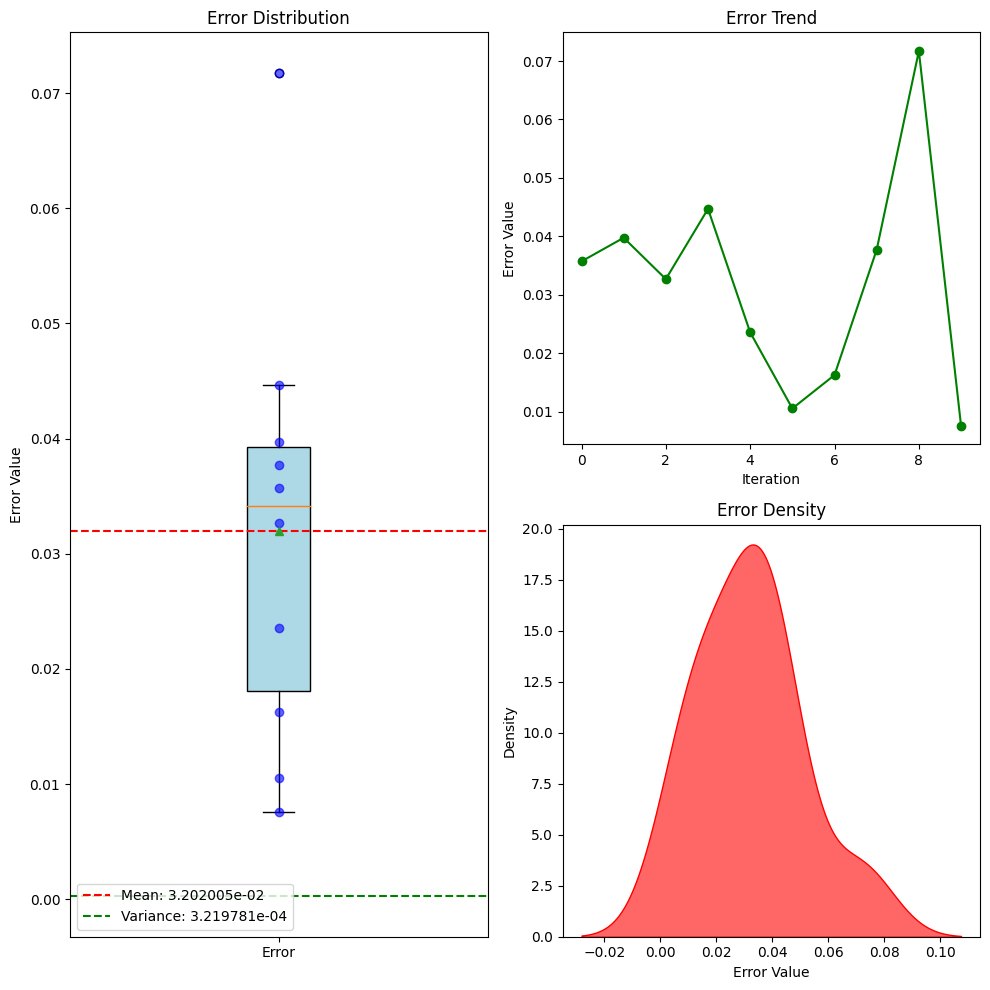

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = L1error

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [7]:
print('L1 error:', L1error)
print('L2 error:', L2error)

L1 error: [0.03570874520721238, 0.03975048827405235, 0.03267344141004239, 0.044697048407029635, 0.023559221767000094, 0.010530838604305592, 0.016252618990618077, 0.037699998934887284, 0.07171224592540812, 0.007615844684958597]
L2 error: [0.055495059176157, 0.18336284948275, 0.15278239517165726, 0.24253048718359885, 0.05102340578271932, 0.01696856925507112, 0.026060351853930925, 0.1526995811910062, 0.10791907092534622, 0.013216007574406627]
